In [9]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import time
import sklearn.metrics as metrics
from sklearn import preprocessing
import itertools as intert
import seaborn as sns;sns.set()
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
import scipy.cluster.vq as vq

To avoid extra calculus we set a "verbose_analysis" variable that is in charge to run or not the analysis code.

In [20]:
verbose_analysis = True

Let us first read the train and test files

In [21]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

We create a SIFT object detector and descriptor

In [22]:
SIFTdetector = cv2.xfeatures2d.SIFT_create()

**Test other amounts of steps with dense sift**


5
For nfeatures=5 the accuracy is: 73.11028500619578
7
For nfeatures=7 the accuracy is: 73.85377942998761
10
For nfeatures=10 the accuracy is: 74.10161090458487
15
For nfeatures=15 the accuracy is: 78.56257744733581
20
For nfeatures=20 the accuracy is: 74.22552664188352
25
For nfeatures=25 the accuracy is: 74.4733581164808
30
For nfeatures=30 the accuracy is: 71.87112763320943
35
For nfeatures=35 the accuracy is: 71.37546468401487
40
For nfeatures=40 the accuracy is: 70.87980173482032
50
For nfeatures=50 the accuracy is: 68.15365551425032
75
For nfeatures=75 the accuracy is: 65.17967781908303
100
For nfeatures=100 the accuracy is: 64.18835192069393


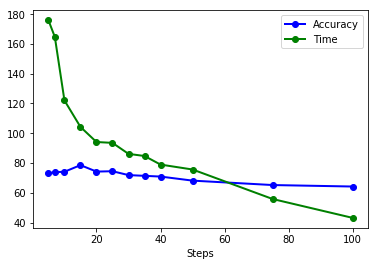

In [19]:
if verbose_analysis:
    step_sizes = [5,7,10,15,20,25,30,35,40,50,75,100]
    nfeatures_list = [950]
    accuracies = list()
    time_list = list()

    for step_size in step_sizes:
        start = time.time()
        print(step_size)
        SIFTdetector = cv2.xfeatures2d.SIFT_create()

        Train_descriptors = []
        Train_label_per_descriptor = []
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)

        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook.fit(D)

        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)

        knn = KNeighborsClassifier(n_neighbors=19, n_jobs=-1, metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
        for i in range(len(test_images_filenames)):
            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)

        accuracy = 100*knn.score(visual_words_test, test_labels)

        end = time.time()
        tTime = end - start
        accuracies.append(accuracy)
        time_list.append(tTime)
        print('For nfeatures=' + str(step_size) + ' the accuracy is: ' + str(accuracy))
    plt.plot(step_sizes, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(step_sizes, time_list, 'go-', label='Time', linewidth=2,color='green')
    plt.legend(['Accuracy','Time'])
    plt.xlabel('Steps')
    plt.show()


1
78.56257744733581
0.7872329532681197
0.7922014356698007
0.7864377831397418
For scales=1 the accuracy is: 78.56257744733581
2
66.4188351920694
0.6714333312836025
0.6685261845855035
0.666345458998366
For scales=2 the accuracy is: 66.4188351920694
4
51.92069392812887
0.543018890570304
0.5199275547696118
0.518382745668079
For scales=4 the accuracy is: 51.92069392812887
8
41.14002478314746
0.42387870628153057
0.4086058696042396
0.4058995962248199
For scales=8 the accuracy is: 41.14002478314746
16
32.83767038413878
0.374530929135657
0.3262371033959228
0.3165888500040709
For scales=16 the accuracy is: 32.83767038413878
32
19.206939281288722
0.2162866712902687
0.17967543506559372
0.15544054104692046
For scales=32 the accuracy is: 19.206939281288722
64
14.869888475836431
0.1495366427127298
0.13214530830221682
0.09426523534726282
For scales=64 the accuracy is: 14.869888475836431


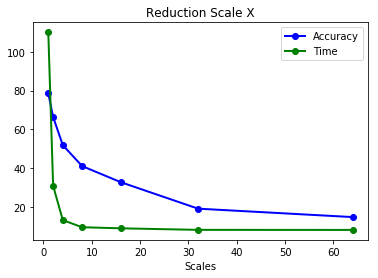

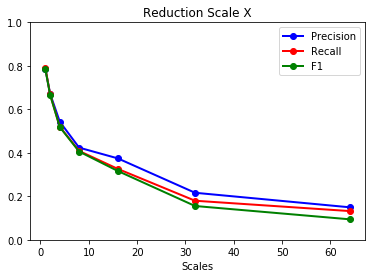

1
78.56257744733581
0.7872329532681197
0.7922014356698007
0.7864377831397418
For scales=1 the accuracy is: 78.56257744733581
1.15
77.19950433705081
0.7726702933134384
0.7818072544820487
0.7712403720844752
For scales=1.15 the accuracy is: 77.19950433705081
1.25
78.31474597273854
0.7858123768381684
0.7925025109148665
0.7836921744251482
For scales=1.25 the accuracy is: 78.31474597273854
1.5
76.95167286245353
0.774999416810668
0.7801484538631329
0.7701606789296694
For scales=1.5 the accuracy is: 76.95167286245353
1.75
77.32342007434944
0.7779533582134326
0.7851297002215094
0.7733755490312562
For scales=1.75 the accuracy is: 77.32342007434944
2
74.59727385377943
0.7540900718945701
0.758421630452217
0.7476551875730224
For scales=2 the accuracy is: 74.59727385377943


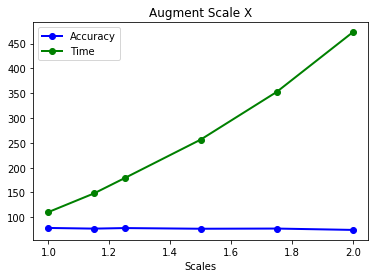

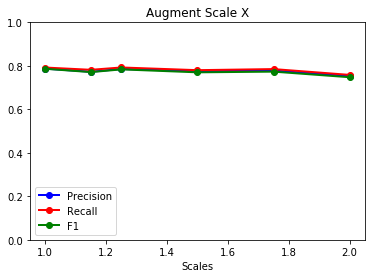

In [11]:


if verbose_analysis:
    scales = [1,2,4,8,16,32,64]
    step_size = 15
    accuracies = list()
    time_list = list()
    precisions = list()
    recalls = list()
    f1s = list()
    for scale in scales:
        start = time.time()
        print(scale)
        SIFTdetector = cv2.xfeatures2d.SIFT_create()

        Train_descriptors = []
        Train_label_per_descriptor = []
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x / scale)
            w = int(y / scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)

        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook.fit(D)

        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)

        knn = KNeighborsClassifier(n_neighbors=19, n_jobs=-1, metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
        results = list()
        for i in range(len(test_images_filenames)):
            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x / scale)
            w = int(y / scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)
        accuracy = 100 * knn.score(visual_words_test, test_labels)
        predict_labels = knn.predict(visual_words_test)
        #probs = knn.predict_proba(visual_words_test)
        precision = metrics.precision_score(test_labels, predict_labels,average = 'macro')
        recall = metrics.recall_score(test_labels, predict_labels,average = 'macro')
        f1 = metrics.f1_score(test_labels, predict_labels,average = 'macro')


        end = time.time()
        tTime = end - start

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        time_list.append(tTime)
        print(accuracy)
        print(precision)
        print(recall)
        print(f1)
        print('For scales=' + str(scale) + ' the accuracy is: ' + str(accuracy))


    plt.plot(scales, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('Scales')
    plt.title('Reduction Scale X')
    plt.show()

    plt.plot(scales, precisions, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, recalls, 'go-', label='Accuracy', linewidth=2, color='red')
    plt.plot(scales, f1s, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall','F1'])
    plt.xlabel('Scales')
    plt.title('Reduction Scale X')
    plt.ylim([0,1])
    plt.show()
    
    scales = [1, 1.15, 1.25, 1.5, 1.75, 2]
    step_size = 15
    accuracies = list()
    time_list = list()
    precisions = list()
    recalls = list()
    f1s = list()
    for scale in scales:
        start = time.time()
        print(scale)
        SIFTdetector = cv2.xfeatures2d.SIFT_create()

        Train_descriptors = []
        Train_label_per_descriptor = []
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x * scale)
            w = int(y * scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)

        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook.fit(D)

        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)

        knn = KNeighborsClassifier(n_neighbors=19, n_jobs=-1, metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
        results = list()
        for i in range(len(test_images_filenames)):
            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x * scale)
            w = int(y * scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)
        accuracy = 100 * knn.score(visual_words_test, test_labels)
        predict_labels = knn.predict(visual_words_test)
        #probs = knn.predict_proba(visual_words_test)
        precision = metrics.precision_score(test_labels, predict_labels,average = 'macro')
        recall = metrics.recall_score(test_labels, predict_labels,average = 'macro')
        f1 = metrics.f1_score(test_labels, predict_labels,average = 'macro')


        end = time.time()
        tTime = end - start

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        time_list.append(tTime)
        print(accuracy)
        print(precision)
        print(recall)
        print(f1)
        print('For scales=' + str(scale) + ' the accuracy is: ' + str(accuracy))


    plt.plot(scales, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('Scales')
    plt.title('Augment Scale X')
    plt.show()

    plt.plot(scales, precisions, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, recalls, 'go-', label='Accuracy', linewidth=2, color='red')
    plt.plot(scales, f1s, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall','F1'])
    plt.xlabel('Scales')
    plt.title('Augment Scale X')
    plt.ylim([0,1])
    plt.show()



**L2 norm - power norm**


1
76.82775712515489
0.7707115580326924
0.7748222796346527
0.7675185899488082
For scales=1 the accuracy is: 76.82775712515489
2
66.66666666666666
0.6693786382933428
0.6723973649534225
0.6663791057446102
For scales=2 the accuracy is: 66.66666666666666
4
51.42503097893433
0.5335564248642841
0.5114283975616277
0.5119341775977666
For scales=4 the accuracy is: 51.42503097893433
8
42.998760842627014
0.44254417744226826
0.4263376239872484
0.42647980849720285
For scales=8 the accuracy is: 42.998760842627014
16
31.84634448574969
0.3510855156741433
0.31586857464565266
0.3033759472008602
For scales=16 the accuracy is: 31.84634448574969
32
17.348203221809168
0.17213898445382175
0.16467958099898666
0.13292719370312608
For scales=32 the accuracy is: 17.348203221809168
64
16.356877323420075
0.18335193045517192
0.14910800278493946
0.11590812846825765
For scales=64 the accuracy is: 16.356877323420075


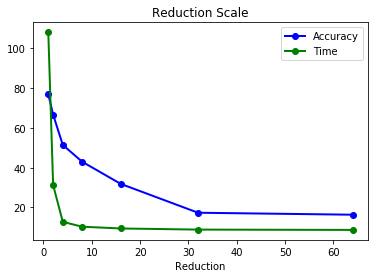

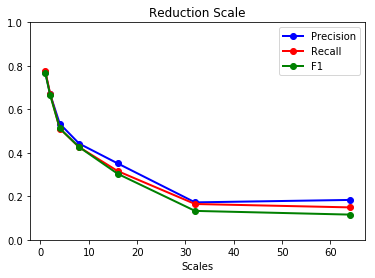

1
76.82775712515489
0.7707115580326924
0.7748222796346527
0.7675185899488082
For scales=1 the accuracy is: 76.82775712515489
1.15
77.32342007434944
0.7776333769872393
0.78234635797266
0.7748221847472868
For scales=1.15 the accuracy is: 77.32342007434944
1.25
78.68649318463446
0.7896088440832884
0.7940556889979267
0.786295398193838
For scales=1.25 the accuracy is: 78.68649318463446
1.5
77.07558859975217
0.7736884055585398
0.7798528702199028
0.7710156355523798
For scales=1.5 the accuracy is: 77.07558859975217
1.75
77.44733581164807
0.7730911871877562
0.7833161117780012
0.7740308876264588
For scales=1.75 the accuracy is: 77.44733581164807
2
75.21685254027261
0.7590186248833918
0.763182422051374
0.7523102637235184
For scales=2 the accuracy is: 75.21685254027261


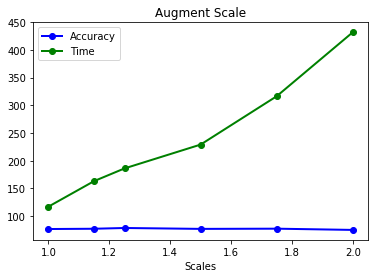

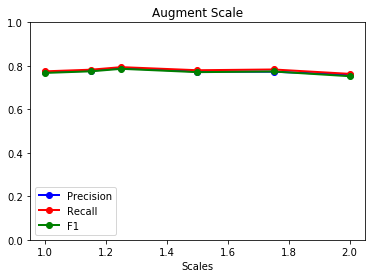

[0.7707115580326924, 0.7748222796346527, 0.7675185899488082]
[0.6693786382933428, 0.6723973649534225, 0.6663791057446102]
[0.5335564248642841, 0.5114283975616277, 0.5119341775977666]
[0.44254417744226826, 0.4263376239872484, 0.42647980849720285]
[0.3510855156741433, 0.31586857464565266, 0.3033759472008602]
[0.17213898445382175, 0.16467958099898666, 0.13292719370312608]
[0.18335193045517192, 0.14910800278493946, 0.11590812846825765]
[0.7707115580326924, 0.7748222796346527, 0.7675185899488082]
[0.7776333769872393, 0.78234635797266, 0.7748221847472868]
[0.7896088440832884, 0.7940556889979267, 0.786295398193838]
[0.7736884055585398, 0.7798528702199028, 0.7710156355523798]
[0.7730911871877562, 0.7833161117780012, 0.7740308876264588]
[0.7590186248833918, 0.763182422051374, 0.7523102637235184]
plotMat: [[0.7707115580326924, 0.7748222796346527, 0.7675185899488082], [0.6693786382933428, 0.6723973649534225, 0.6663791057446102], [0.5335564248642841, 0.5114283975616277, 0.5119341775977666], [0.442

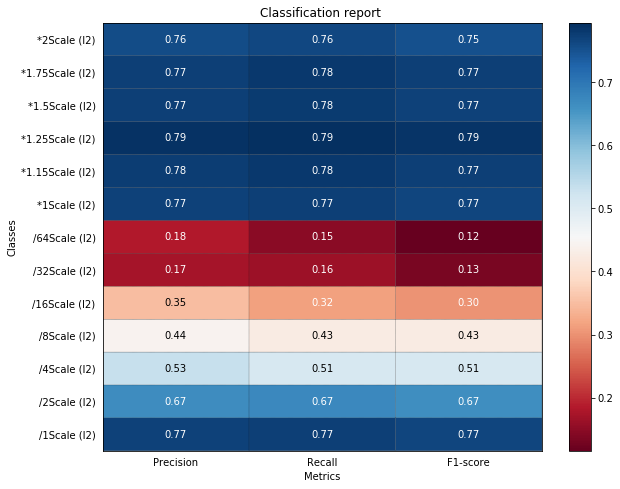

In [20]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in intert.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[1 : (len(lines) - 1)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(t[-1])
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


sampleClassificationReport = "{0} {1} {2} {3}".format('precision','recall','f1-score', 'norm') + '\n'

if verbose_analysis:
    scales = [1,2,4,8,16,32,64]
    step_size = 15
    accuracies = list()
    time_list = list()
    precisions = list()
    recalls = list()
    f1s = list()
    for scale in scales:
        start = time.time()
        print(scale)
        SIFTdetector = cv2.xfeatures2d.SIFT_create()

        Train_descriptors = []
        Train_label_per_descriptor = []
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x / scale)
            w = int(y / scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            des = preprocessing.normalize(des, norm='l2')
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)

        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook.fit(D)

        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)

        knn = KNeighborsClassifier(n_neighbors=19, n_jobs=-1, metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
        results = list()
        for i in range(len(test_images_filenames)):
            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x / scale)
            w = int(y / scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            des = preprocessing.normalize(des, norm='l2')
            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)
        accuracy = 100 * knn.score(visual_words_test, test_labels)
        predict_labels = knn.predict(visual_words_test)
        #probs = knn.predict_proba(visual_words_test)
        precision = metrics.precision_score(test_labels, predict_labels,average = 'macro')
        recall = metrics.recall_score(test_labels, predict_labels,average = 'macro')
        f1 = metrics.f1_score(test_labels, predict_labels,average = 'macro')


        end = time.time()
        tTime = end - start

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        time_list.append(tTime)
        print(accuracy)
        print(precision)
        print(recall)
        print(f1)
        print('For scales=' + str(scale) + ' the accuracy is: ' + str(accuracy))
        sampleClassificationReport += ("/{0}Scale {1} {2} {3} l2".format(scale,precision,recall,f1) + '\n')


    plt.plot(scales, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('Reduction')
    plt.title('Reduction Scale')
    plt.show()

    plt.plot(scales, precisions, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, recalls, 'go-', label='Accuracy', linewidth=2, color='red')
    plt.plot(scales, f1s, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall', 'F1'])
    plt.xlabel('Scales')
    plt.title('Reduction Scale')
    plt.ylim([0, 1])
    plt.show()

    scales = [1, 1.15, 1.25, 1.5, 1.75, 2]
    step_size = 15
    accuracies = list()
    time_list = list()
    precisions = list()
    recalls = list()
    f1s = list()
    for scale in scales:
        start = time.time()
        print(scale)
        SIFTdetector = cv2.xfeatures2d.SIFT_create()

        Train_descriptors = []
        Train_label_per_descriptor = []
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x * scale)
            w = int(y * scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            des = preprocessing.normalize(des, norm='l2')
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)

        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook.fit(D)

        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)

        knn = KNeighborsClassifier(n_neighbors=19, n_jobs=-1, metric='euclidean')
        knn.fit(visual_words, train_labels)

        visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
        results = list()
        for i in range(len(test_images_filenames)):
            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x * scale)
            w = int(y * scale)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            des = preprocessing.normalize(des, norm='l2')
            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)
        accuracy = 100 * knn.score(visual_words_test, test_labels)
        predict_labels = knn.predict(visual_words_test)
        # probs = knn.predict_proba(visual_words_test)
        precision = metrics.precision_score(test_labels, predict_labels, average='macro')
        recall = metrics.recall_score(test_labels, predict_labels, average='macro')
        f1 = metrics.f1_score(test_labels, predict_labels, average='macro')

        end = time.time()
        tTime = end - start

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        time_list.append(tTime)
        print(accuracy)
        print(precision)
        print(recall)
        print(f1)
        print('For scales=' + str(scale) + ' the accuracy is: ' + str(accuracy))
        sampleClassificationReport += ("*{0}Scale {1} {2} {3} l2".format(scale, precision, recall, f1) + '\n')

    plt.plot(scales, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('Scales')
    plt.title('Augment Scale')
    plt.show()

    plt.plot(scales, precisions, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(scales, recalls, 'go-', label='Accuracy', linewidth=2, color='red')
    plt.plot(scales, f1s, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall', 'F1'])
    plt.xlabel('Scales')
    plt.title('Augment Scale')
    plt.ylim([0, 1])
    plt.show()

    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

**SVM**

2
linear
{'C': 0.0001, 'gamma': 1e-05}
{'mean_fit_time': array([0.11418331, 0.10923648, 0.10085654, 0.10295331, 0.10838294,
       0.10354567, 0.09015095, 0.09087646, 0.08802855, 0.08869064,
       0.08577514, 0.09533703, 0.09557557, 0.09747791, 0.09784746,
       0.10025573, 0.09568286, 0.09670794, 0.07880044, 0.08239698,
       0.08512449, 0.08211637, 0.08120072, 0.08106184, 0.08460951,
       0.08561397, 0.0896374 , 0.08460605, 0.08410954, 0.08397436,
       0.08700752, 0.0882051 , 0.08846247, 0.09066153, 0.08941901,
       0.09130561, 0.09087181, 0.10583103, 0.09984493, 0.10197294,
       0.10055804, 0.08874905]), 'std_fit_time': array([1.41226053e-02, 1.02283955e-02, 1.13844872e-03, 3.35252285e-03,
       1.32513046e-03, 1.21855736e-03, 8.80801678e-03, 3.80146503e-03,
       6.50525093e-04, 1.09541416e-03, 2.92611122e-03, 5.65087795e-03,
       8.59498978e-04, 7.82966614e-04, 2.60257721e-03, 2.59113312e-03,
       4.99701500e-03, 3.73995304e-03, 2.38156319e-03, 6.04701042e-03,
   

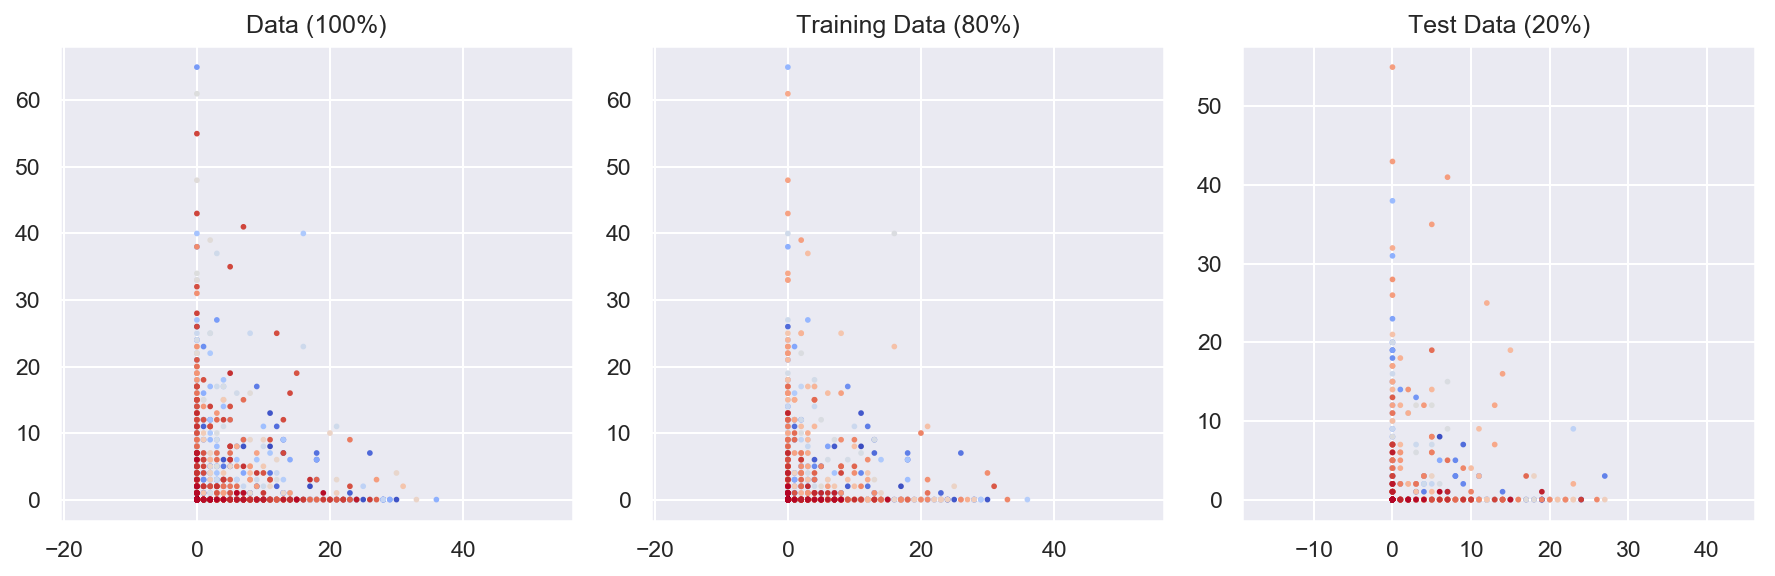

Accuracy0.8190830235439901
Precision0.823007601289306
Recall0.8175582330855926
F1 Score0.8189809911028683


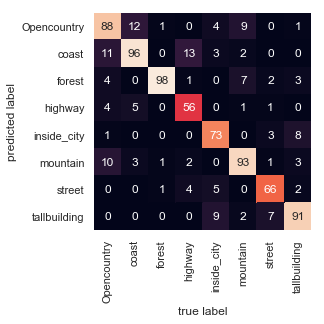

[0.77, 0.75, 0.76]
[0.77, 0.83, 0.8]
[0.85, 0.97, 0.91]
[0.84, 0.74, 0.78]
[0.86, 0.78, 0.82]
[0.82, 0.82, 0.82]
[0.85, 0.82, 0.84]
[0.83, 0.84, 0.84]
plotMat: [[0.77, 0.75, 0.76], [0.77, 0.83, 0.8], [0.85, 0.97, 0.91], [0.84, 0.74, 0.78], [0.86, 0.78, 0.82], [0.82, 0.82, 0.82], [0.85, 0.82, 0.84], [0.83, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


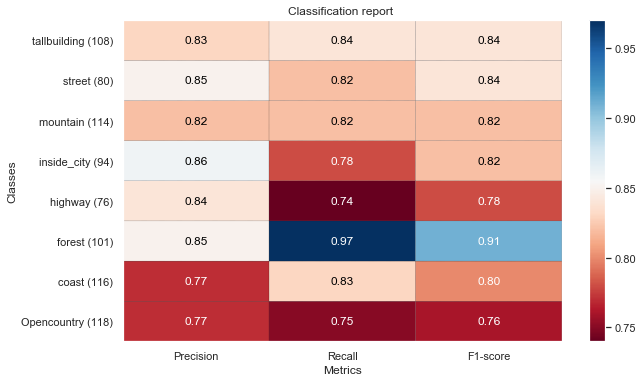

For Kernel=linear the accuracy is: 0.8190830235439901
rbf
{'C': 10, 'gamma': 1e-05}
{'mean_fit_time': array([0.28921604, 0.26034939, 0.25943148, 0.27303016, 0.26912999,
       0.23954558, 0.26055694, 0.26750755, 0.27950311, 0.28222179,
       0.30683613, 0.2540704 , 0.27422714, 0.27132416, 0.28434217,
       0.31789196, 0.30089569, 0.26758409, 0.27104855, 0.2216301 ,
       0.2872225 , 0.33354318, 0.30122101, 0.2697612 , 0.18930256,
       0.11909461, 0.31395113, 0.36414289, 0.31664312, 0.2705909 ,
       0.10173357, 0.10169446, 0.32534313, 0.38631761, 0.346403  ,
       0.28397238, 0.09838259, 0.10684597, 0.29828203, 0.39841115,
       0.33550334, 0.30790401]), 'std_fit_time': array([0.02852106, 0.00562561, 0.00665343, 0.00881398, 0.00349998,
       0.00046563, 0.00111294, 0.00375438, 0.00561309, 0.00314307,
       0.00093317, 0.00383246, 0.0022161 , 0.00524592, 0.00766599,
       0.01334894, 0.00173545, 0.00417209, 0.00821757, 0.00030088,
       0.0003525 , 0.00705302, 0.00720394, 0.

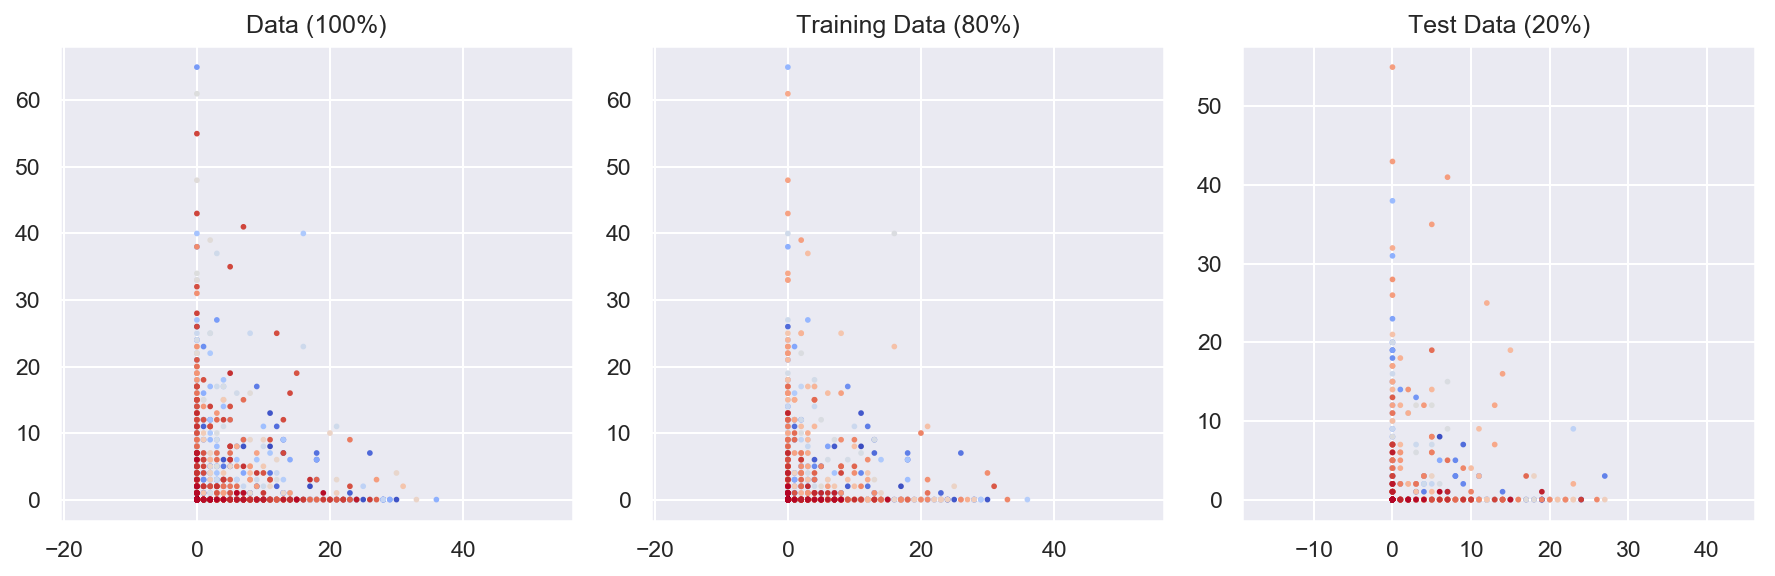

Accuracy0.8351920693928129
Precision0.8389312268361324
Recall0.8356325742418551
F1 Score0.836434588696136


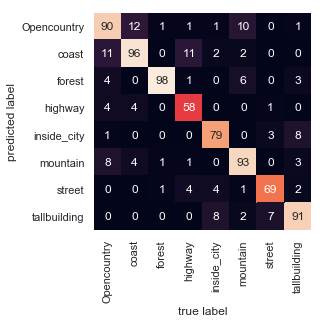

[0.78, 0.76, 0.77]
[0.79, 0.83, 0.81]
[0.88, 0.97, 0.92]
[0.87, 0.76, 0.81]
[0.87, 0.84, 0.85]
[0.85, 0.82, 0.83]
[0.85, 0.86, 0.86]
[0.84, 0.84, 0.84]
plotMat: [[0.78, 0.76, 0.77], [0.79, 0.83, 0.81], [0.88, 0.97, 0.92], [0.87, 0.76, 0.81], [0.87, 0.84, 0.85], [0.85, 0.82, 0.83], [0.85, 0.86, 0.86], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


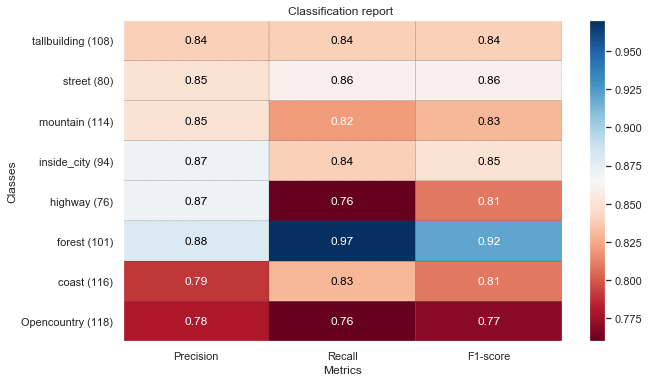

For Kernel=rbf the accuracy is: 0.8351920693928129
poly2
{'C': 0.001, 'gamma': 0.01}
{'mean_fit_time': array([0.25409901, 0.22780502, 0.23617256, 0.15988958, 0.1212846 ,
       0.12079203, 0.24162257, 0.23042512, 0.22689855, 0.10790658,
       0.1324755 , 0.1171205 , 0.23014641, 0.24387443, 0.15614665,
       0.11809373, 0.12257051, 0.11401606, 0.23129654, 0.22830343,
       0.10540462, 0.11993945, 0.11532748, 0.11556458, 0.23951101,
       0.14692843, 0.12014794, 0.12027407, 0.11524916, 0.11251295,
       0.22759664, 0.11306202, 0.12613201, 0.12136161, 0.11740887,
       0.11844993, 0.16127598, 0.11554062, 0.12190914, 0.12108994,
       0.11816311, 0.12104106]), 'std_fit_time': array([0.02658212, 0.00092494, 0.00459135, 0.00269639, 0.00670254,
       0.01079595, 0.00343335, 0.00306892, 0.01143157, 0.00377059,
       0.00914752, 0.00654936, 0.00258255, 0.00421751, 0.0047735 ,
       0.0050869 , 0.00269842, 0.00260997, 0.00164771, 0.01088643,
       0.00052047, 0.0031935 , 0.00318849, 0

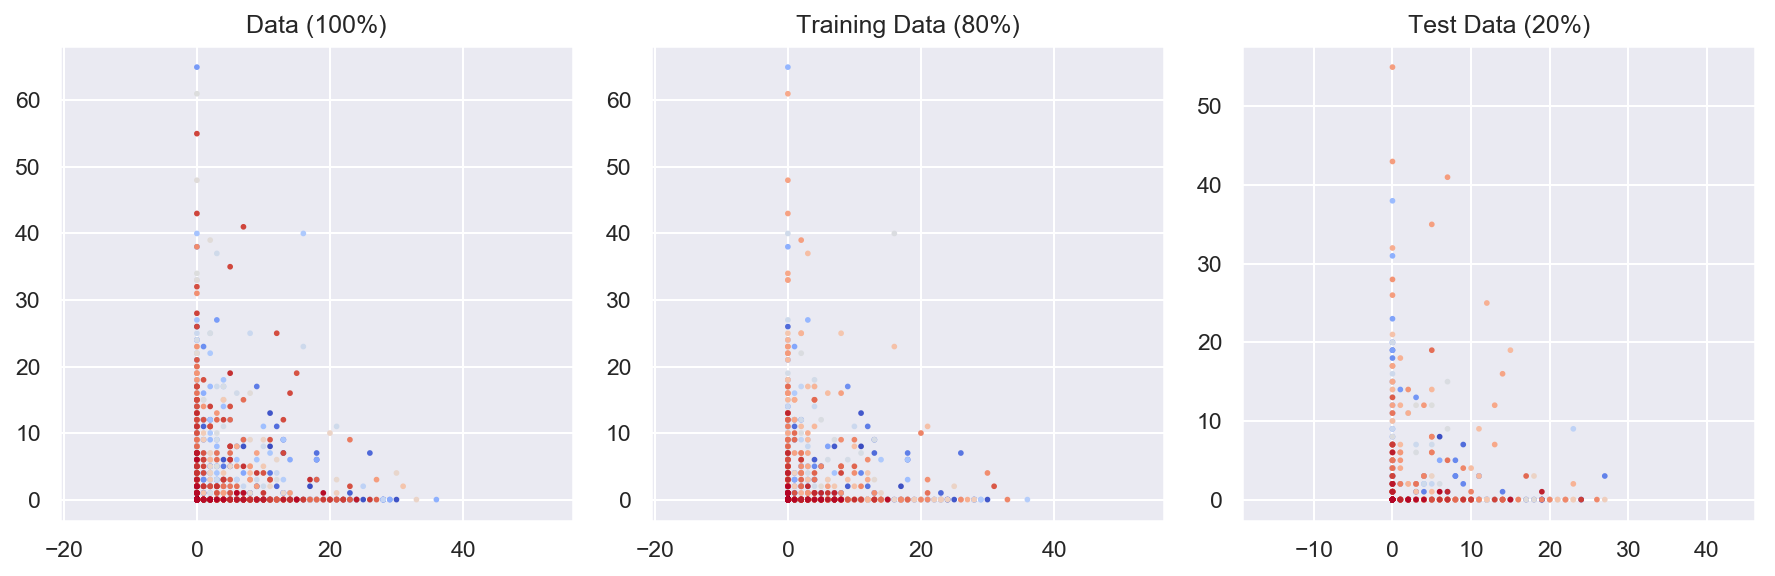

Accuracy0.838909541511772
Precision0.8393754258913395
Recall0.8413712723836249
F1 Score0.8401313637425575


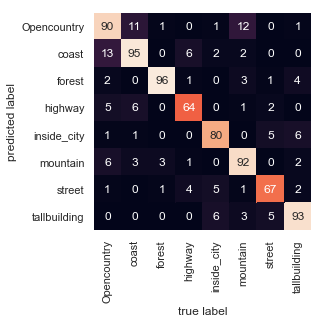

[0.78, 0.76, 0.77]
[0.81, 0.82, 0.81]
[0.9, 0.95, 0.92]
[0.82, 0.84, 0.83]
[0.86, 0.85, 0.86]
[0.86, 0.81, 0.83]
[0.83, 0.84, 0.83]
[0.87, 0.86, 0.87]
plotMat: [[0.78, 0.76, 0.77], [0.81, 0.82, 0.81], [0.9, 0.95, 0.92], [0.82, 0.84, 0.83], [0.86, 0.85, 0.86], [0.86, 0.81, 0.83], [0.83, 0.84, 0.83], [0.87, 0.86, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


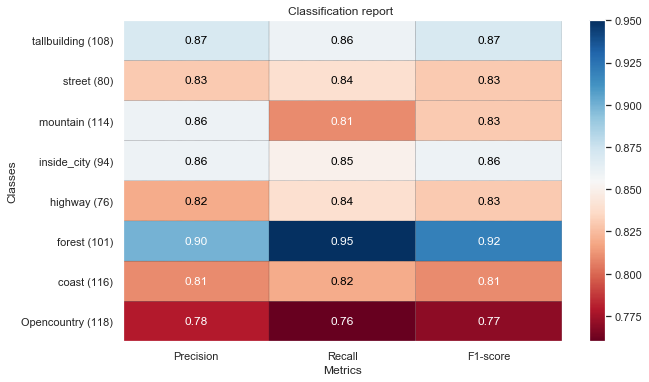

For Kernel=poly2 the accuracy is: 0.838909541511772
poly3
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.25250518, 0.22604895, 0.23691535, 0.17923391, 0.16303051,
       0.1651547 , 0.22818816, 0.23704004, 0.20281208, 0.17446601,
       0.17772317, 0.15923226, 0.22803044, 0.23665237, 0.15403652,
       0.16377759, 0.16008532, 0.16261053, 0.23506105, 0.23498642,
       0.17024612, 0.16851485, 0.16466045, 0.16813445, 0.22960532,
       0.20565343, 0.16452253, 0.1720854 , 0.1678735 , 0.1805135 ,
       0.23827541, 0.15090942, 0.16722941, 0.16579151, 0.16184485,
       0.18262255, 0.23005307, 0.16926563, 0.16995406, 0.16571164,
       0.16476452, 0.34640145]), 'std_fit_time': array([0.02161896, 0.01066494, 0.01776457, 0.00343597, 0.00370944,
       0.00979567, 0.00382674, 0.00053287, 0.012025  , 0.00266397,
       0.00494814, 0.00140345, 0.00425243, 0.00227165, 0.0064683 ,
       0.00220132, 0.0007304 , 0.0012486 , 0.01127875, 0.0019604 ,
       0.0046649 , 0.00108206, 0.00063252,

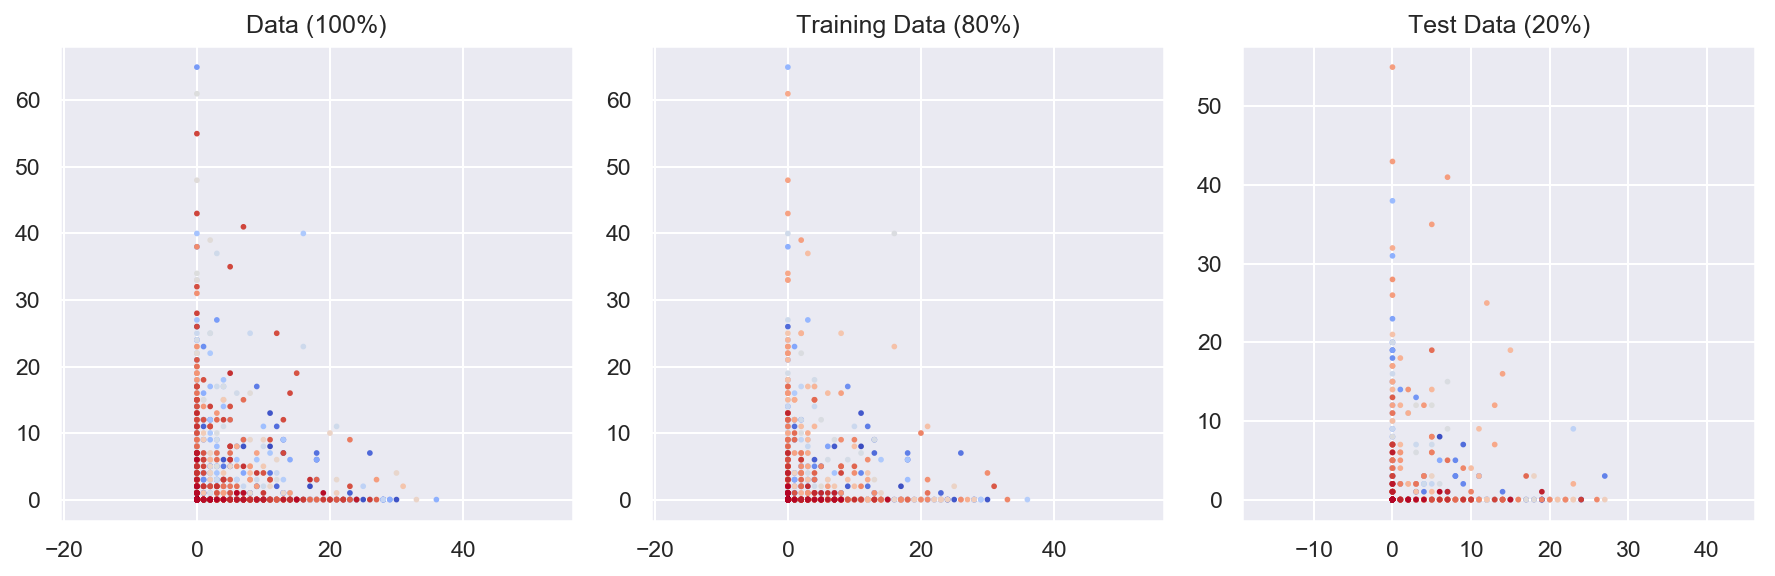

Accuracy0.8413878562577447
Precision0.8441850473062413
Recall0.8471988674567503
F1 Score0.8451200002238985


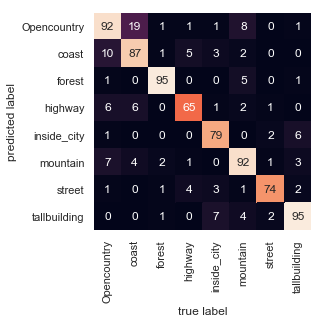

[0.75, 0.78, 0.76]
[0.81, 0.75, 0.78]
[0.93, 0.94, 0.94]
[0.8, 0.86, 0.83]
[0.9, 0.84, 0.87]
[0.84, 0.81, 0.82]
[0.86, 0.93, 0.89]
[0.87, 0.88, 0.88]
plotMat: [[0.75, 0.78, 0.76], [0.81, 0.75, 0.78], [0.93, 0.94, 0.94], [0.8, 0.86, 0.83], [0.9, 0.84, 0.87], [0.84, 0.81, 0.82], [0.86, 0.93, 0.89], [0.87, 0.88, 0.88]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


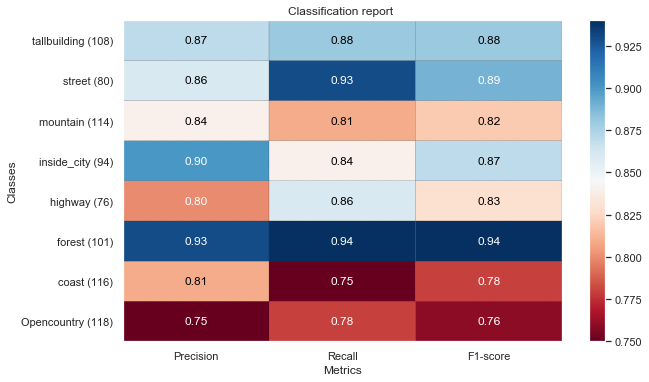

For Kernel=poly3 the accuracy is: 0.8413878562577447
poly4
{'C': 100, 'gamma': 1}
{'mean_fit_time': array([0.27813649, 0.23136508, 0.24502409, 0.21478736, 0.22246146,
       0.21847296, 0.23321187, 0.23320651, 0.19176602, 0.2127825 ,
       0.20718753, 0.2154789 , 0.24227142, 0.241413  , 0.19893897,
       0.21672547, 0.21290743, 0.21721649, 0.23607516, 0.22941756,
       0.21762347, 0.20695758, 0.21828723, 0.20359409, 0.23668003,
       0.22181749, 0.22289944, 0.21806657, 0.2189374 , 0.21915698,
       0.22726357, 0.20119596, 0.21393299, 0.21869504, 0.21748459,
       0.22585166, 0.24093103, 0.2024529 , 0.2213589 , 0.22222853,
       0.23949444, 0.218449  ]), 'std_fit_time': array([3.48949432e-03, 3.46100330e-03, 7.90703297e-03, 9.54043865e-03,
       5.32269478e-03, 5.72991371e-03, 6.13093376e-04, 1.11150742e-03,
       8.25595856e-03, 2.26747990e-03, 2.69567966e-03, 2.22897530e-03,
       2.31504440e-04, 5.65207005e-03, 7.80594349e-03, 3.81743908e-03,
       4.99761105e-03, 6.363391

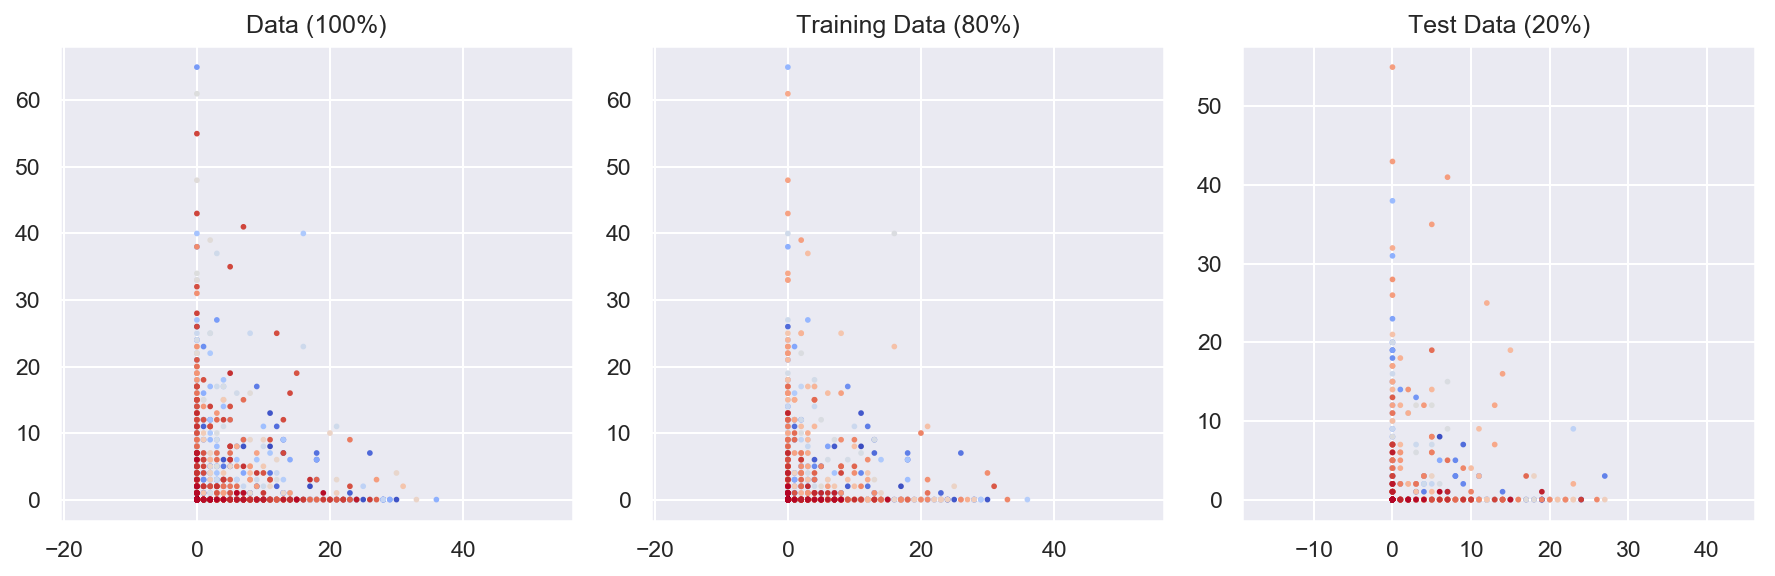

Accuracy0.8228004956629492
Precision0.8242602008914351
Recall0.828777633322022
F1 Score0.8257515530894196


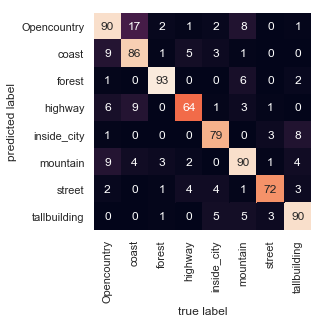

[0.74, 0.76, 0.75]
[0.82, 0.74, 0.78]
[0.91, 0.92, 0.92]
[0.76, 0.84, 0.8]
[0.87, 0.84, 0.85]
[0.8, 0.79, 0.79]
[0.83, 0.9, 0.86]
[0.87, 0.83, 0.85]
plotMat: [[0.74, 0.76, 0.75], [0.82, 0.74, 0.78], [0.91, 0.92, 0.92], [0.76, 0.84, 0.8], [0.87, 0.84, 0.85], [0.8, 0.79, 0.79], [0.83, 0.9, 0.86], [0.87, 0.83, 0.85]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


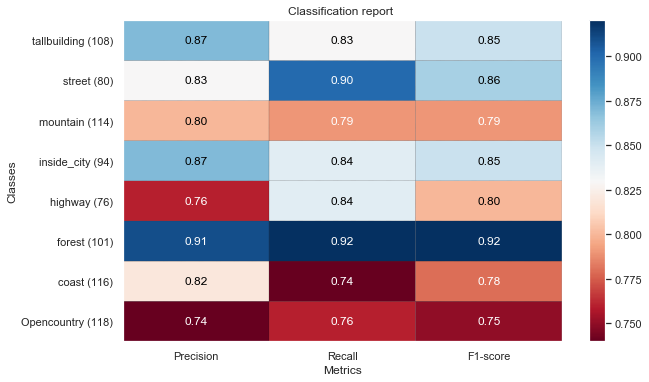

For Kernel=poly4 the accuracy is: 0.8228004956629492
poly5
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.25820065, 0.23449707, 0.22508657, 0.24725127, 0.23726094,
       0.2403475 , 0.24250448, 0.24099612, 0.19761658, 0.22911298,
       0.23947036, 0.2400943 , 0.23943961, 0.24325156, 0.23523307,
       0.24269104, 0.23603451, 0.23882031, 0.23240602, 0.24305713,
       0.23044801, 0.23488033, 0.24198639, 0.24607289, 0.22923541,
       0.22990048, 0.22762609, 0.23603094, 0.24180067, 0.23677242,
       0.23690689, 0.21649909, 0.24035335, 0.2429105 , 0.23067236,
       0.22857141, 0.23702669, 0.19652903, 0.23612344, 0.23459673,
       0.24126148, 0.23389912]), 'std_fit_time': array([0.02384949, 0.00363398, 0.01473033, 0.00010061, 0.00653875,
       0.00864542, 0.00460231, 0.00288582, 0.00028348, 0.00164807,
       0.01167047, 0.00155652, 0.00278771, 0.00164557, 0.00575423,
       0.00331402, 0.00579345, 0.00325751, 0.0020119 , 0.0107311 ,
       0.00524688, 0.00121462, 0.00790155

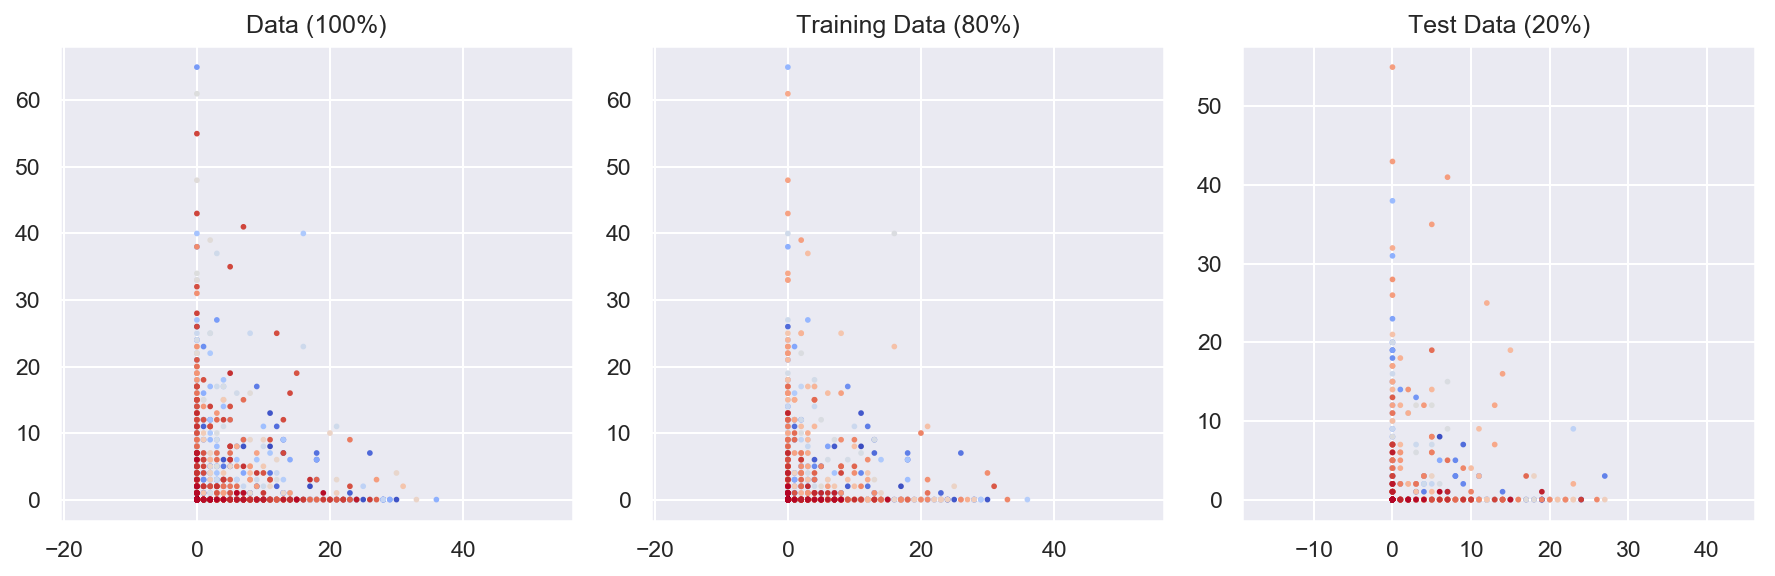

Accuracy0.80545229244114
Precision0.8087920287172827
Recall0.8129702831526092
F1 Score0.806956810338028


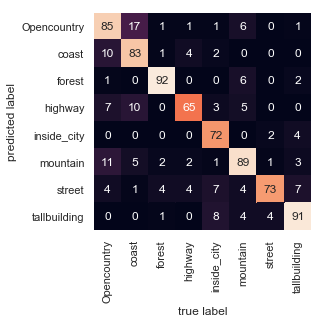

[0.76, 0.72, 0.74]
[0.83, 0.72, 0.77]
[0.91, 0.91, 0.91]
[0.72, 0.86, 0.78]
[0.92, 0.77, 0.84]
[0.78, 0.78, 0.78]
[0.7, 0.91, 0.79]
[0.84, 0.84, 0.84]
plotMat: [[0.76, 0.72, 0.74], [0.83, 0.72, 0.77], [0.91, 0.91, 0.91], [0.72, 0.86, 0.78], [0.92, 0.77, 0.84], [0.78, 0.78, 0.78], [0.7, 0.91, 0.79], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


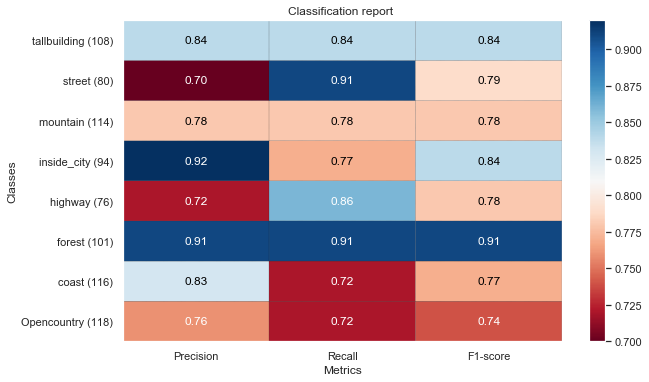

For Kernel=poly5 the accuracy is: 0.80545229244114
sigmoid
{'C': 10, 'gamma': 1e-05}
{'mean_fit_time': array([0.28050184, 0.26931858, 0.27462351, 0.31435347, 0.25634062,
       0.2359724 , 0.25382149, 0.2641319 , 0.27071333, 0.3020891 ,
       0.24132812, 0.23960698, 0.25308895, 0.25376487, 0.27437711,
       0.30077398, 0.24697196, 0.22979951, 0.27196646, 0.24135292,
       0.19554198, 0.31601441, 0.25844836, 0.2583015 , 0.22659457,
       0.12178147, 0.10094655, 0.26395893, 0.24799001, 0.24182963,
       0.10950136, 0.09235287, 0.07874799, 0.19611645, 0.2516886 ,
       0.25639737, 0.08321512, 0.0838623 , 0.06419802, 0.13581634,
       0.24159026, 0.23078644]), 'std_fit_time': array([2.28729248e-02, 5.36251068e-03, 1.89530849e-03, 1.05893612e-02,
       5.37955761e-03, 3.07345390e-03, 3.45146656e-03, 1.10820532e-02,
       1.64270401e-03, 1.82998180e-03, 2.44975090e-04, 1.00330114e-02,
       3.44991684e-03, 1.46007538e-03, 6.59489632e-03, 1.31829977e-02,
       5.93888760e-03, 6.125

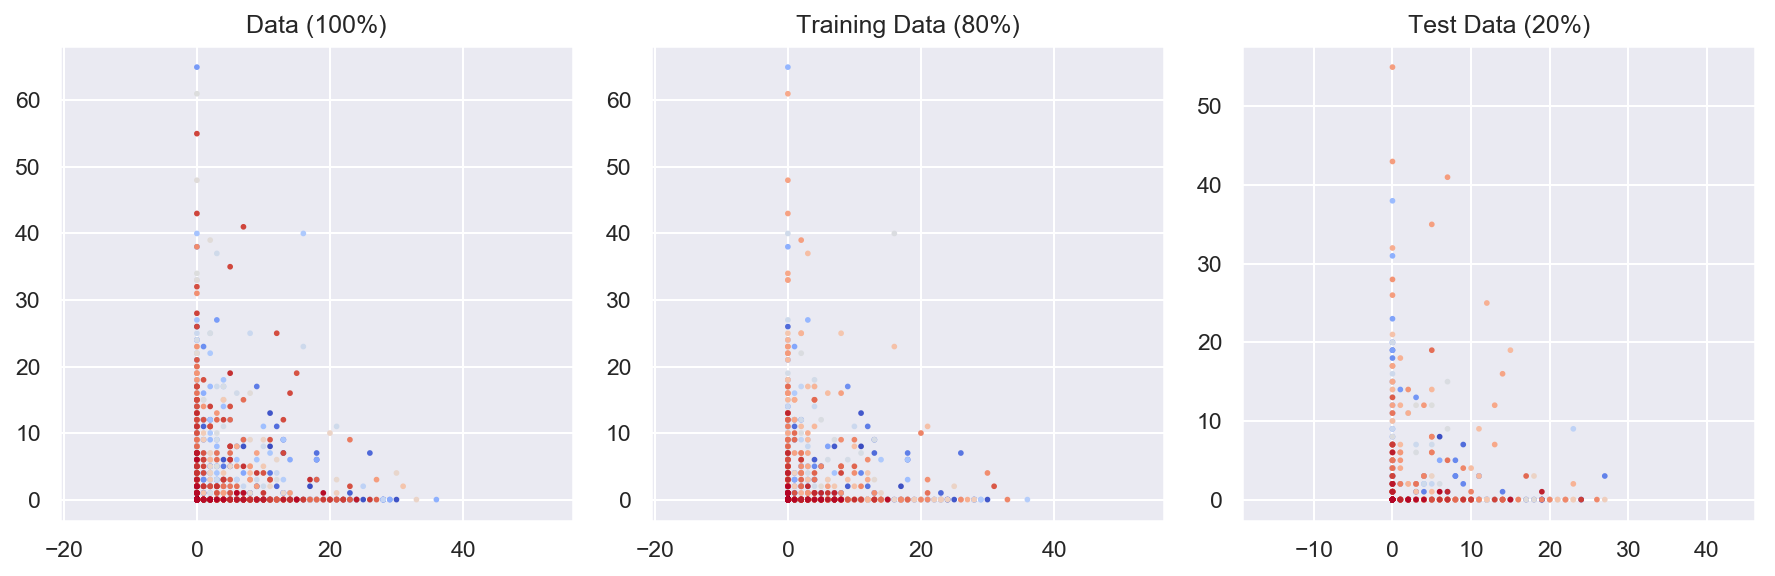

Accuracy0.8178438661710037
Precision0.821839560184983
Recall0.8159957330855926
F1 Score0.8175310959499343


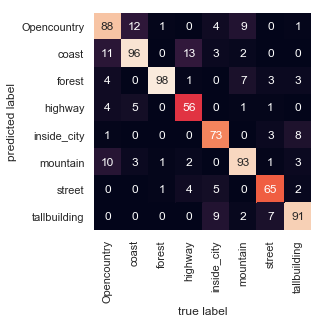

[0.77, 0.75, 0.76]
[0.77, 0.83, 0.8]
[0.84, 0.97, 0.9]
[0.84, 0.74, 0.78]
[0.86, 0.78, 0.82]
[0.82, 0.82, 0.82]
[0.84, 0.81, 0.83]
[0.83, 0.84, 0.84]
plotMat: [[0.77, 0.75, 0.76], [0.77, 0.83, 0.8], [0.84, 0.97, 0.9], [0.84, 0.74, 0.78], [0.86, 0.78, 0.82], [0.82, 0.82, 0.82], [0.84, 0.81, 0.83], [0.83, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


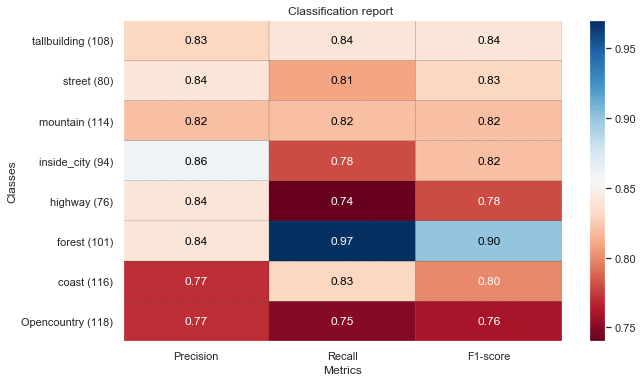

For Kernel=sigmoid the accuracy is: 0.8178438661710037


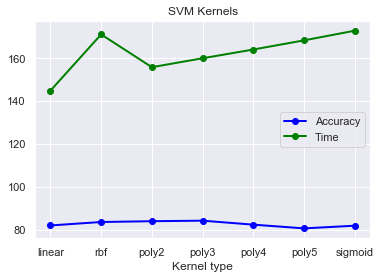

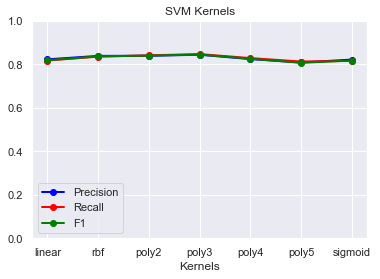

[0.823007601289306, 0.8175582330855926, 0.8189809911028683]
[0.8389312268361324, 0.8356325742418551, 0.836434588696136]
[0.8393754258913395, 0.8413712723836249, 0.8401313637425575]
[0.8441850473062413, 0.8471988674567503, 0.8451200002238985]
[0.8242602008914351, 0.828777633322022, 0.8257515530894196]
[0.8087920287172827, 0.8129702831526092, 0.806956810338028]
[0.821839560184983, 0.8159957330855926, 0.8175310959499343]
plotMat: [[0.823007601289306, 0.8175582330855926, 0.8189809911028683], [0.8389312268361324, 0.8356325742418551, 0.836434588696136], [0.8393754258913395, 0.8413712723836249, 0.8401313637425575], [0.8441850473062413, 0.8471988674567503, 0.8451200002238985], [0.8242602008914351, 0.828777633322022, 0.8257515530894196], [0.8087920287172827, 0.8129702831526092, 0.806956810338028], [0.821839560184983, 0.8159957330855926, 0.8175310959499343]]
support: ["{'C':0.0001,'gamma':1e-05}", "{'C':10,'gamma':1e-05}", "{'C':0.001,'gamma':0.01}", "{'C':0.0001,'gamma':0.01}", "{'C':100,'gamma

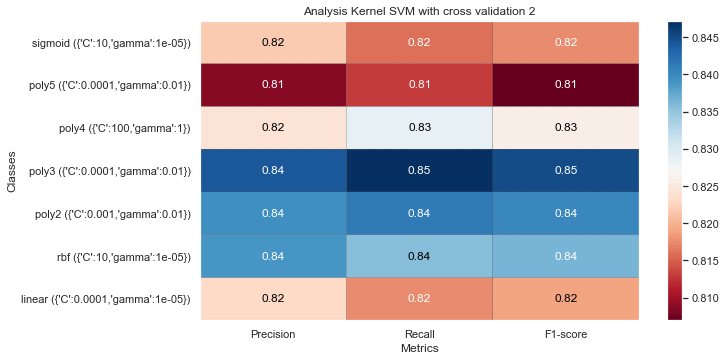

3
linear
{'C': 0.001, 'gamma': 1e-05}
{'mean_fit_time': array([0.17625729, 0.15828943, 0.18436058, 0.20352228, 0.17091799,
       0.15922713, 0.12501287, 0.12056812, 0.12198687, 0.12357624,
       0.12292242, 0.12229967, 0.13688564, 0.13693897, 0.13226668,
       0.13435396, 0.13922556, 0.14602868, 0.18617161, 0.17868527,
       0.17610097, 0.1823171 , 0.18053969, 0.1818618 , 0.17892464,
       0.1744194 , 0.17860556, 0.1756134 , 0.1759642 , 0.18632897,
       0.17790373, 0.18400741, 0.17657526, 0.17845901, 0.17919493,
       0.1742878 , 0.17491802, 0.17598454, 0.17796961, 0.18680334,
       0.18071262, 0.17737238]), 'std_fit_time': array([0.02722139, 0.00762633, 0.003163  , 0.02113302, 0.01625809,
       0.00515904, 0.00495332, 0.00205237, 0.00712538, 0.00334166,
       0.00521048, 0.00421148, 0.00452017, 0.00643824, 0.00720702,
       0.00918873, 0.00416104, 0.01166687, 0.04436638, 0.04180322,
       0.04711057, 0.04080284, 0.05034396, 0.04557567, 0.03061017,
       0.02998157, 0.026

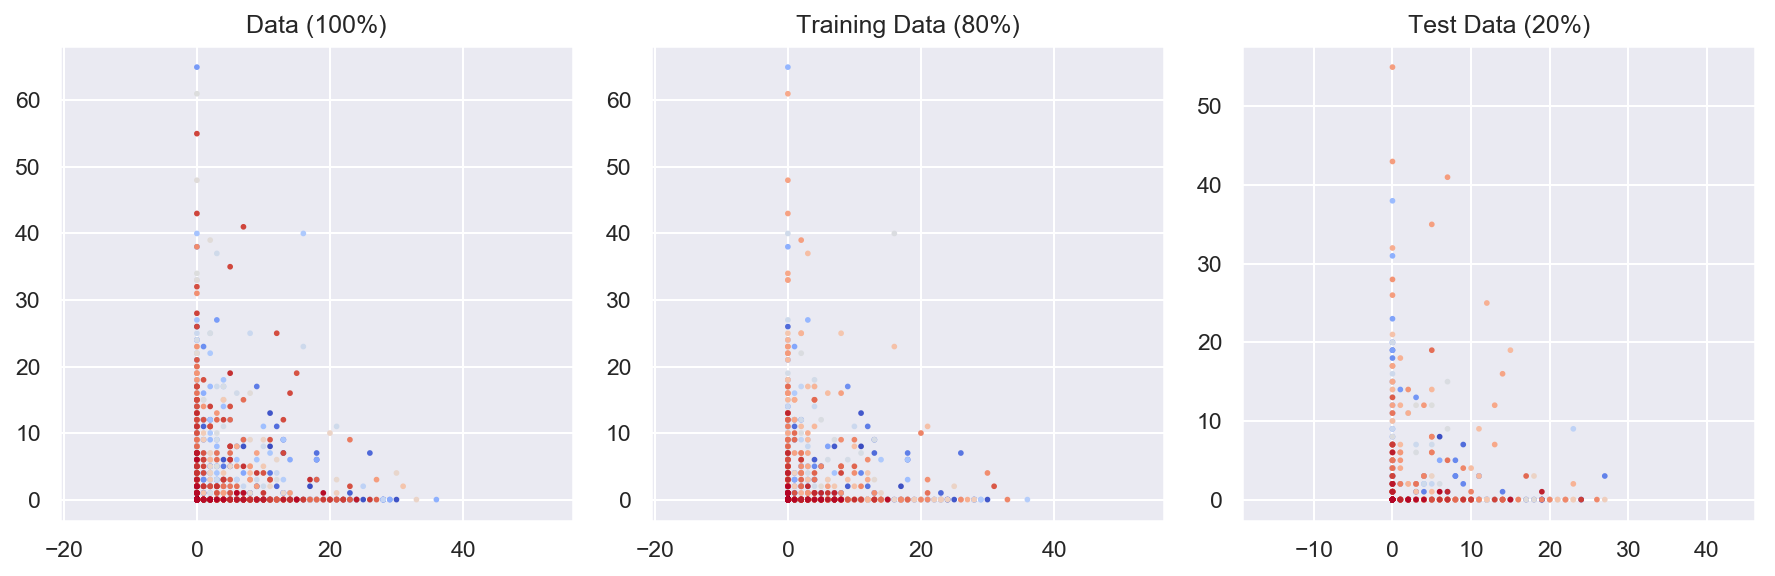

Accuracy0.8364312267657993
Precision0.8369564769458904
Recall0.8360097975869816
F1 Score0.8358008172395797


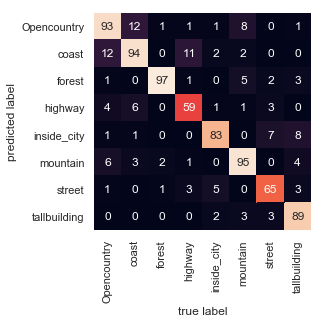

[0.79, 0.79, 0.79]
[0.78, 0.81, 0.79]
[0.89, 0.96, 0.92]
[0.8, 0.78, 0.79]
[0.83, 0.88, 0.86]
[0.86, 0.83, 0.84]
[0.83, 0.81, 0.82]
[0.92, 0.82, 0.87]
plotMat: [[0.79, 0.79, 0.79], [0.78, 0.81, 0.79], [0.89, 0.96, 0.92], [0.8, 0.78, 0.79], [0.83, 0.88, 0.86], [0.86, 0.83, 0.84], [0.83, 0.81, 0.82], [0.92, 0.82, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


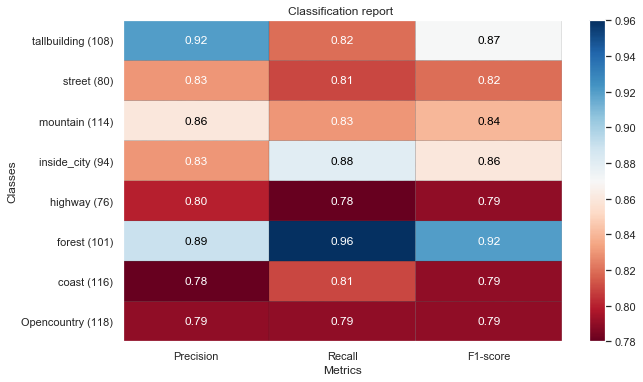

For Kernel=linear the accuracy is: 0.8364312267657993
rbf
{'C': 10, 'gamma': 1e-05}
{'mean_fit_time': array([0.56155388, 0.50037305, 0.47720822, 0.51327634, 0.56473128,
       0.43260495, 0.478894  , 0.5210487 , 0.53610794, 0.50583299,
       0.53939001, 0.55023201, 0.60808325, 0.53213541, 0.52543902,
       0.60131502, 0.58458813, 0.48396142, 0.49365465, 0.3739477 ,
       0.52641074, 0.60261234, 0.62520107, 0.49936636, 0.34360274,
       0.19973644, 0.58432062, 0.71888375, 0.58498096, 0.51315196,
       0.16717005, 0.17403372, 0.56800508, 0.70464404, 0.63024902,
       0.54656998, 0.14496835, 0.17921734, 0.57089933, 0.70139503,
       0.63431032, 0.54985158]), 'std_fit_time': array([0.01551586, 0.04677885, 0.01120566, 0.04195079, 0.0349782 ,
       0.0025033 , 0.00237368, 0.01360466, 0.02773197, 0.00336999,
       0.05769306, 0.00266739, 0.03569527, 0.04555178, 0.01241102,
       0.00581868, 0.01532842, 0.01283185, 0.00573612, 0.00399416,
       0.01196643, 0.00655778, 0.03004355, 0.

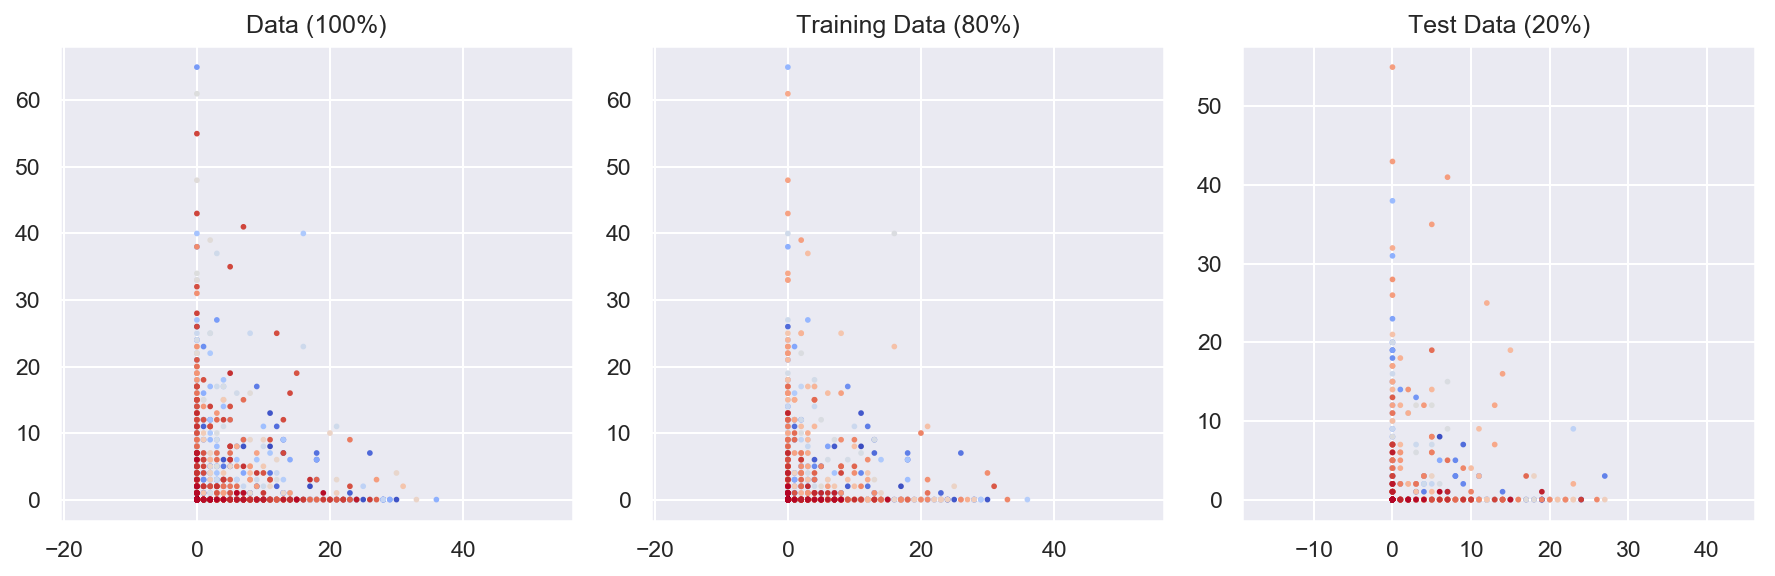

Accuracy0.8351920693928129
Precision0.8389312268361324
Recall0.8356325742418551
F1 Score0.836434588696136


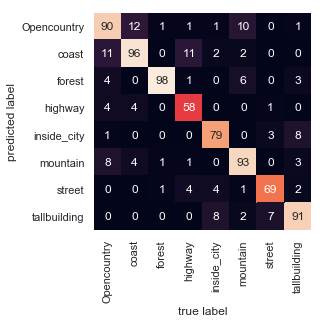

[0.78, 0.76, 0.77]
[0.79, 0.83, 0.81]
[0.88, 0.97, 0.92]
[0.87, 0.76, 0.81]
[0.87, 0.84, 0.85]
[0.85, 0.82, 0.83]
[0.85, 0.86, 0.86]
[0.84, 0.84, 0.84]
plotMat: [[0.78, 0.76, 0.77], [0.79, 0.83, 0.81], [0.88, 0.97, 0.92], [0.87, 0.76, 0.81], [0.87, 0.84, 0.85], [0.85, 0.82, 0.83], [0.85, 0.86, 0.86], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


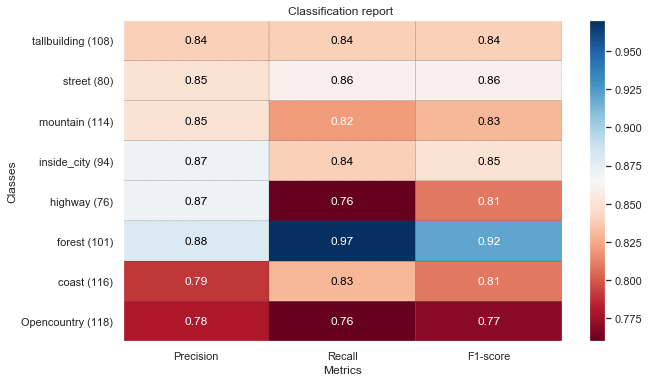

For Kernel=rbf the accuracy is: 0.8351920693928129
poly2
{'C': 10, 'gamma': 0.0001}
{'mean_fit_time': array([0.44010592, 0.43618472, 0.4339788 , 0.26585325, 0.19239871,
       0.19989077, 0.43133847, 0.43402672, 0.41422637, 0.19726539,
       0.19371335, 0.18785342, 0.42570122, 0.43736068, 0.26954842,
       0.19518097, 0.19936848, 0.20141204, 0.46103024, 0.43523502,
       0.18245228, 0.19816287, 0.20441635, 0.19347866, 0.43719562,
       0.26201757, 0.19437289, 0.19700003, 0.1972611 , 0.18821772,
       0.41466204, 0.18187324, 0.2002852 , 0.19822574, 0.20051678,
       0.19369562, 0.26531911, 0.19622358, 0.18845669, 0.20080129,
       0.20619297, 0.20021423]), 'std_fit_time': array([0.01251075, 0.00226148, 0.00530465, 0.01239256, 0.00263103,
       0.00600892, 0.00482936, 0.00055939, 0.00409321, 0.01802239,
       0.00656731, 0.00738981, 0.00424648, 0.00615051, 0.00422529,
       0.0029436 , 0.00558042, 0.00484532, 0.01355164, 0.02754345,
       0.00100915, 0.00385249, 0.01086836, 0.

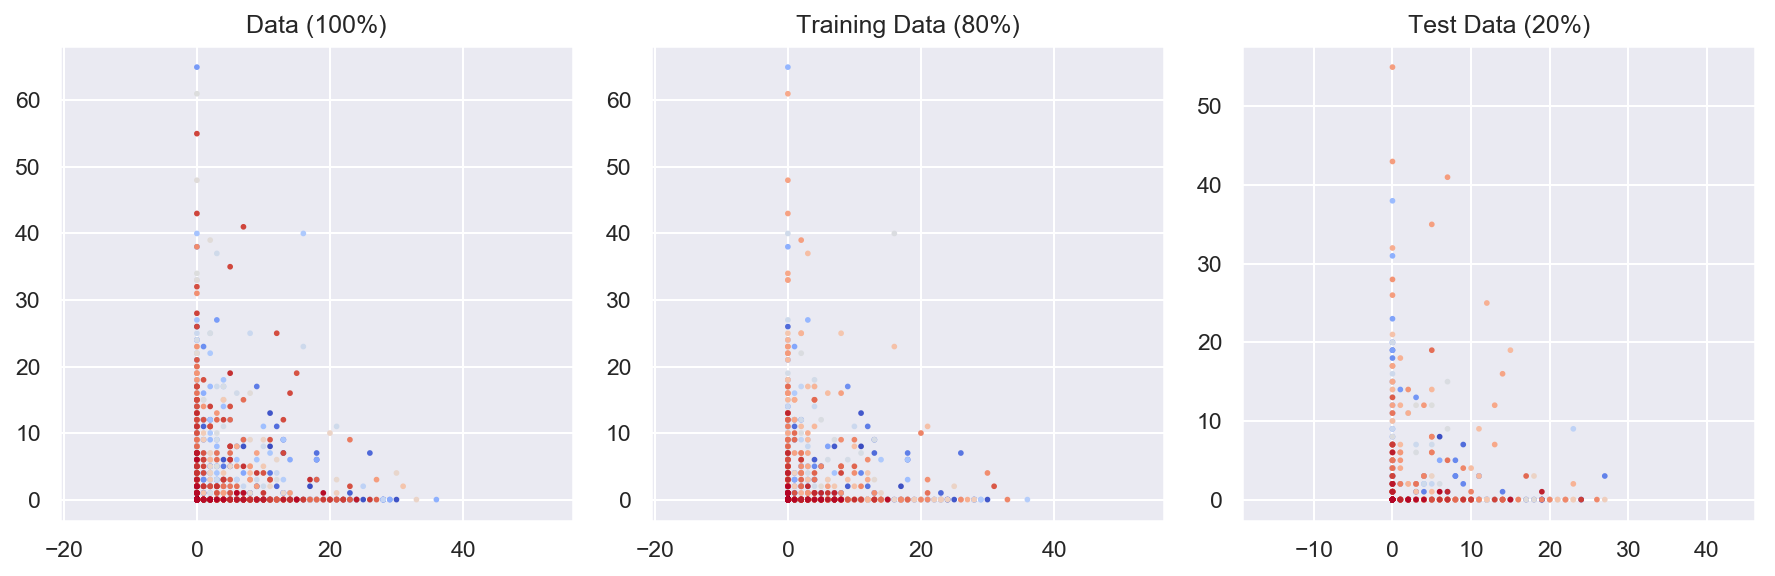

Accuracy0.838909541511772
Precision0.8393754258913395
Recall0.8413712723836249
F1 Score0.8401313637425575


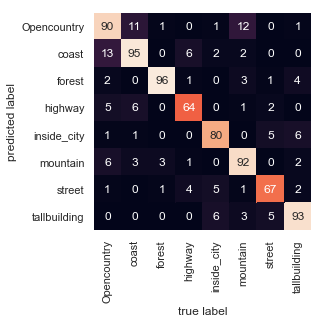

[0.78, 0.76, 0.77]
[0.81, 0.82, 0.81]
[0.9, 0.95, 0.92]
[0.82, 0.84, 0.83]
[0.86, 0.85, 0.86]
[0.86, 0.81, 0.83]
[0.83, 0.84, 0.83]
[0.87, 0.86, 0.87]
plotMat: [[0.78, 0.76, 0.77], [0.81, 0.82, 0.81], [0.9, 0.95, 0.92], [0.82, 0.84, 0.83], [0.86, 0.85, 0.86], [0.86, 0.81, 0.83], [0.83, 0.84, 0.83], [0.87, 0.86, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


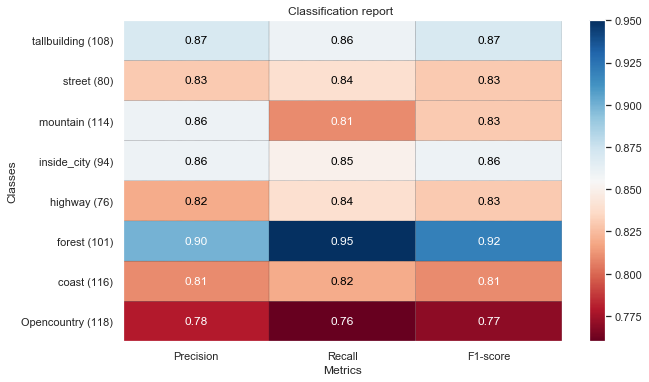

For Kernel=poly2 the accuracy is: 0.838909541511772
poly3
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.45039511, 0.43377097, 0.4337763 , 0.26853506, 0.2751441 ,
       0.26702364, 0.41845473, 0.4284722 , 0.37064497, 0.277481  ,
       0.272837  , 0.267241  , 0.43410667, 0.43741369, 0.253968  ,
       0.28100975, 0.29597068, 0.26949461, 0.43156203, 0.43490728,
       0.26483655, 0.27184653, 0.2719357 , 0.28030229, 0.43733589,
       0.37253817, 0.27664304, 0.27442765, 0.271046  , 0.27082165,
       0.42420491, 0.27176865, 0.28902904, 0.27682463, 0.2780079 ,
       0.31213037, 0.42665648, 0.26771728, 0.26889221, 0.27792676,
       0.27510571, 0.60544674]), 'std_fit_time': array([0.01884212, 0.00404311, 0.0067219 , 0.012956  , 0.00864682,
       0.00923327, 0.01314403, 0.0046523 , 0.00896051, 0.01141624,
       0.00869646, 0.01242325, 0.00300935, 0.01337527, 0.00341684,
       0.02644457, 0.00770044, 0.00985382, 0.01624293, 0.00095406,
       0.01426741, 0.0189399 , 0.02222799,

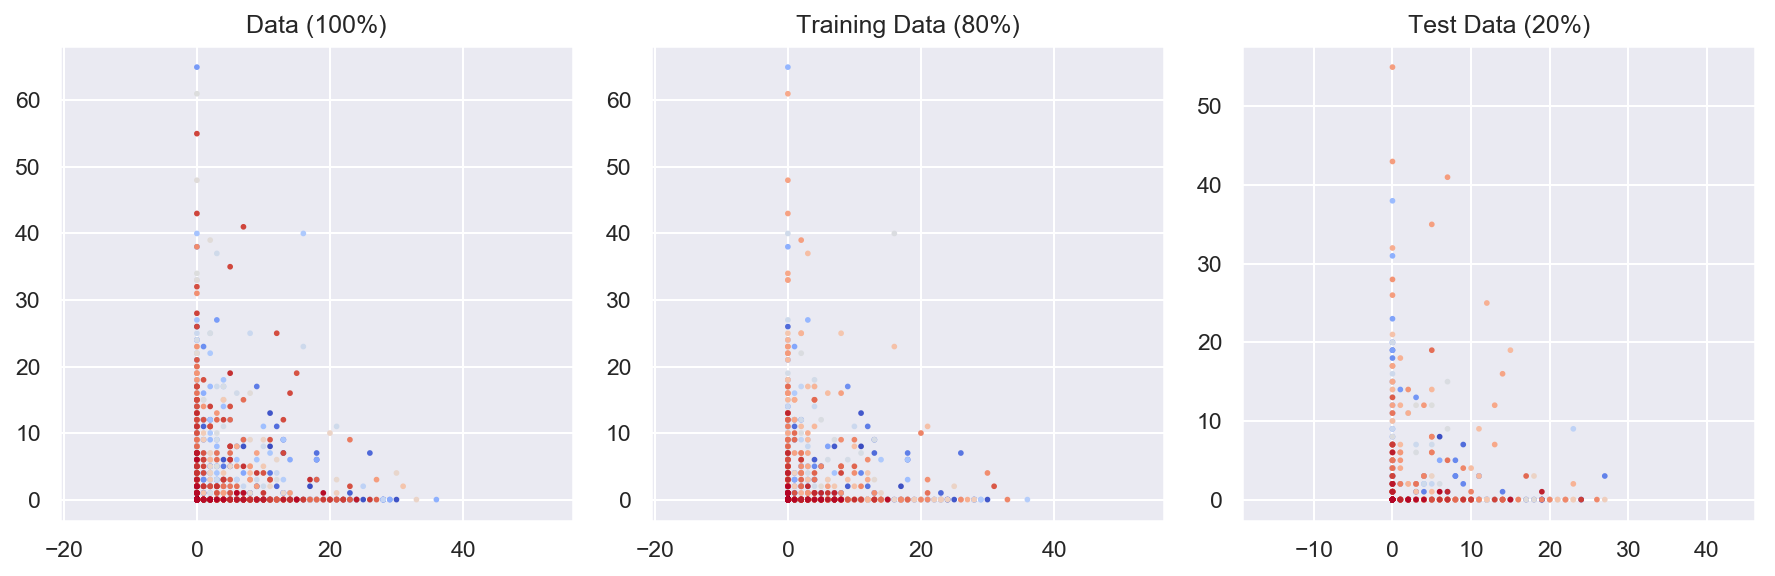

Accuracy0.8413878562577447
Precision0.8441850473062413
Recall0.8471988674567503
F1 Score0.8451200002238985


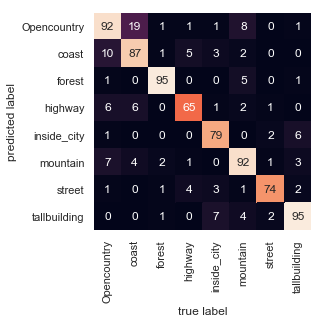

[0.75, 0.78, 0.76]
[0.81, 0.75, 0.78]
[0.93, 0.94, 0.94]
[0.8, 0.86, 0.83]
[0.9, 0.84, 0.87]
[0.84, 0.81, 0.82]
[0.86, 0.93, 0.89]
[0.87, 0.88, 0.88]
plotMat: [[0.75, 0.78, 0.76], [0.81, 0.75, 0.78], [0.93, 0.94, 0.94], [0.8, 0.86, 0.83], [0.9, 0.84, 0.87], [0.84, 0.81, 0.82], [0.86, 0.93, 0.89], [0.87, 0.88, 0.88]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


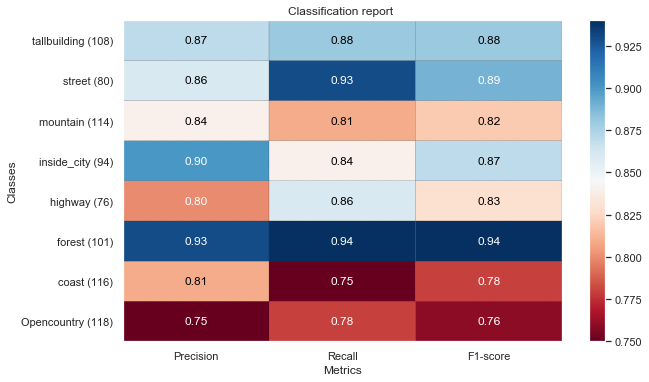

For Kernel=poly3 the accuracy is: 0.8413878562577447
poly4
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.46558166, 0.44375602, 0.41874003, 0.35321005, 0.3543601 ,
       0.35595131, 0.41106304, 0.42682775, 0.31340265, 0.35406534,
       0.34640408, 0.35373966, 0.41545606, 0.41749136, 0.32864698,
       0.35537155, 0.34604295, 0.35770003, 0.40203476, 0.41961106,
       0.35158952, 0.35812426, 0.34232028, 0.35101334, 0.42248106,
       0.41384538, 0.36844738, 0.38923295, 0.36128799, 0.3516221 ,
       0.43094897, 0.3334674 , 0.35050241, 0.34184758, 0.36719696,
       0.34789395, 0.42210269, 0.30491765, 0.35027305, 0.35487   ,
       0.40553721, 0.34912721]), 'std_fit_time': array([0.00987853, 0.0043004 , 0.01122507, 0.00730924, 0.00974975,
       0.01146604, 0.00620685, 0.00223906, 0.00483656, 0.00170734,
       0.01788619, 0.00883763, 0.01274236, 0.00894404, 0.0056505 ,
       0.00441358, 0.00719053, 0.00428672, 0.0115097 , 0.008023  ,
       0.00978539, 0.01117685, 0.00925323

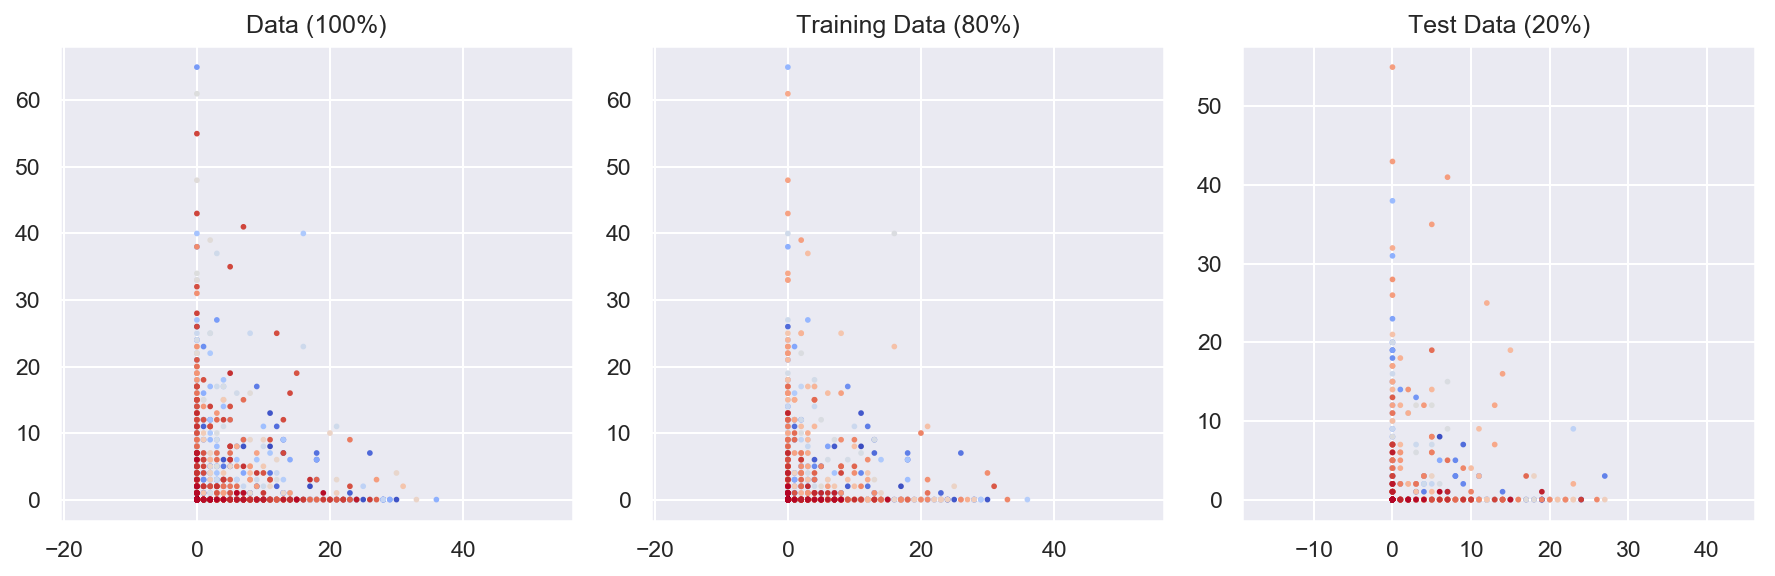

Accuracy0.8265179677819083
Precision0.8290696659470286
Recall0.831905095890974
F1 Score0.8294019131238568


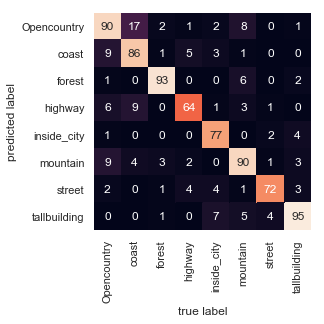

[0.74, 0.76, 0.75]
[0.82, 0.74, 0.78]
[0.91, 0.92, 0.92]
[0.76, 0.84, 0.8]
[0.92, 0.82, 0.87]
[0.8, 0.79, 0.8]
[0.83, 0.9, 0.86]
[0.85, 0.88, 0.86]
plotMat: [[0.74, 0.76, 0.75], [0.82, 0.74, 0.78], [0.91, 0.92, 0.92], [0.76, 0.84, 0.8], [0.92, 0.82, 0.87], [0.8, 0.79, 0.8], [0.83, 0.9, 0.86], [0.85, 0.88, 0.86]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


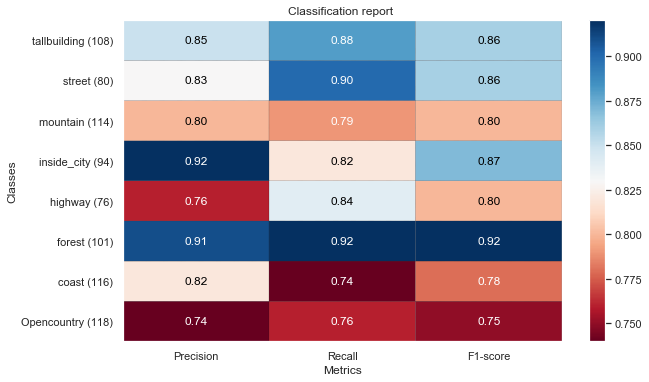

For Kernel=poly4 the accuracy is: 0.8265179677819083
poly5


/Users/daniel/.conda/envs/wavelets/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.01, 'gamma': 0.001}
{'mean_fit_time': array([0.49386366, 0.5430003 , 0.41712189, 0.4298687 , 0.45068065,
       0.50412194, 0.49070096, 0.44424319, 0.36157751, 0.44253214,
       0.43445071, 0.42504501, 0.4494772 , 0.44265636, 0.41601276,
       0.41631603, 0.42160694, 0.41145905, 0.44141507, 0.45508711,
       0.42015775, 0.41376623, 0.41468136, 0.41858967, 0.44159961,
       0.43589799, 0.41331935, 0.41122675, 0.42496411, 0.45347762,
       0.44933224, 0.39850958, 0.40857061, 0.42839877, 0.43838628,
       0.44012189, 0.4609623 , 0.37020461, 0.4449927 , 0.44038272,
       0.43433173, 0.42341828]), 'std_fit_time': array([0.02056173, 0.00553854, 0.02061802, 0.01551767, 0.01617461,
       0.05070167, 0.03703942, 0.01100235, 0.02811413, 0.01558244,
       0.01192819, 0.0232949 , 0.00131465, 0.0045734 , 0.00714673,
       0.00463551, 0.01172096, 0.00282992, 0.00640577, 0.00667641,
       0.00627213, 0.00987224, 0.01551594, 0.01602273, 0.00562261,
       0.01155248, 0.00864304, 0.0

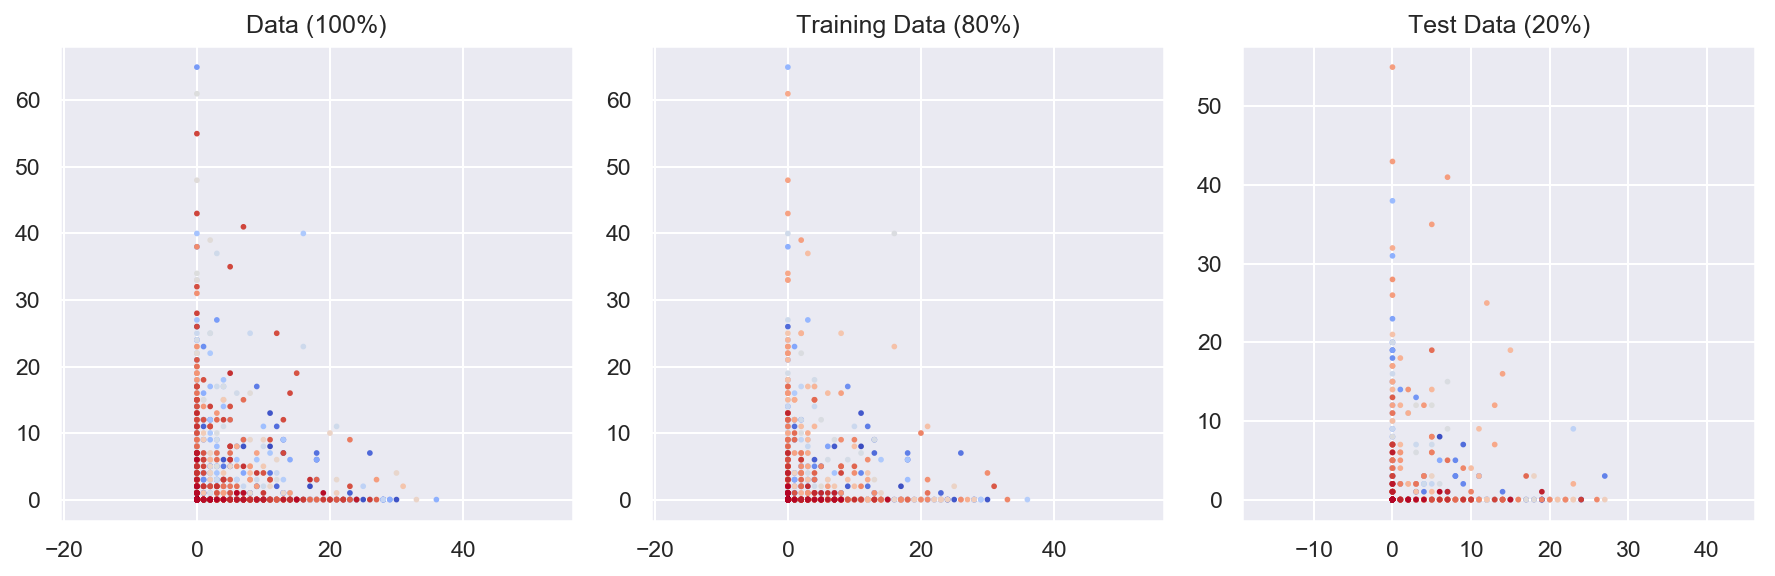

Accuracy0.80545229244114
Precision0.8096642935749956
Recall0.8137073979728587
F1 Score0.8077010059841043


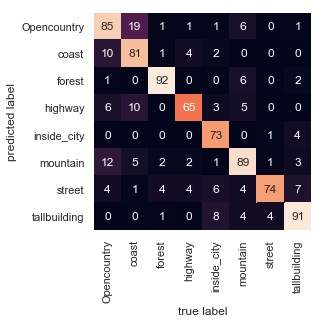

[0.75, 0.72, 0.73]
[0.83, 0.7, 0.76]
[0.91, 0.91, 0.91]
[0.73, 0.86, 0.79]
[0.94, 0.78, 0.85]
[0.77, 0.78, 0.78]
[0.71, 0.93, 0.8]
[0.84, 0.84, 0.84]
plotMat: [[0.75, 0.72, 0.73], [0.83, 0.7, 0.76], [0.91, 0.91, 0.91], [0.73, 0.86, 0.79], [0.94, 0.78, 0.85], [0.77, 0.78, 0.78], [0.71, 0.93, 0.8], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


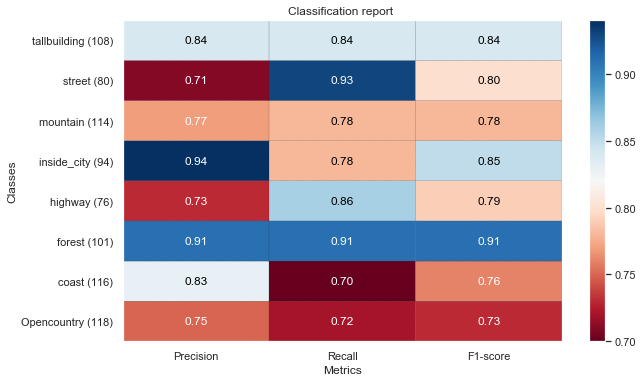

For Kernel=poly5 the accuracy is: 0.80545229244114
sigmoid


/Users/daniel/.conda/envs/wavelets/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 100, 'gamma': 1e-05}
{'mean_fit_time': array([0.45435103, 0.45886978, 0.47773425, 0.51447701, 0.42938352,
       0.41696397, 0.43468928, 0.46111504, 0.48370719, 0.52858035,
       0.4341677 , 0.42084964, 0.45100037, 0.4685754 , 0.48704203,
       0.51888688, 0.43308179, 0.41750503, 0.45523429, 0.35379704,
       0.27562865, 0.5183897 , 0.46455367, 0.42875497, 0.38385431,
       0.20181894, 0.15671555, 0.45810938, 0.41994874, 0.40586972,
       0.17094843, 0.1318047 , 0.10838739, 0.30616736, 0.42134635,
       0.40315398, 0.13153537, 0.13441571, 0.11011879, 0.19400803,
       0.39523697, 0.40863546]), 'std_fit_time': array([0.02276378, 0.00559579, 0.00285571, 0.00766692, 0.00378505,
       0.0029618 , 0.00372772, 0.00479182, 0.00960558, 0.00534044,
       0.00707248, 0.00614569, 0.00667244, 0.01130341, 0.00750119,
       0.00479324, 0.00450577, 0.00055213, 0.00824676, 0.00159582,
       0.00286049, 0.01543433, 0.01539496, 0.01487983, 0.00829963,
       0.01461644, 0.00261565, 0.00

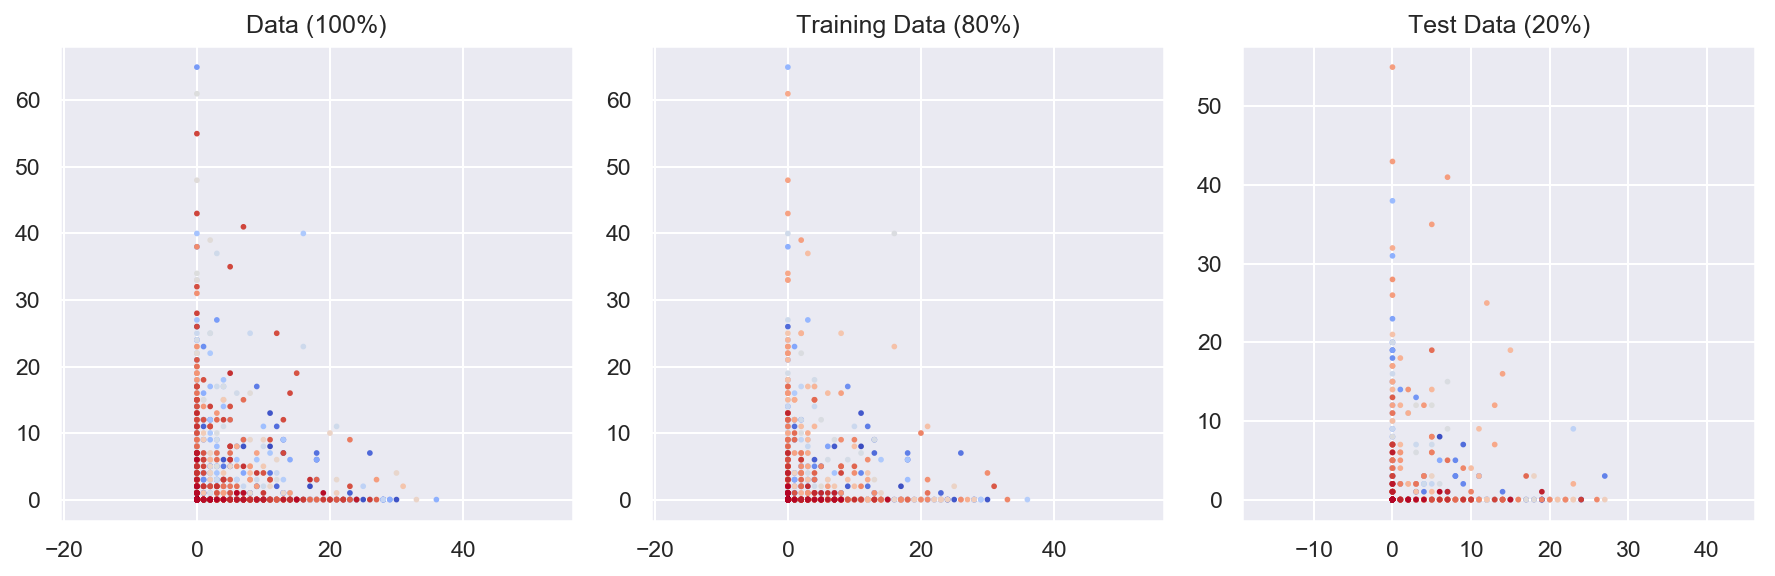

Accuracy0.8364312267657993
Precision0.8369592356315448
Recall0.8360097975869816
F1 Score0.8358048284210189


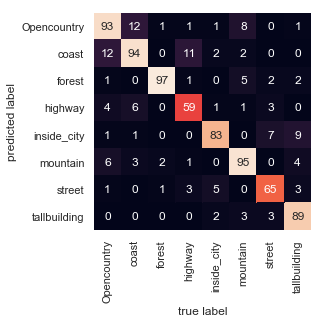

[0.79, 0.79, 0.79]
[0.78, 0.81, 0.79]
[0.9, 0.96, 0.93]
[0.8, 0.78, 0.79]
[0.82, 0.88, 0.85]
[0.86, 0.83, 0.84]
[0.83, 0.81, 0.82]
[0.92, 0.82, 0.87]
plotMat: [[0.79, 0.79, 0.79], [0.78, 0.81, 0.79], [0.9, 0.96, 0.93], [0.8, 0.78, 0.79], [0.82, 0.88, 0.85], [0.86, 0.83, 0.84], [0.83, 0.81, 0.82], [0.92, 0.82, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


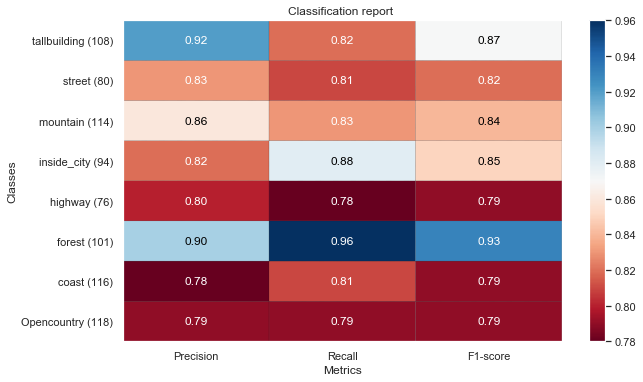

For Kernel=sigmoid the accuracy is: 0.8364312267657993


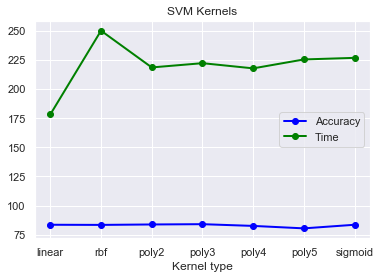

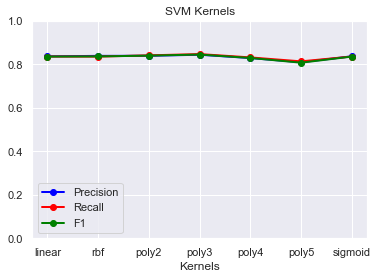

[0.8369564769458904, 0.8360097975869816, 0.8358008172395797]
[0.8389312268361324, 0.8356325742418551, 0.836434588696136]
[0.8393754258913395, 0.8413712723836249, 0.8401313637425575]
[0.8441850473062413, 0.8471988674567503, 0.8451200002238985]
[0.8290696659470286, 0.831905095890974, 0.8294019131238568]
[0.8096642935749956, 0.8137073979728587, 0.8077010059841043]
[0.8369592356315448, 0.8360097975869816, 0.8358048284210189]
plotMat: [[0.8369564769458904, 0.8360097975869816, 0.8358008172395797], [0.8389312268361324, 0.8356325742418551, 0.836434588696136], [0.8393754258913395, 0.8413712723836249, 0.8401313637425575], [0.8441850473062413, 0.8471988674567503, 0.8451200002238985], [0.8290696659470286, 0.831905095890974, 0.8294019131238568], [0.8096642935749956, 0.8137073979728587, 0.8077010059841043], [0.8369592356315448, 0.8360097975869816, 0.8358048284210189]]
support: ["{'C':0.001,'gamma':1e-05}", "{'C':10,'gamma':1e-05}", "{'C':10,'gamma':0.0001}", "{'C':0.0001,'gamma':0.01}", "{'C':0.0001

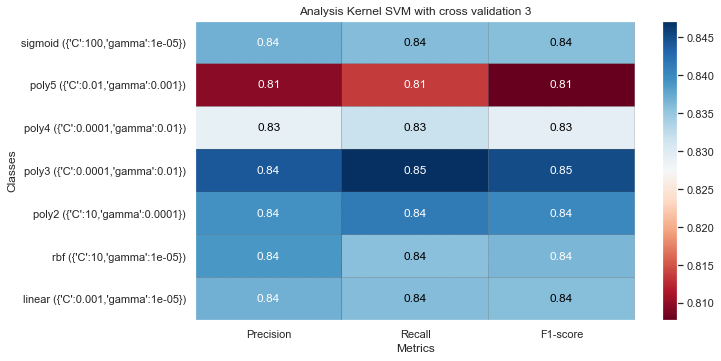

5
linear
{'C': 0.001, 'gamma': 1e-05}
{'mean_fit_time': array([0.25008211, 0.21443701, 0.21422997, 0.20982871, 0.21765523,
       0.21211801, 0.1644352 , 0.16728139, 0.16338954, 0.16217632,
       0.16396785, 0.16322289, 0.19145064, 0.19000659, 0.19086647,
       0.19176478, 0.19444232, 0.19613142, 0.24797711, 0.24490309,
       0.24264421, 0.24282408, 0.24816856, 0.24795423, 0.33697915,
       0.33140559, 0.33493505, 0.33677521, 0.3298255 , 0.34043884,
       0.33101659, 0.33642321, 0.32807441, 0.33443346, 0.32889748,
       0.33044825, 0.33686037, 0.33450632, 0.33337088, 0.33238187,
       0.3302731 , 0.33510151]), 'std_fit_time': array([0.03088171, 0.00439751, 0.00527665, 0.00213166, 0.01317651,
       0.00605347, 0.00940256, 0.0042904 , 0.00885835, 0.0066612 ,
       0.00334235, 0.00299259, 0.01198299, 0.01051604, 0.01038556,
       0.00922378, 0.00986102, 0.00613226, 0.02419752, 0.02396871,
       0.02081968, 0.0228237 , 0.02450636, 0.01639512, 0.10585815,
       0.08885907, 0.100

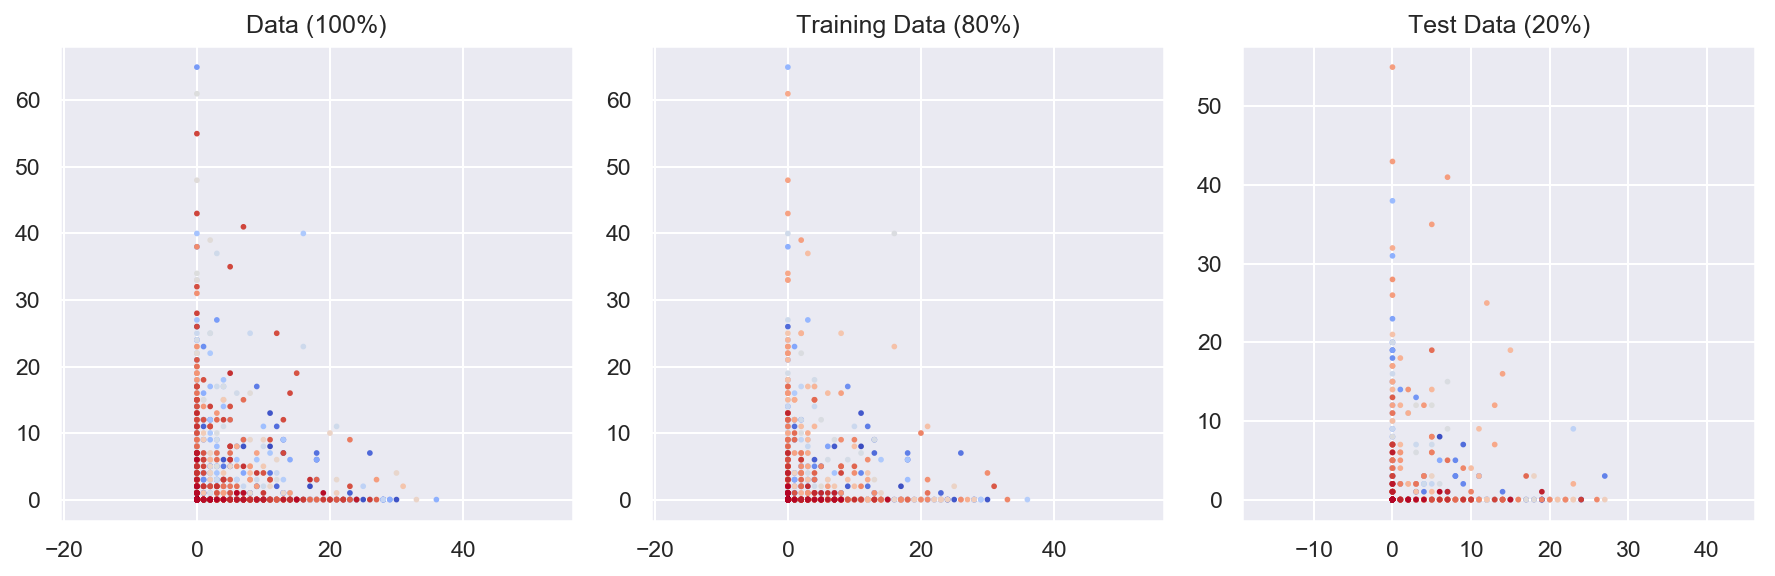

Accuracy0.8364312267657993
Precision0.8369564769458904
Recall0.8360097975869816
F1 Score0.8358008172395797


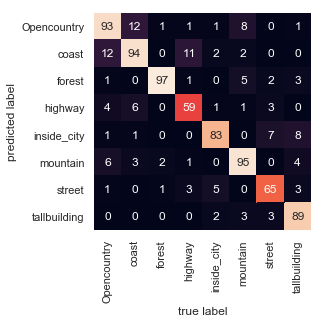

[0.79, 0.79, 0.79]
[0.78, 0.81, 0.79]
[0.89, 0.96, 0.92]
[0.8, 0.78, 0.79]
[0.83, 0.88, 0.86]
[0.86, 0.83, 0.84]
[0.83, 0.81, 0.82]
[0.92, 0.82, 0.87]
plotMat: [[0.79, 0.79, 0.79], [0.78, 0.81, 0.79], [0.89, 0.96, 0.92], [0.8, 0.78, 0.79], [0.83, 0.88, 0.86], [0.86, 0.83, 0.84], [0.83, 0.81, 0.82], [0.92, 0.82, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


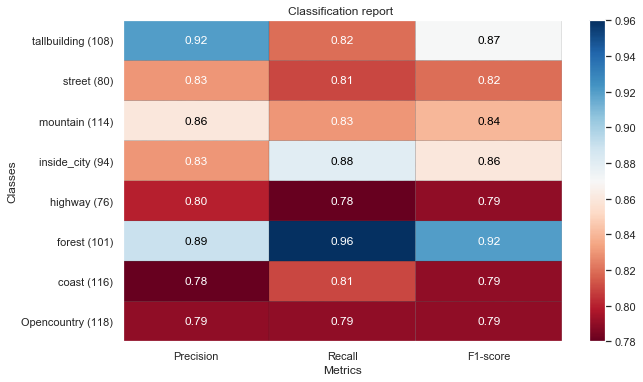

For Kernel=linear the accuracy is: 0.8364312267657993
rbf
{'C': 10, 'gamma': 1e-05}
{'mean_fit_time': array([0.67749181, 0.67300639, 0.66366653, 0.70214052, 0.69498634,
       0.59897842, 0.67147484, 0.66521425, 0.6793705 , 0.70634604,
       0.7612227 , 0.65855374, 0.66660295, 0.68376102, 0.70659075,
       0.79629169, 0.77137938, 0.66383491, 0.6645494 , 0.48892336,
       0.76083202, 0.84702916, 0.79154224, 0.6806747 , 0.39720201,
       0.24794188, 0.76806555, 0.89739928, 0.80617256, 0.68497605,
       0.21031933, 0.21365733, 0.77458377, 0.96173186, 0.85857162,
       0.75469341, 0.18702431, 0.22043462, 0.77546043, 0.96059837,
       0.86931443, 0.74407506]), 'std_fit_time': array([0.01996668, 0.01676779, 0.00807069, 0.00741479, 0.01550736,
       0.02089136, 0.01149156, 0.01279279, 0.00587296, 0.00591243,
       0.01398193, 0.01358881, 0.01434698, 0.00784074, 0.01336194,
       0.0097896 , 0.00800157, 0.00553798, 0.00666882, 0.01431647,
       0.03434519, 0.02394553, 0.01629526, 0.

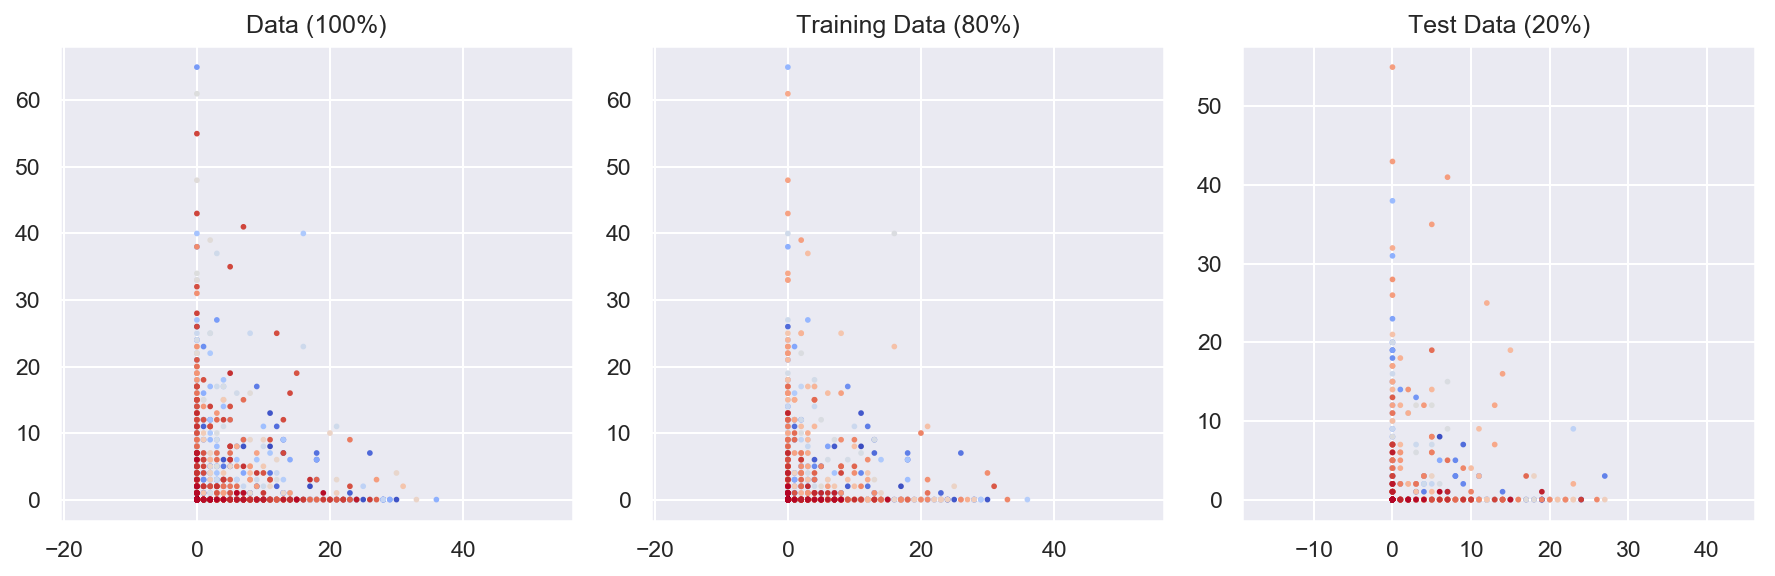

Accuracy0.8351920693928129
Precision0.8389312268361324
Recall0.8356325742418551
F1 Score0.836434588696136


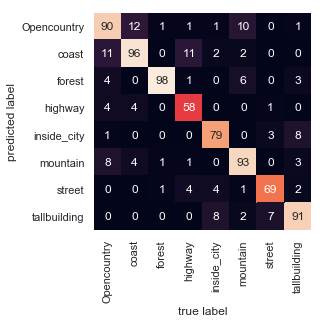

[0.78, 0.76, 0.77]
[0.79, 0.83, 0.81]
[0.88, 0.97, 0.92]
[0.87, 0.76, 0.81]
[0.87, 0.84, 0.85]
[0.85, 0.82, 0.83]
[0.85, 0.86, 0.86]
[0.84, 0.84, 0.84]
plotMat: [[0.78, 0.76, 0.77], [0.79, 0.83, 0.81], [0.88, 0.97, 0.92], [0.87, 0.76, 0.81], [0.87, 0.84, 0.85], [0.85, 0.82, 0.83], [0.85, 0.86, 0.86], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


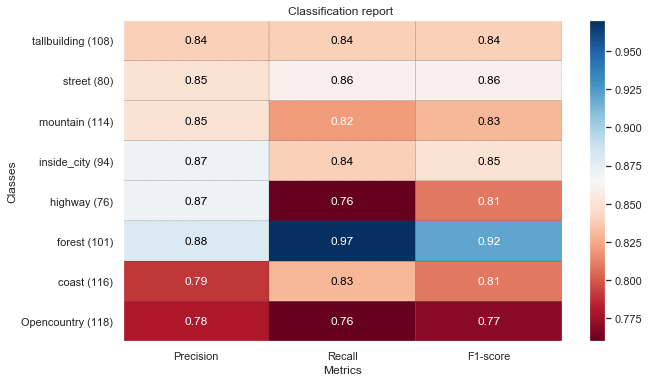

For Kernel=rbf the accuracy is: 0.8351920693928129
poly2
{'C': 0.001, 'gamma': 0.01}
{'mean_fit_time': array([0.60238013, 0.58453355, 0.58218117, 0.33416405, 0.25443029,
       0.24493661, 0.58244481, 0.59566092, 0.55823193, 0.23594017,
       0.24251623, 0.2464498 , 0.58893027, 0.59725504, 0.33792677,
       0.24669232, 0.24695525, 0.25666175, 0.58934255, 0.58465266,
       0.25785012, 0.26556072, 0.25895166, 0.26389856, 0.6011991 ,
       0.34038224, 0.24371643, 0.25027008, 0.24560757, 0.24900661,
       0.57313685, 0.2317534 , 0.25341339, 0.24942384, 0.24867625,
       0.25109482, 0.34512835, 0.25355239, 0.24221997, 0.25223641,
       0.24231062, 0.24535275]), 'std_fit_time': array([0.02545949, 0.00839864, 0.00700876, 0.00264971, 0.00703464,
       0.0159982 , 0.00587755, 0.01360683, 0.01655838, 0.00973233,
       0.00861954, 0.01008368, 0.01010572, 0.00606696, 0.00709493,
       0.00959955, 0.00771168, 0.01225082, 0.01003326, 0.00490714,
       0.01119565, 0.02079866, 0.01559335, 0

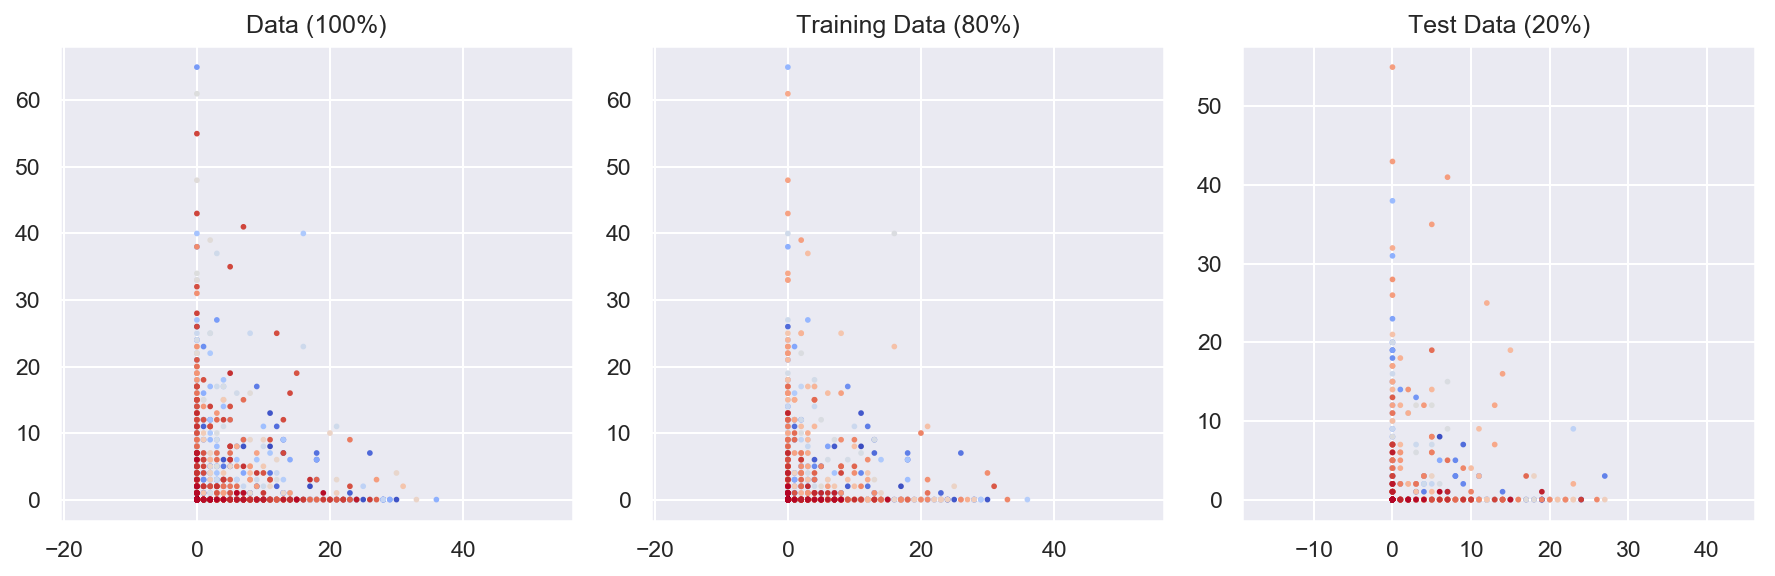

Accuracy0.838909541511772
Precision0.8393754258913395
Recall0.8413712723836249
F1 Score0.8401313637425575


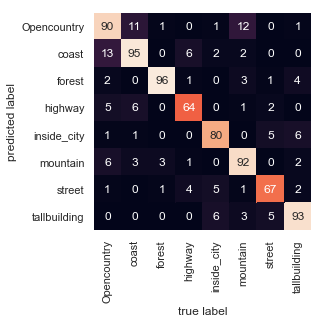

[0.78, 0.76, 0.77]
[0.81, 0.82, 0.81]
[0.9, 0.95, 0.92]
[0.82, 0.84, 0.83]
[0.86, 0.85, 0.86]
[0.86, 0.81, 0.83]
[0.83, 0.84, 0.83]
[0.87, 0.86, 0.87]
plotMat: [[0.78, 0.76, 0.77], [0.81, 0.82, 0.81], [0.9, 0.95, 0.92], [0.82, 0.84, 0.83], [0.86, 0.85, 0.86], [0.86, 0.81, 0.83], [0.83, 0.84, 0.83], [0.87, 0.86, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


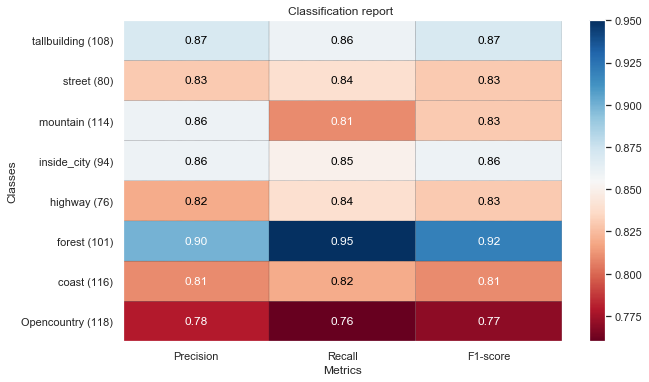

For Kernel=poly2 the accuracy is: 0.838909541511772
poly3
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.5894558 , 0.58135815, 0.59257665, 0.32755046, 0.33742819,
       0.33999162, 0.58983793, 0.60487742, 0.51155105, 0.34866042,
       0.34465561, 0.34043498, 0.58514047, 0.5966454 , 0.32812414,
       0.33620682, 0.33200855, 0.33918009, 0.58066006, 0.58270183,
       0.32659502, 0.3346025 , 0.33291359, 0.34033356, 0.59472098,
       0.48887033, 0.33776522, 0.3375423 , 0.33199811, 0.33798995,
       0.59591608, 0.32880955, 0.34176822, 0.33360386, 0.33363552,
       0.38029442, 0.58174362, 0.32820115, 0.33431282, 0.33153024,
       0.33885045, 0.77786727]), 'std_fit_time': array([0.0143933 , 0.00879009, 0.01859   , 0.00992184, 0.01784048,
       0.01097905, 0.01505857, 0.02461864, 0.00314802, 0.01418746,
       0.0223456 , 0.01319275, 0.00781885, 0.0039296 , 0.00717011,
       0.02038354, 0.01303403, 0.01739505, 0.0059712 , 0.00643201,
       0.01089615, 0.01578932, 0.01209484,

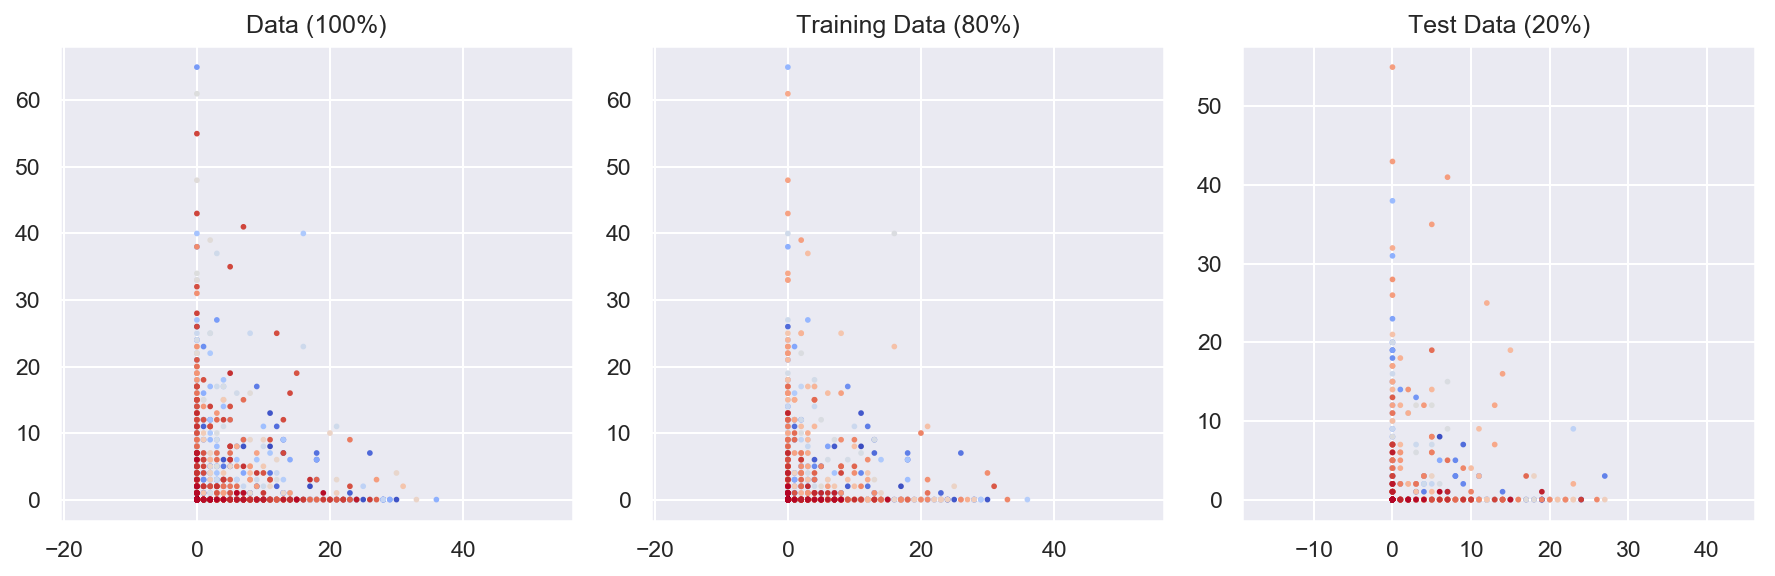

Accuracy0.8413878562577447
Precision0.8441850473062413
Recall0.8471988674567503
F1 Score0.8451200002238985


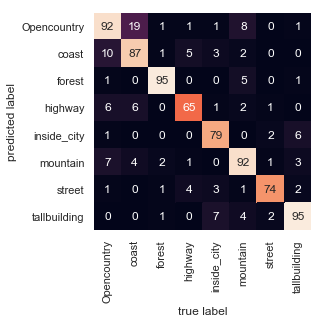

[0.75, 0.78, 0.76]
[0.81, 0.75, 0.78]
[0.93, 0.94, 0.94]
[0.8, 0.86, 0.83]
[0.9, 0.84, 0.87]
[0.84, 0.81, 0.82]
[0.86, 0.93, 0.89]
[0.87, 0.88, 0.88]
plotMat: [[0.75, 0.78, 0.76], [0.81, 0.75, 0.78], [0.93, 0.94, 0.94], [0.8, 0.86, 0.83], [0.9, 0.84, 0.87], [0.84, 0.81, 0.82], [0.86, 0.93, 0.89], [0.87, 0.88, 0.88]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


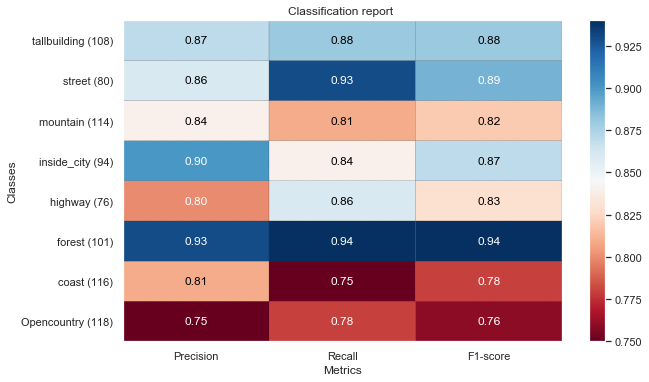

For Kernel=poly3 the accuracy is: 0.8413878562577447
poly4
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.5637362 , 0.54987345, 0.51002393, 0.42239561, 0.42348828,
       0.41568718, 0.5417727 , 0.55286798, 0.41421638, 0.43151374,
       0.42745204, 0.42330537, 0.55201068, 0.55426879, 0.3871099 ,
       0.41700706, 0.42103858, 0.42663522, 0.55231161, 0.55285621,
       0.41728244, 0.41954556, 0.41942062, 0.420154  , 0.54452682,
       0.51103902, 0.42867594, 0.41269059, 0.42318859, 0.42626348,
       0.54428263, 0.41585946, 0.44503832, 0.48968177, 0.51507525,
       0.47994795, 0.66469121, 0.41343322, 0.4186192 , 0.41475549,
       0.48818059, 0.42002344]), 'std_fit_time': array([0.00840973, 0.00566477, 0.00652632, 0.01073873, 0.01166084,
       0.01110091, 0.00832324, 0.01214372, 0.01111275, 0.01495202,
       0.01554147, 0.00570911, 0.00546278, 0.00552297, 0.01643574,
       0.00894349, 0.00730428, 0.01508822, 0.00666084, 0.0104769 ,
       0.01089232, 0.01059859, 0.01180492

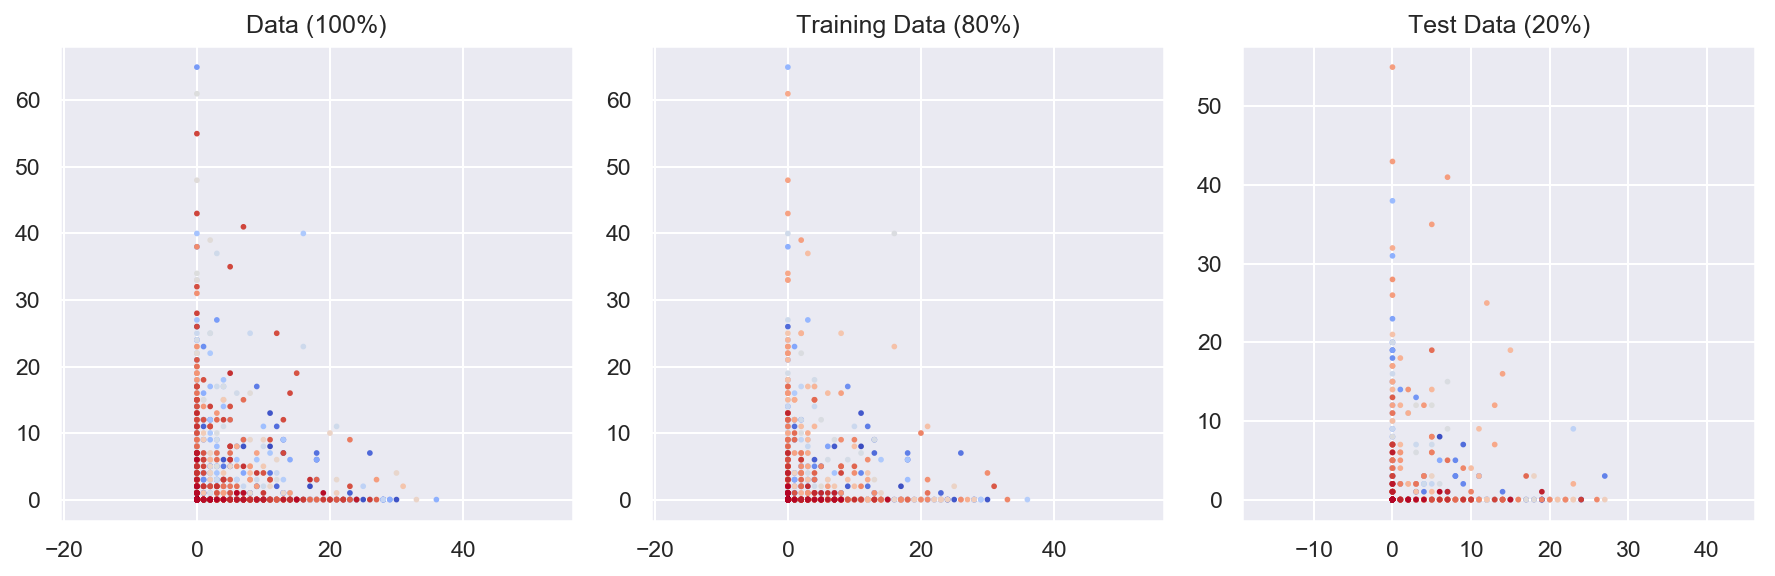

Accuracy0.8265179677819083
Precision0.8290696659470286
Recall0.831905095890974
F1 Score0.8294019131238568


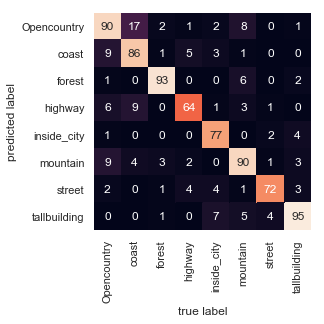

[0.74, 0.76, 0.75]
[0.82, 0.74, 0.78]
[0.91, 0.92, 0.92]
[0.76, 0.84, 0.8]
[0.92, 0.82, 0.87]
[0.8, 0.79, 0.8]
[0.83, 0.9, 0.86]
[0.85, 0.88, 0.86]
plotMat: [[0.74, 0.76, 0.75], [0.82, 0.74, 0.78], [0.91, 0.92, 0.92], [0.76, 0.84, 0.8], [0.92, 0.82, 0.87], [0.8, 0.79, 0.8], [0.83, 0.9, 0.86], [0.85, 0.88, 0.86]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


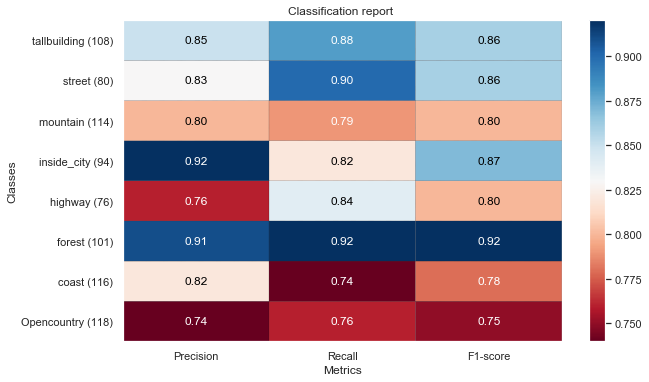

For Kernel=poly4 the accuracy is: 0.8265179677819083
poly5
{'C': 0.01, 'gamma': 0.001}
{'mean_fit_time': array([0.55507398, 0.56122251, 0.48680639, 0.51029663, 0.50728512,
       0.50332541, 0.54534683, 0.54153256, 0.41322851, 0.50062819,
       0.51010842, 0.4980947 , 0.5482512 , 0.54891458, 0.50082579,
       0.50354061, 0.50048485, 0.50709629, 0.53907738, 0.55458426,
       0.5075047 , 0.51047077, 0.50980215, 0.50333281, 0.54704127,
       0.53599119, 0.50441327, 0.50512757, 0.5125854 , 0.50093155,
       0.55006504, 0.47904162, 0.50091619, 0.5108397 , 0.50868597,
       0.50266581, 0.54391904, 0.41616344, 0.51075802, 0.50037599,
       0.50965147, 0.509446  ]), 'std_fit_time': array([0.01274328, 0.01414031, 0.01248073, 0.01647217, 0.01368864,
       0.00494006, 0.00664273, 0.00598103, 0.00933394, 0.00828011,
       0.01056157, 0.01260341, 0.00971065, 0.00570065, 0.01058537,
       0.00816385, 0.01236526, 0.01530922, 0.00943171, 0.00786196,
       0.00982107, 0.00868319, 0.02111143,

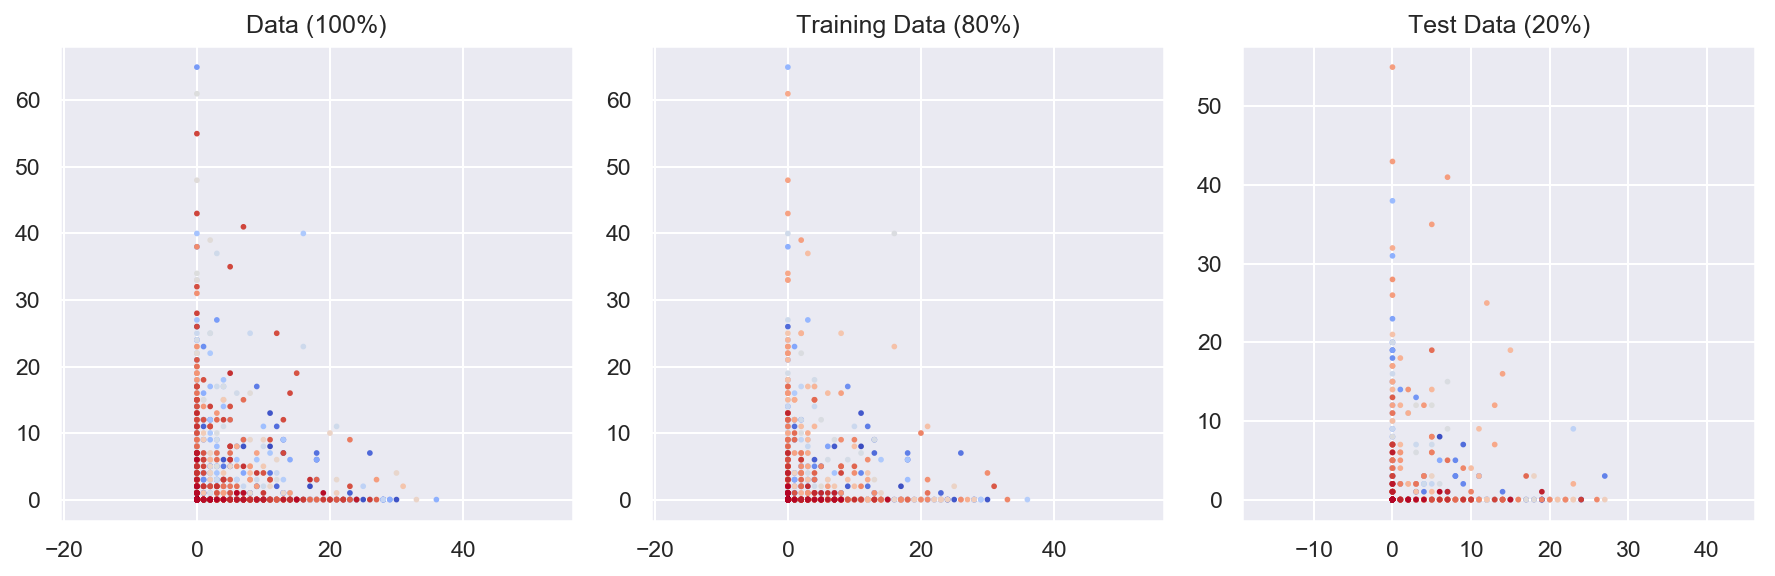

Accuracy0.80545229244114
Precision0.8096642935749956
Recall0.8137073979728587
F1 Score0.8077010059841043


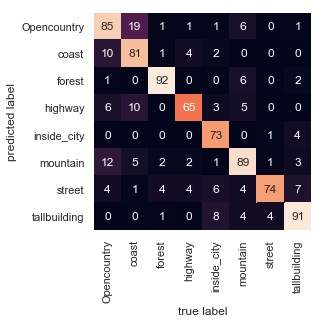

[0.75, 0.72, 0.73]
[0.83, 0.7, 0.76]
[0.91, 0.91, 0.91]
[0.73, 0.86, 0.79]
[0.94, 0.78, 0.85]
[0.77, 0.78, 0.78]
[0.71, 0.93, 0.8]
[0.84, 0.84, 0.84]
plotMat: [[0.75, 0.72, 0.73], [0.83, 0.7, 0.76], [0.91, 0.91, 0.91], [0.73, 0.86, 0.79], [0.94, 0.78, 0.85], [0.77, 0.78, 0.78], [0.71, 0.93, 0.8], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


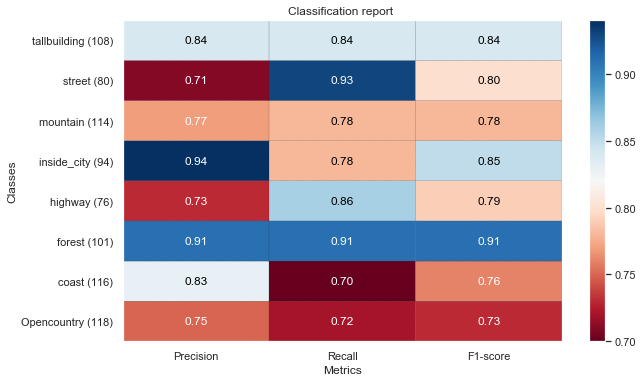

For Kernel=poly5 the accuracy is: 0.80545229244114
sigmoid
{'C': 100, 'gamma': 1e-05}
{'mean_fit_time': array([0.57982283, 0.60994196, 0.63702669, 0.6714128 , 0.56354904,
       0.54838285, 0.57919388, 0.60739179, 0.63610177, 0.68938661,
       0.57679873, 0.55823221, 0.5848526 , 0.61001329, 0.62701912,
       0.68956213, 0.57498732, 0.54315615, 0.58987517, 0.44709721,
       0.34406819, 0.66504488, 0.56505837, 0.54168754, 0.43705287,
       0.22052727, 0.19574008, 0.58578668, 0.56045117, 0.54456124,
       0.2100678 , 0.15970798, 0.14651537, 0.37617283, 0.54436111,
       0.53751163, 0.16676207, 0.16055031, 0.14230442, 0.2596981 ,
       0.53034368, 0.54102397]), 'std_fit_time': array([0.0135569 , 0.00878263, 0.00529449, 0.00910115, 0.0061035 ,
       0.00776582, 0.00842216, 0.00510586, 0.01454146, 0.01316207,
       0.01765511, 0.00972021, 0.00955671, 0.01075945, 0.00660316,
       0.01384899, 0.01201276, 0.01180666, 0.01097508, 0.00577634,
       0.00583183, 0.01202329, 0.01309229, 

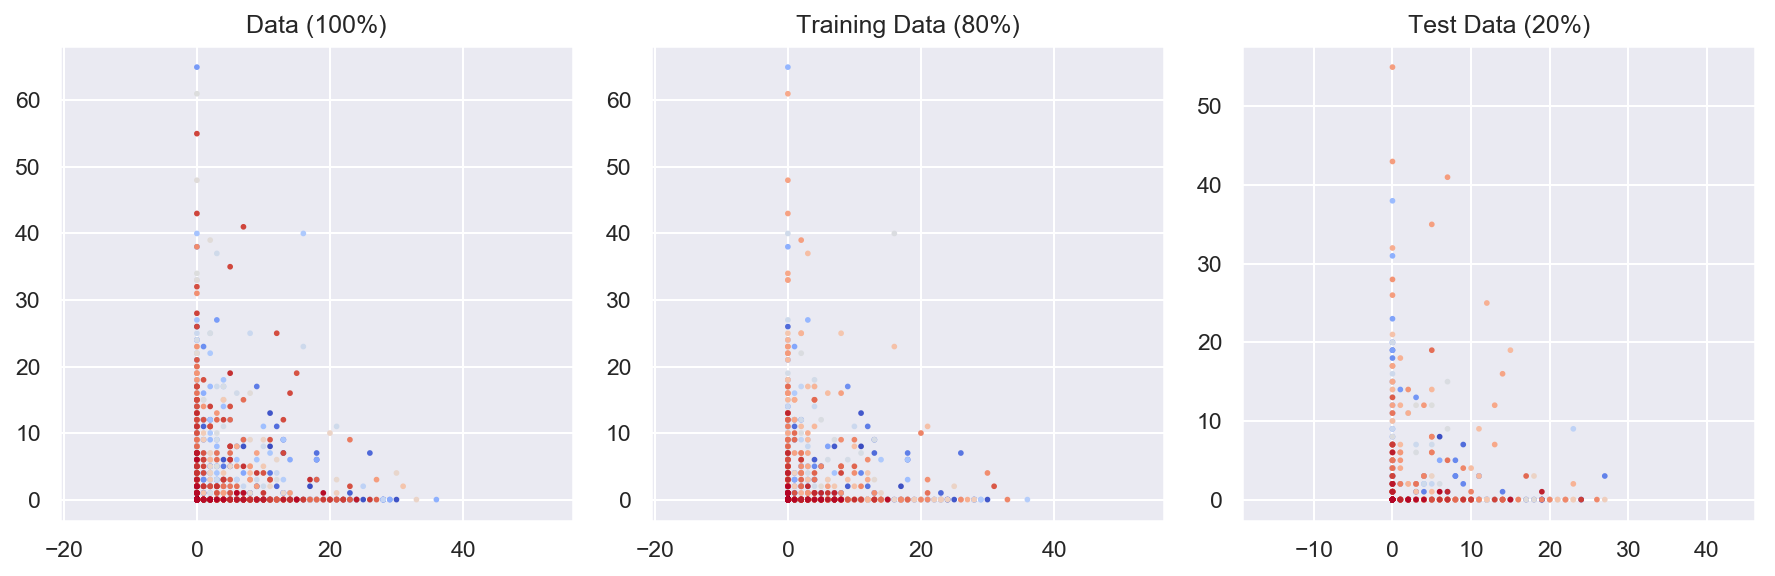

Accuracy0.8364312267657993
Precision0.8369592356315448
Recall0.8360097975869816
F1 Score0.8358048284210189


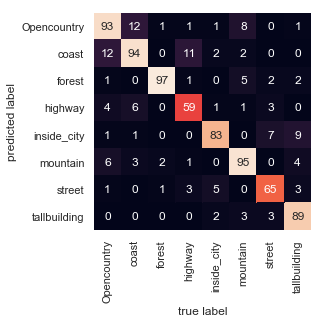

[0.79, 0.79, 0.79]
[0.78, 0.81, 0.79]
[0.9, 0.96, 0.93]
[0.8, 0.78, 0.79]
[0.82, 0.88, 0.85]
[0.86, 0.83, 0.84]
[0.83, 0.81, 0.82]
[0.92, 0.82, 0.87]
plotMat: [[0.79, 0.79, 0.79], [0.78, 0.81, 0.79], [0.9, 0.96, 0.93], [0.8, 0.78, 0.79], [0.82, 0.88, 0.85], [0.86, 0.83, 0.84], [0.83, 0.81, 0.82], [0.92, 0.82, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


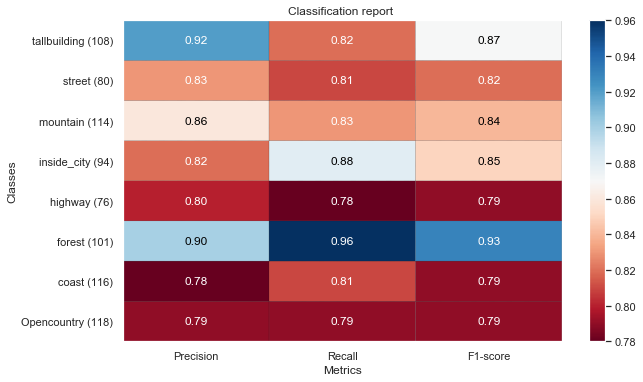

For Kernel=sigmoid the accuracy is: 0.8364312267657993


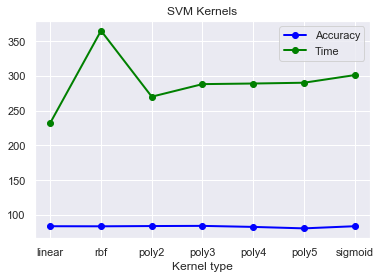

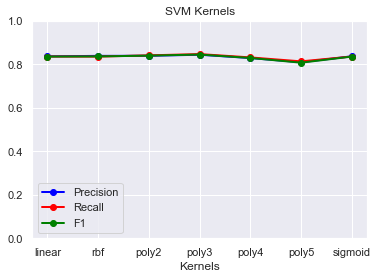

[0.8369564769458904, 0.8360097975869816, 0.8358008172395797]
[0.8389312268361324, 0.8356325742418551, 0.836434588696136]
[0.8393754258913395, 0.8413712723836249, 0.8401313637425575]
[0.8441850473062413, 0.8471988674567503, 0.8451200002238985]
[0.8290696659470286, 0.831905095890974, 0.8294019131238568]
[0.8096642935749956, 0.8137073979728587, 0.8077010059841043]
[0.8369592356315448, 0.8360097975869816, 0.8358048284210189]
plotMat: [[0.8369564769458904, 0.8360097975869816, 0.8358008172395797], [0.8389312268361324, 0.8356325742418551, 0.836434588696136], [0.8393754258913395, 0.8413712723836249, 0.8401313637425575], [0.8441850473062413, 0.8471988674567503, 0.8451200002238985], [0.8290696659470286, 0.831905095890974, 0.8294019131238568], [0.8096642935749956, 0.8137073979728587, 0.8077010059841043], [0.8369592356315448, 0.8360097975869816, 0.8358048284210189]]
support: ["{'C':0.001,'gamma':1e-05}", "{'C':10,'gamma':1e-05}", "{'C':0.001,'gamma':0.01}", "{'C':0.0001,'gamma':0.01}", "{'C':0.000

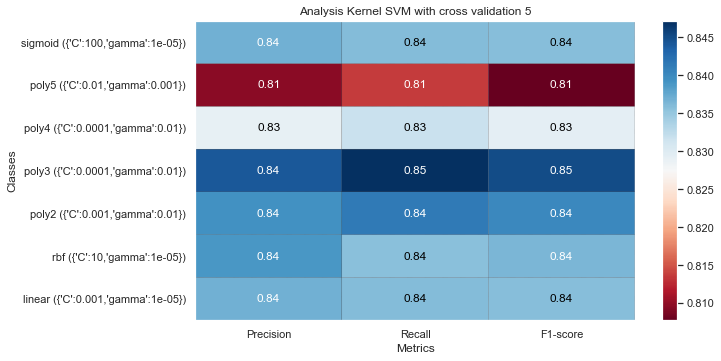

10
linear
{'C': 0.001, 'gamma': 1e-05}
{'mean_fit_time': array([0.23689158, 0.2362644 , 0.23525052, 0.23253365, 0.23396828,
       0.2312005 , 0.18181269, 0.17918434, 0.18509402, 0.18061934,
       0.18287232, 0.18227062, 0.21348398, 0.21264238, 0.21125352,
       0.22089715, 0.23386686, 0.22262862, 0.33801072, 0.33721082,
       0.33724816, 0.33727279, 0.33601069, 0.3387233 , 0.45118649,
       0.50710182, 0.5579639 , 0.5258543 , 0.53730948, 0.52932396,
       0.54160385, 0.47645011, 0.47514203, 0.4776185 , 0.4772867 ,
       0.47533937, 0.47795422, 0.47267616, 0.47397037, 0.4758424 ,
       0.47496319, 0.47828522]), 'std_fit_time': array([0.01193458, 0.00795538, 0.00751222, 0.00794628, 0.00628277,
       0.00411132, 0.00717118, 0.00489908, 0.01026079, 0.00642706,
       0.00751663, 0.00591018, 0.00968402, 0.00626277, 0.00833107,
       0.01312667, 0.00585767, 0.01185176, 0.05377179, 0.05277885,
       0.0502833 , 0.04939238, 0.04678218, 0.04970027, 0.09555179,
       0.09181555, 0.12

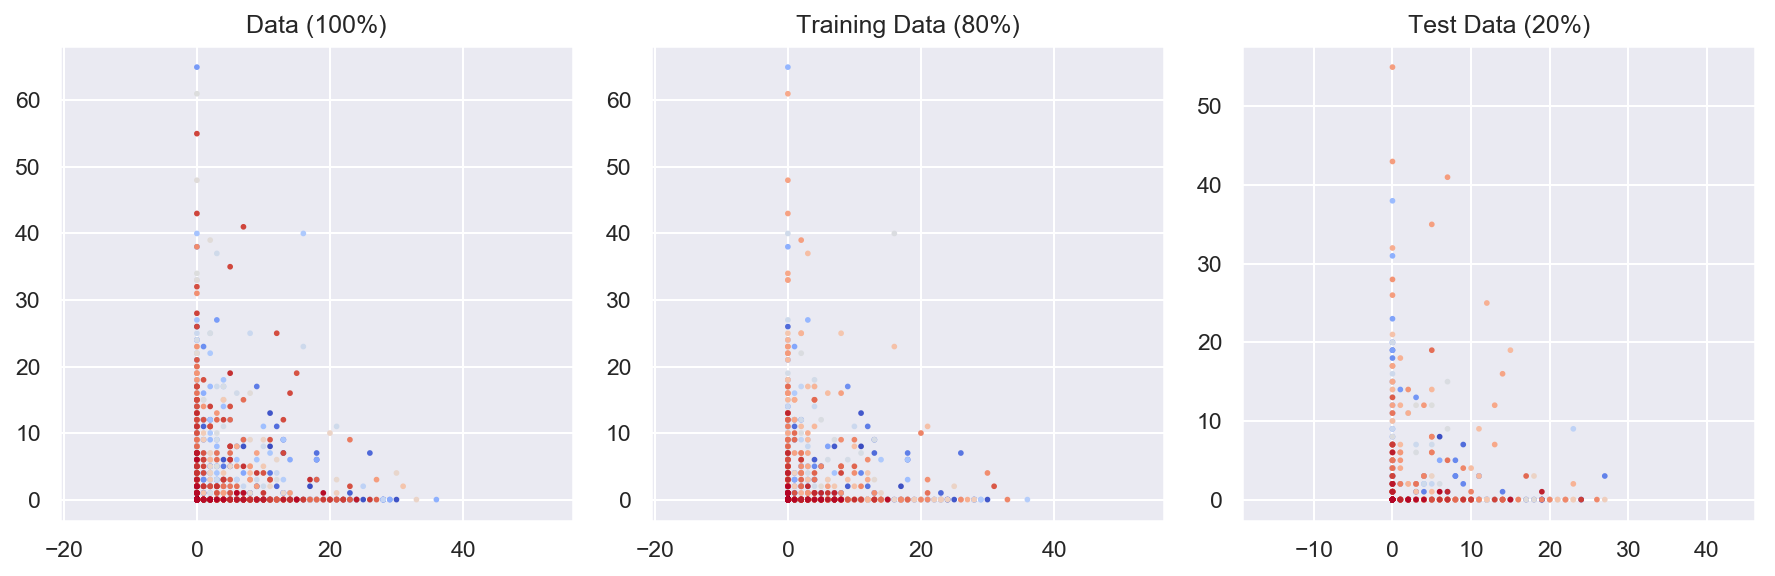

Accuracy0.8364312267657993
Precision0.8369564769458904
Recall0.8360097975869816
F1 Score0.8358008172395797


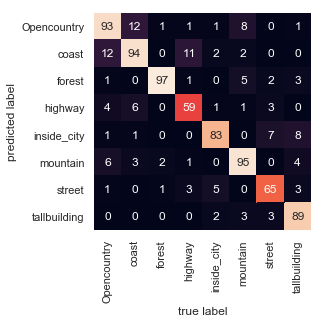

[0.79, 0.79, 0.79]
[0.78, 0.81, 0.79]
[0.89, 0.96, 0.92]
[0.8, 0.78, 0.79]
[0.83, 0.88, 0.86]
[0.86, 0.83, 0.84]
[0.83, 0.81, 0.82]
[0.92, 0.82, 0.87]
plotMat: [[0.79, 0.79, 0.79], [0.78, 0.81, 0.79], [0.89, 0.96, 0.92], [0.8, 0.78, 0.79], [0.83, 0.88, 0.86], [0.86, 0.83, 0.84], [0.83, 0.81, 0.82], [0.92, 0.82, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


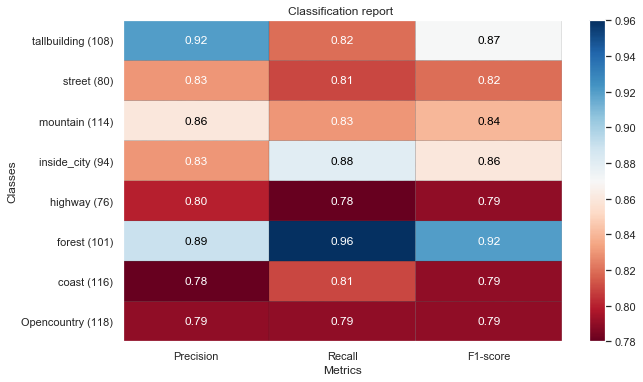

For Kernel=linear the accuracy is: 0.8364312267657993
rbf


/Users/daniel/.conda/envs/wavelets/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10, 'gamma': 0.0001}
{'mean_fit_time': array([0.77344916, 0.76870627, 0.76304748, 0.80571272, 0.80471752,
       0.68107736, 0.76948946, 0.77760775, 0.78522284, 0.8154444 ,
       0.87765024, 0.74692013, 0.78512986, 0.77940378, 0.82305365,
       0.93225257, 0.89959872, 0.76897199, 0.76240449, 0.53884027,
       0.82229013, 0.96363738, 0.91910546, 0.78652332, 0.44510796,
       0.27340169, 0.87745652, 1.0307456 , 0.92779384, 0.79524457,
       0.23666387, 0.24047475, 0.87900336, 1.11643288, 0.99166472,
       0.84845388, 0.20887301, 0.25487399, 0.88966146, 1.12553427,
       0.98685415, 0.86316781]), 'std_fit_time': array([0.00887555, 0.01439452, 0.00944525, 0.01018728, 0.0096481 ,
       0.01133199, 0.01265471, 0.00790636, 0.01416684, 0.01486225,
       0.0165099 , 0.00943126, 0.01966335, 0.00749478, 0.01067181,
       0.01682695, 0.01455001, 0.01292843, 0.01471811, 0.0132922 ,
       0.00966233, 0.01136124, 0.01455419, 0.01202604, 0.0110124 ,
       0.00877324, 0.014273  , 0.01

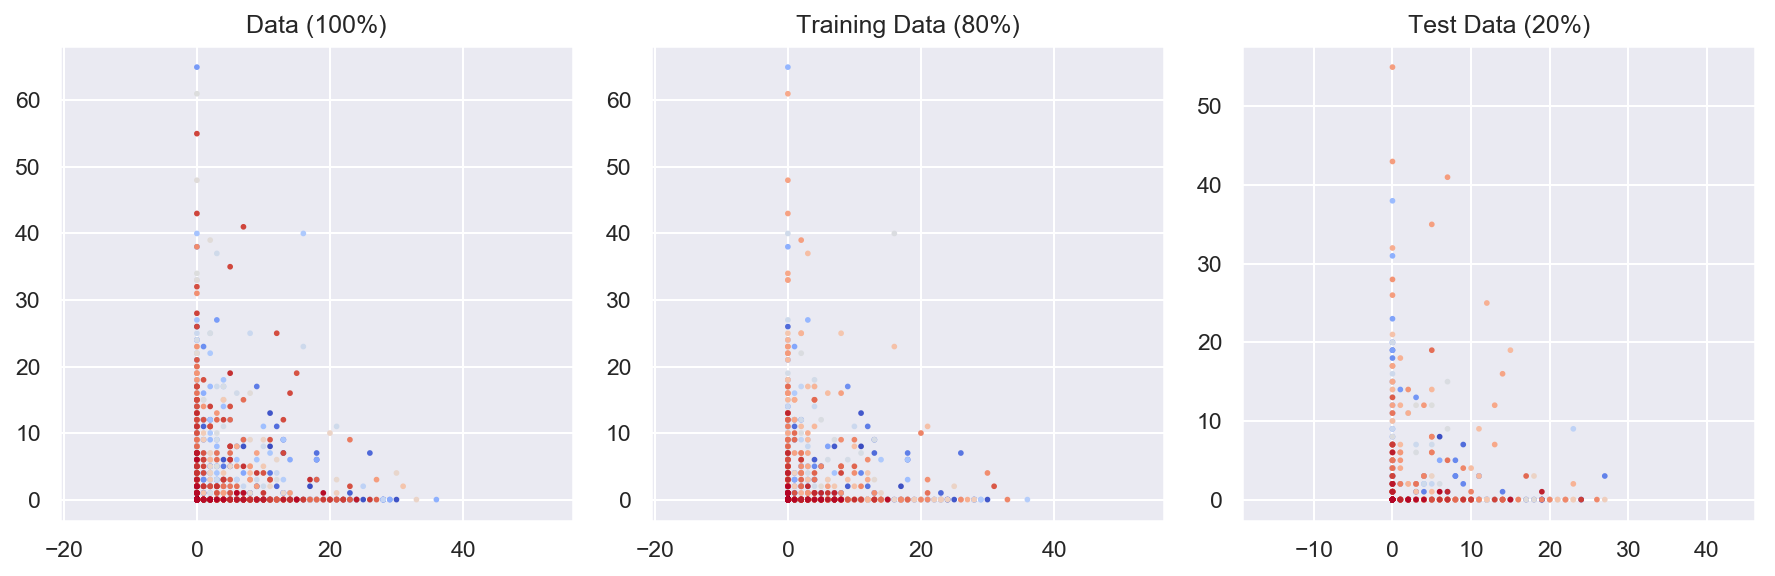

Accuracy0.8438661710037175
Precision0.8438609459915547
Recall0.844341120621604
F1 Score0.8438552471321219


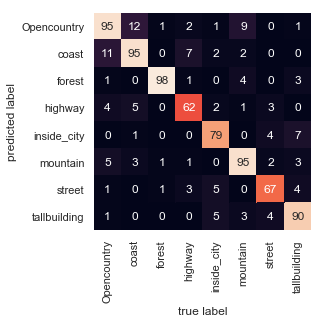

[0.79, 0.81, 0.79]
[0.81, 0.82, 0.82]
[0.92, 0.97, 0.94]
[0.81, 0.82, 0.81]
[0.87, 0.84, 0.85]
[0.86, 0.83, 0.85]
[0.83, 0.84, 0.83]
[0.87, 0.83, 0.85]
plotMat: [[0.79, 0.81, 0.79], [0.81, 0.82, 0.82], [0.92, 0.97, 0.94], [0.81, 0.82, 0.81], [0.87, 0.84, 0.85], [0.86, 0.83, 0.85], [0.83, 0.84, 0.83], [0.87, 0.83, 0.85]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


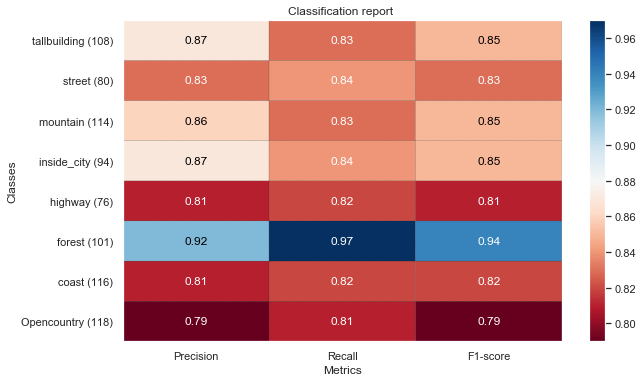

For Kernel=rbf the accuracy is: 0.8438661710037175
poly2
{'C': 0.001, 'gamma': 0.01}
{'mean_fit_time': array([0.68744657, 0.67030385, 0.69013782, 0.37664702, 0.27257991,
       0.27204733, 0.67001472, 0.69152761, 0.63499062, 0.25434945,
       0.27170365, 0.26799729, 0.67547119, 0.67864659, 0.37463009,
       0.27153146, 0.27407241, 0.2700537 , 0.67905502, 0.6308224 ,
       0.25568299, 0.27044642, 0.27538943, 0.26865332, 0.68001313,
       0.37687213, 0.2746551 , 0.27418847, 0.2724153 , 0.27092264,
       0.63248053, 0.25781524, 0.27122223, 0.26982026, 0.27245238,
       0.27679691, 0.3750226 , 0.27245319, 0.27680156, 0.27123873,
       0.27651246, 0.27446139]), 'std_fit_time': array([0.02631034, 0.00689442, 0.01325717, 0.00597144, 0.00772259,
       0.00543381, 0.0110429 , 0.02145826, 0.01306545, 0.00591494,
       0.006902  , 0.00498145, 0.01116556, 0.00985029, 0.00532379,
       0.00381758, 0.01020808, 0.00683134, 0.00909654, 0.01083148,
       0.00593306, 0.00434249, 0.00900342, 0

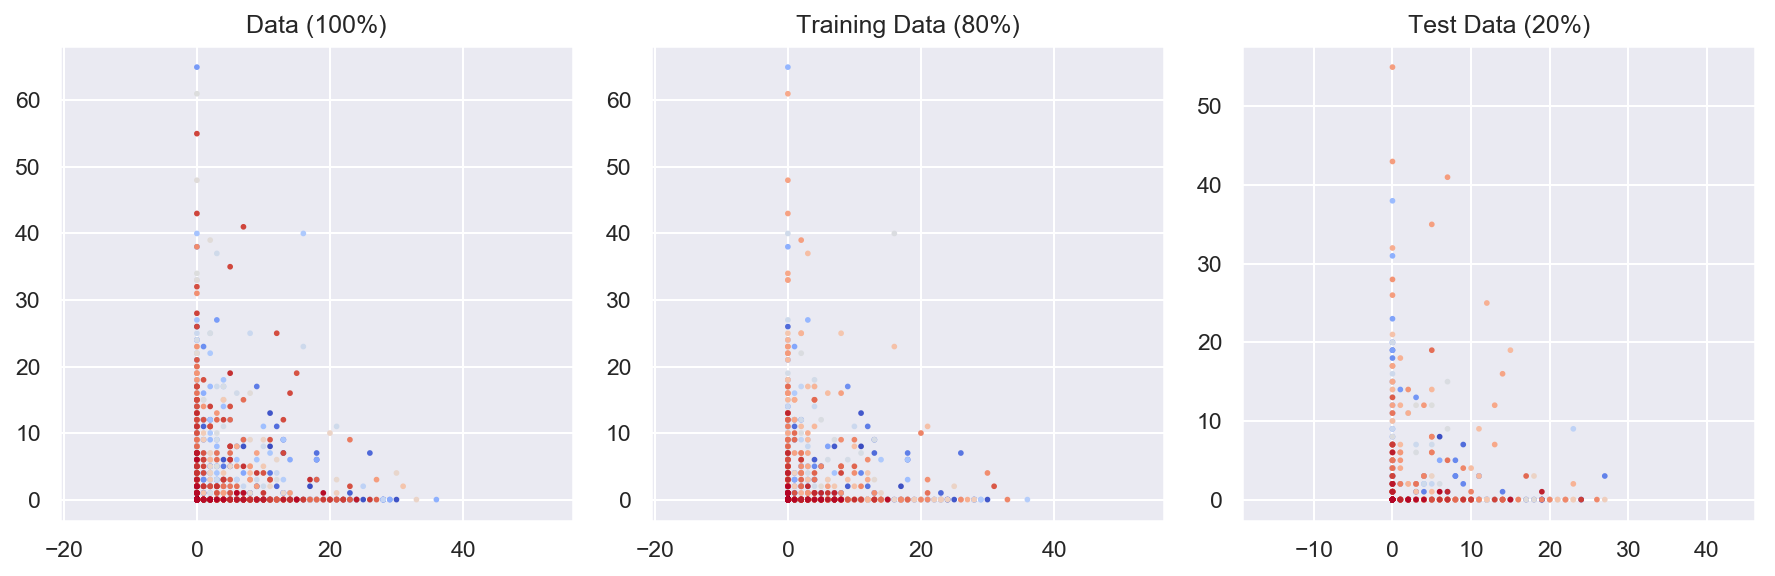

Accuracy0.838909541511772
Precision0.8393754258913395
Recall0.8413712723836249
F1 Score0.8401313637425575


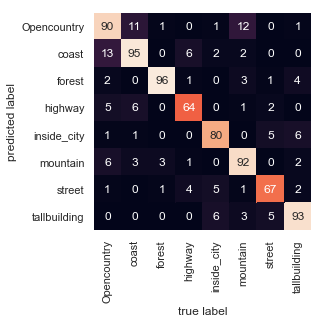

[0.78, 0.76, 0.77]
[0.81, 0.82, 0.81]
[0.9, 0.95, 0.92]
[0.82, 0.84, 0.83]
[0.86, 0.85, 0.86]
[0.86, 0.81, 0.83]
[0.83, 0.84, 0.83]
[0.87, 0.86, 0.87]
plotMat: [[0.78, 0.76, 0.77], [0.81, 0.82, 0.81], [0.9, 0.95, 0.92], [0.82, 0.84, 0.83], [0.86, 0.85, 0.86], [0.86, 0.81, 0.83], [0.83, 0.84, 0.83], [0.87, 0.86, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


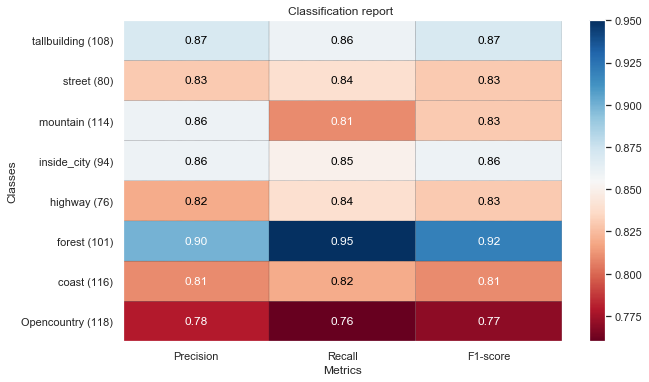

For Kernel=poly2 the accuracy is: 0.838909541511772
poly3
{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.67687111, 0.67639024, 0.67548478, 0.37156465, 0.36841037,
       0.36509223, 0.68261006, 0.67695935, 0.54601979, 0.36579087,
       0.36949489, 0.36587098, 0.67686234, 0.6923744 , 0.36731153,
       0.37112329, 0.36827409, 0.38327892, 0.82437074, 0.81908858,
       0.44006119, 0.37270503, 0.3723515 , 0.36774666, 0.67483332,
       0.54643233, 0.36922834, 0.36938648, 0.37001326, 0.37895274,
       0.68288012, 0.37088537, 0.37300546, 0.36476092, 0.3689589 ,
       0.41613319, 0.66339042, 0.36624854, 0.37321591, 0.36627371,
       0.37006829, 0.82613652]), 'std_fit_time': array([0.01682999, 0.01116907, 0.0133548 , 0.00939218, 0.01101418,
       0.00733608, 0.01001745, 0.01005371, 0.00685508, 0.00483002,
       0.00775983, 0.00581988, 0.0134723 , 0.01261513, 0.00818524,
       0.00688116, 0.01103562, 0.02650731, 0.02556548, 0.04364778,
       0.02341267, 0.01050675, 0.00861697,

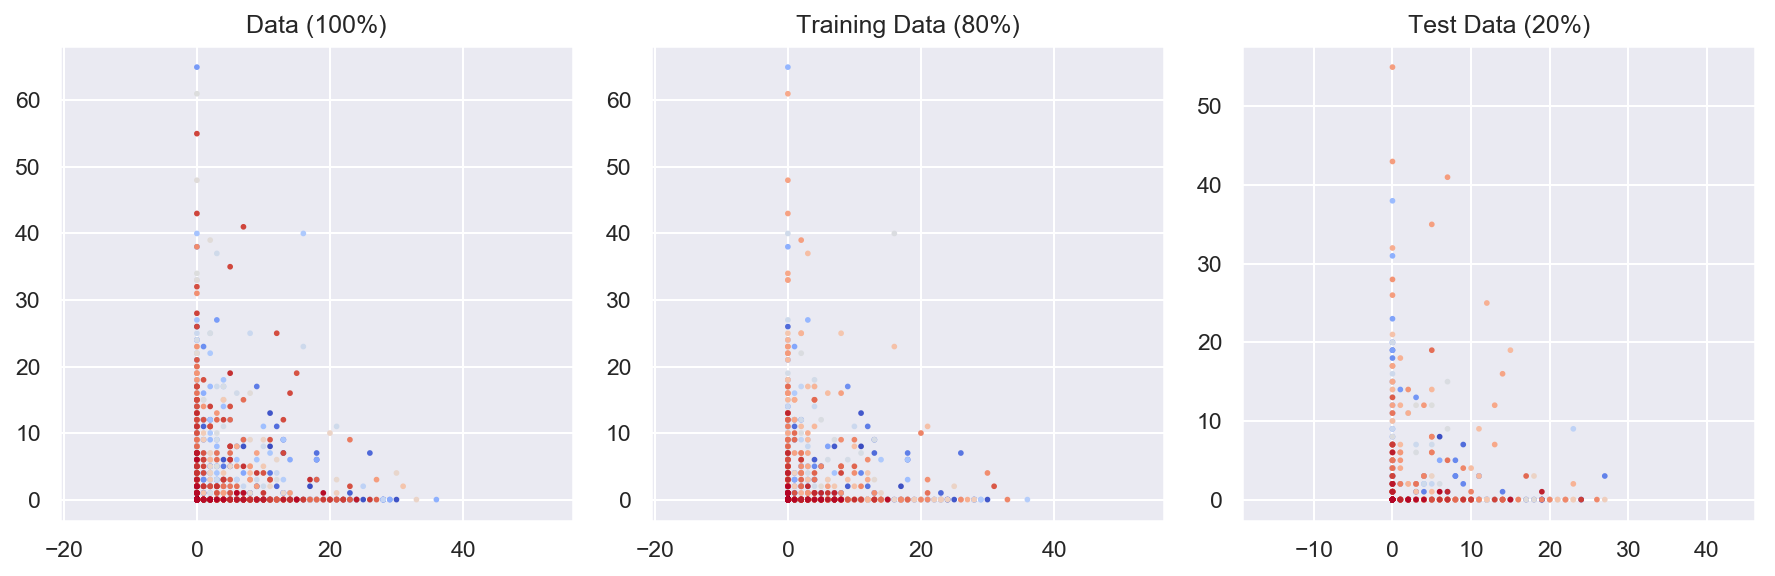

Accuracy0.8413878562577447
Precision0.8441850473062413
Recall0.8471988674567503
F1 Score0.8451200002238985


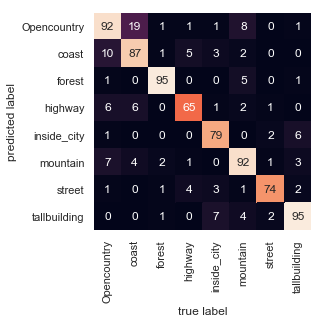

[0.75, 0.78, 0.76]
[0.81, 0.75, 0.78]
[0.93, 0.94, 0.94]
[0.8, 0.86, 0.83]
[0.9, 0.84, 0.87]
[0.84, 0.81, 0.82]
[0.86, 0.93, 0.89]
[0.87, 0.88, 0.88]
plotMat: [[0.75, 0.78, 0.76], [0.81, 0.75, 0.78], [0.93, 0.94, 0.94], [0.8, 0.86, 0.83], [0.9, 0.84, 0.87], [0.84, 0.81, 0.82], [0.86, 0.93, 0.89], [0.87, 0.88, 0.88]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


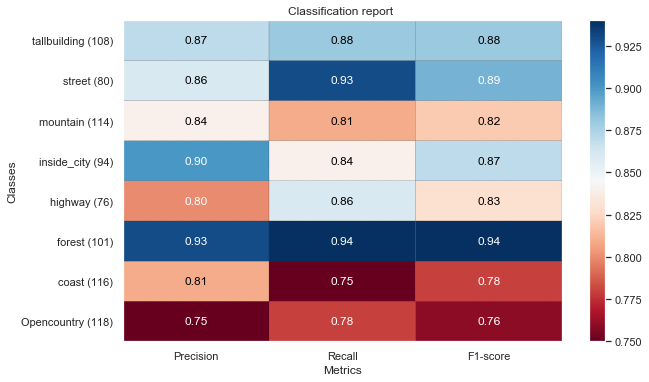

For Kernel=poly3 the accuracy is: 0.8413878562577447
poly4
{'C': 0.1, 'gamma': 0.001}
{'mean_fit_time': array([0.68228383, 0.68274698, 0.64587359, 0.50306478, 0.50022931,
       0.50333316, 0.69009237, 0.69057171, 0.50534105, 0.49497509,
       0.49717453, 0.5027072 , 0.68279967, 0.69262266, 0.45705009,
       0.49678476, 0.50402536, 0.50374808, 0.69155719, 0.68602951,
       0.50803356, 0.50265722, 0.49703734, 0.49962673, 0.69620934,
       0.65131595, 0.49660115, 0.50537105, 0.50097802, 0.50494678,
       0.74765701, 0.62316058, 0.59679248, 0.58806725, 0.61773338,
       0.58599567, 0.80570989, 0.55098372, 0.61038485, 0.61107187,
       0.71020479, 0.6334471 ]), 'std_fit_time': array([0.0139177 , 0.01436628, 0.02465936, 0.01541921, 0.01533515,
       0.01054075, 0.02618035, 0.01599614, 0.00619753, 0.01089568,
       0.00827658, 0.01875967, 0.01222839, 0.01036145, 0.01611643,
       0.01253821, 0.01474664, 0.01522607, 0.01048474, 0.01685814,
       0.01993768, 0.01925433, 0.01363386, 

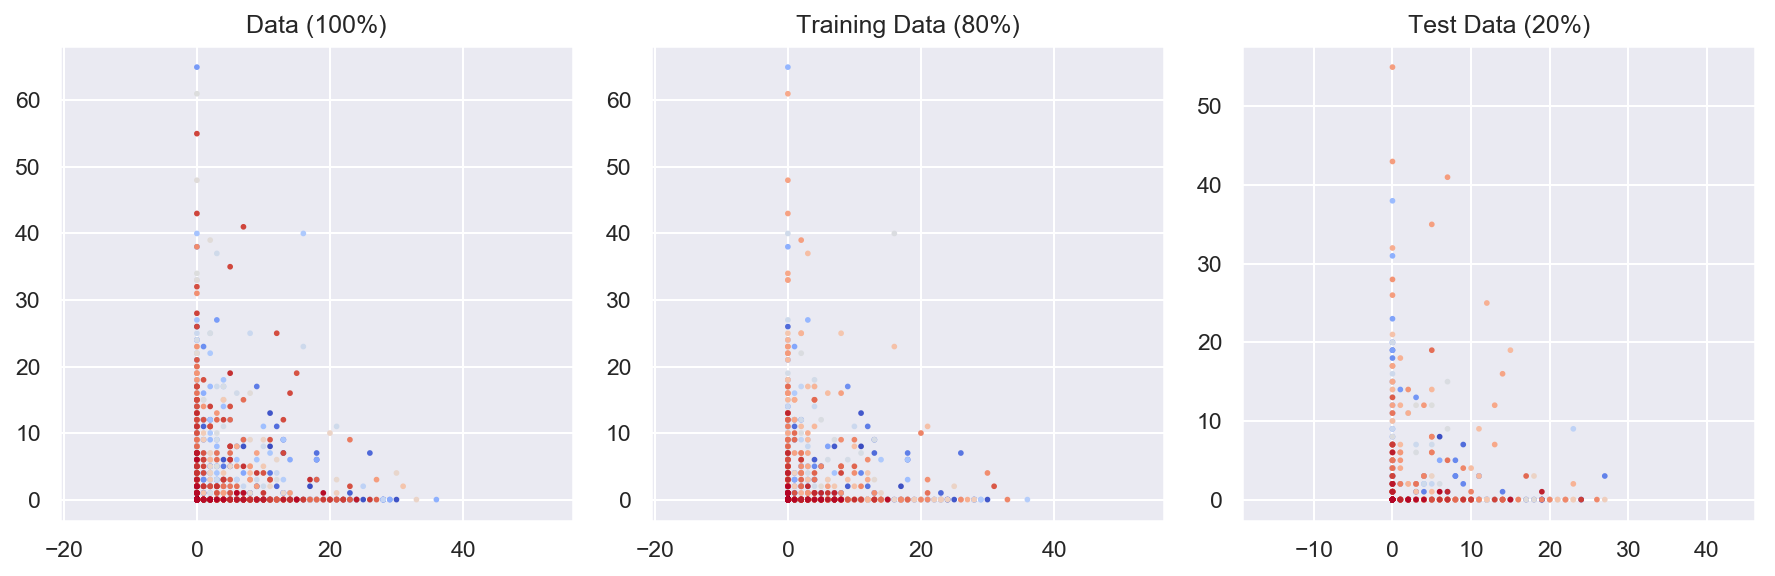

Accuracy0.8265179677819083
Precision0.8290696659470286
Recall0.831905095890974
F1 Score0.8294019131238568


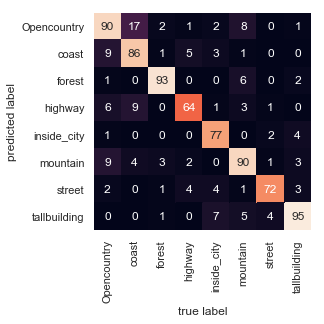

[0.74, 0.76, 0.75]
[0.82, 0.74, 0.78]
[0.91, 0.92, 0.92]
[0.76, 0.84, 0.8]
[0.92, 0.82, 0.87]
[0.8, 0.79, 0.8]
[0.83, 0.9, 0.86]
[0.85, 0.88, 0.86]
plotMat: [[0.74, 0.76, 0.75], [0.82, 0.74, 0.78], [0.91, 0.92, 0.92], [0.76, 0.84, 0.8], [0.92, 0.82, 0.87], [0.8, 0.79, 0.8], [0.83, 0.9, 0.86], [0.85, 0.88, 0.86]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


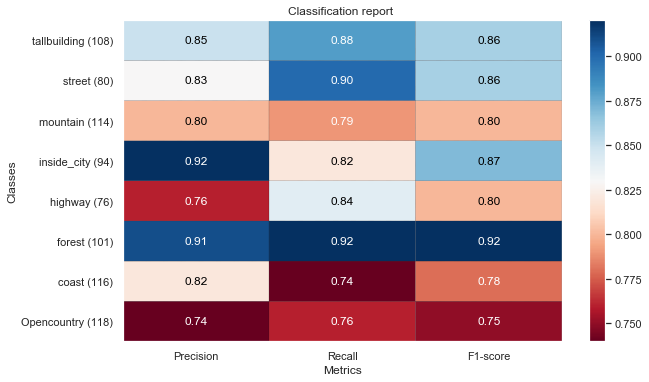

For Kernel=poly4 the accuracy is: 0.8265179677819083
poly5


/Users/daniel/.conda/envs/wavelets/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.0001, 'gamma': 0.01}
{'mean_fit_time': array([0.77867656, 0.78296223, 0.68170407, 0.69397609, 0.6947129 ,
       0.70122113, 0.77721307, 0.77360246, 0.59489675, 0.71756544,
       0.69759142, 0.68834805, 0.78540325, 0.79136853, 0.69980724,
       0.7137208 , 0.70646136, 0.74660614, 0.83414764, 0.81986291,
       0.71966643, 0.69921496, 0.73891098, 0.71484568, 0.78328607,
       0.76249843, 0.72069759, 0.75488458, 0.66950169, 0.6454999 ,
       0.70123568, 0.60413041, 0.61465089, 0.61981149, 0.61813967,
       0.61366956, 0.69289787, 0.52044051, 0.61405892, 0.61575153,
       0.61348553, 0.61297789]), 'std_fit_time': array([0.01442466, 0.01292216, 0.01425755, 0.01321974, 0.00824438,
       0.0147678 , 0.01114177, 0.00842725, 0.02234259, 0.02219961,
       0.00829303, 0.01317304, 0.00980524, 0.01668535, 0.01228145,
       0.02672675, 0.03810672, 0.04143812, 0.03212433, 0.02835604,
       0.0213558 , 0.01488345, 0.0357066 , 0.01913166, 0.01593261,
       0.01244296, 0.02157168, 0.

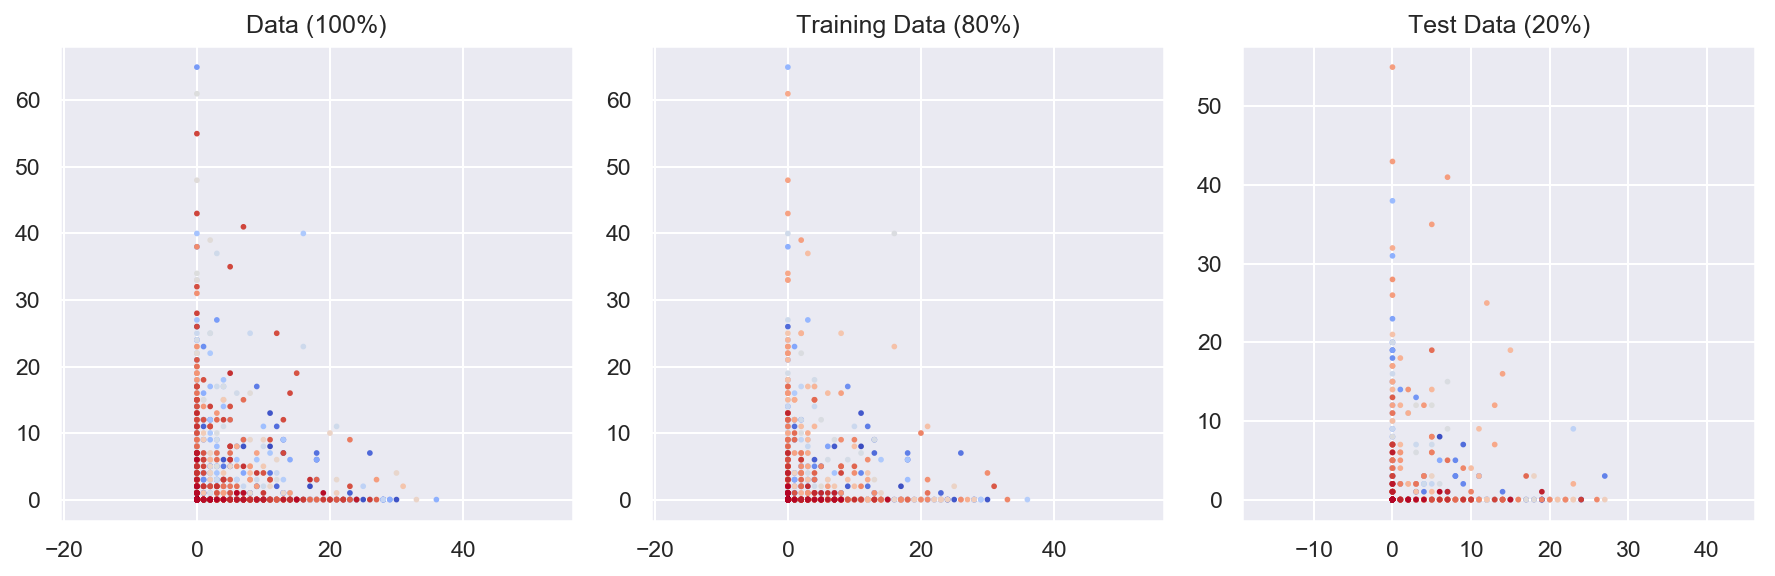

Accuracy0.80545229244114
Precision0.8087920287172827
Recall0.8129702831526092
F1 Score0.806956810338028


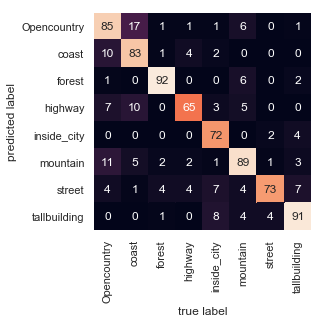

[0.76, 0.72, 0.74]
[0.83, 0.72, 0.77]
[0.91, 0.91, 0.91]
[0.72, 0.86, 0.78]
[0.92, 0.77, 0.84]
[0.78, 0.78, 0.78]
[0.7, 0.91, 0.79]
[0.84, 0.84, 0.84]
plotMat: [[0.76, 0.72, 0.74], [0.83, 0.72, 0.77], [0.91, 0.91, 0.91], [0.72, 0.86, 0.78], [0.92, 0.77, 0.84], [0.78, 0.78, 0.78], [0.7, 0.91, 0.79], [0.84, 0.84, 0.84]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


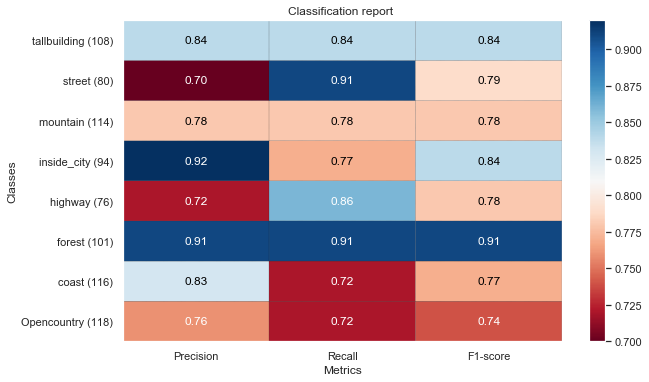

For Kernel=poly5 the accuracy is: 0.80545229244114
sigmoid


/Users/daniel/.conda/envs/wavelets/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 100, 'gamma': 1e-05}
{'mean_fit_time': array([0.73072121, 0.76104264, 0.79986556, 0.85684085, 0.71243629,
       0.68903589, 0.73593197, 0.76955435, 0.80157964, 0.86730778,
       0.7108562 , 0.68638573, 0.74158111, 0.77253847, 0.77240493,
       0.86883407, 0.71205108, 0.69000874, 0.74305248, 0.54730563,
       0.42060525, 0.82637525, 0.71358209, 0.69379551, 0.51437829,
       0.26347768, 0.23452356, 0.74483681, 0.70649686, 0.69088798,
       0.25586593, 0.19559615, 0.18411415, 0.46466062, 0.69454114,
       0.68165314, 0.19767442, 0.19067936, 0.1774889 , 0.3180582 ,
       0.65117669, 0.67977636]), 'std_fit_time': array([0.0088713 , 0.00880524, 0.01067237, 0.00881578, 0.01023513,
       0.01068231, 0.01021288, 0.01156492, 0.00991975, 0.01703969,
       0.01334437, 0.00899815, 0.00735616, 0.01020054, 0.01284941,
       0.01301287, 0.01197978, 0.01603184, 0.0146342 , 0.01078298,
       0.00609312, 0.01395818, 0.01719913, 0.01284415, 0.00577022,
       0.00660346, 0.00544824, 0.01

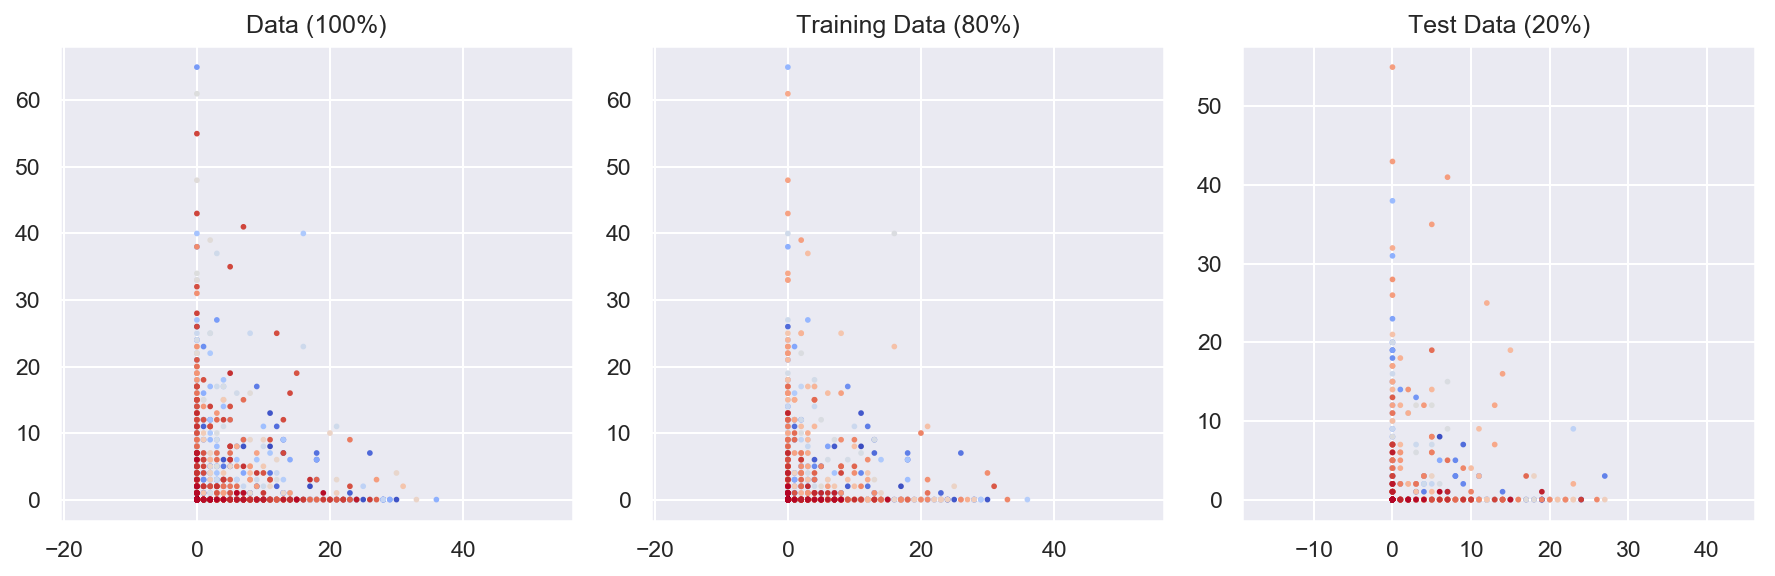

Accuracy0.8364312267657993
Precision0.8369592356315448
Recall0.8360097975869816
F1 Score0.8358048284210189


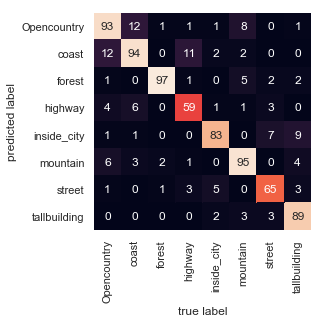

[0.79, 0.79, 0.79]
[0.78, 0.81, 0.79]
[0.9, 0.96, 0.93]
[0.8, 0.78, 0.79]
[0.82, 0.88, 0.85]
[0.86, 0.83, 0.84]
[0.83, 0.81, 0.82]
[0.92, 0.82, 0.87]
plotMat: [[0.79, 0.79, 0.79], [0.78, 0.81, 0.79], [0.9, 0.96, 0.93], [0.8, 0.78, 0.79], [0.82, 0.88, 0.85], [0.86, 0.83, 0.84], [0.83, 0.81, 0.82], [0.92, 0.82, 0.87]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


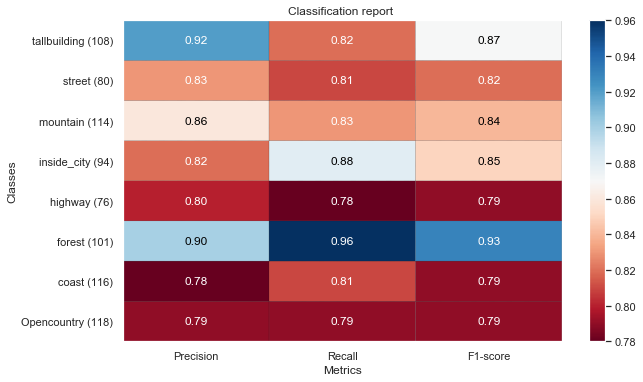

For Kernel=sigmoid the accuracy is: 0.8364312267657993


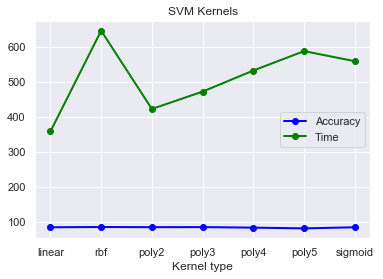

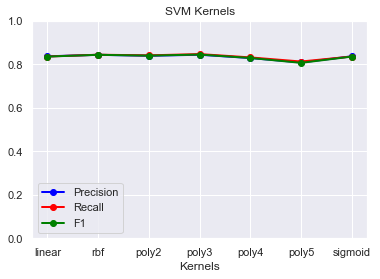

[0.8369564769458904, 0.8360097975869816, 0.8358008172395797]
[0.8438609459915547, 0.844341120621604, 0.8438552471321219]
[0.8393754258913395, 0.8413712723836249, 0.8401313637425575]
[0.8441850473062413, 0.8471988674567503, 0.8451200002238985]
[0.8290696659470286, 0.831905095890974, 0.8294019131238568]
[0.8087920287172827, 0.8129702831526092, 0.806956810338028]
[0.8369592356315448, 0.8360097975869816, 0.8358048284210189]
plotMat: [[0.8369564769458904, 0.8360097975869816, 0.8358008172395797], [0.8438609459915547, 0.844341120621604, 0.8438552471321219], [0.8393754258913395, 0.8413712723836249, 0.8401313637425575], [0.8441850473062413, 0.8471988674567503, 0.8451200002238985], [0.8290696659470286, 0.831905095890974, 0.8294019131238568], [0.8087920287172827, 0.8129702831526092, 0.806956810338028], [0.8369592356315448, 0.8360097975869816, 0.8358048284210189]]
support: ["{'C':0.001,'gamma':1e-05}", "{'C':10,'gamma':0.0001}", "{'C':0.001,'gamma':0.01}", "{'C':0.0001,'gamma':0.01}", "{'C':0.1,'g

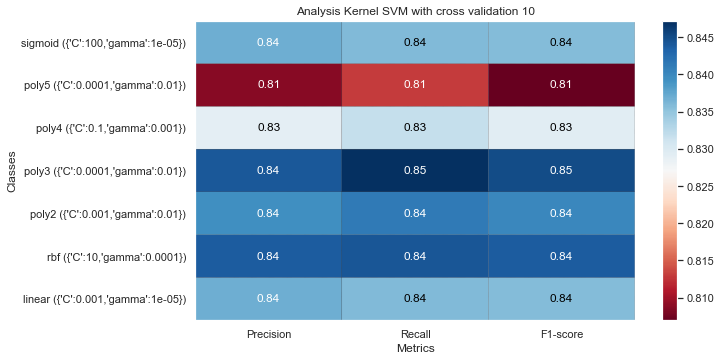

15
linear


KeyboardInterrupt: 

In [18]:
def plot_data(X_train, y_train, X_test, y_test):
    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))

    colors = np.arange(len(y))
    colors_train = np.arange(len(y_train))
    colors_test = np.arange(len(y_test))

    plt.figure(figsize=(12, 4), dpi=150)

    # Plot all data plot
    plt.subplot(131)
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.coolwarm, s=3)
    plt.title("Data (100%)")

    # training data plot
    plt.subplot(132)
    plt.axis('equal')
    # plt.axis('off')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=colors_train, cmap=plt.cm.coolwarm, s=3)
    plt.title("Training Data (80%)")

    # testing data plot
    plt.subplot(133)
    plt.axis('equal')
    # plt.axis('off')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=colors_test,  cmap=plt.cm.coolwarm, s=3)
    plt.title("Test Data (20%)")
    plt.tight_layout()

    plt.show()

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in intert.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    plt.show()


def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(t[-1])
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def plot_classification_report_custom(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[1 : (len(lines) - 1)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(t[-1])
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


if verbose_analysis:

    crossValidationValues = [2, 3, 5, 10, 15]
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma': gammas}

    for crossVal in crossValidationValues:
        print(crossVal)
        sampleClassificationReportCustom = "{0} {1} {2} {3}".format('precision', 'recall', 'f1-score',
                                                                    'Arguments Kernel') + '\n'
        SVMKernels = ['linear', 'rbf', 'poly2', 'poly3', 'poly4', 'poly5', 'sigmoid']
        accuracies = list()
        precisions = list()
        recalls = list()
        f1s = list()
        time_list = list()

        for kernel in SVMKernels:
            print(kernel)
            step_size = 15
            start = time.time()
            SIFTdetector = cv2.xfeatures2d.SIFT_create()
            Train_descriptors = []
            Train_label_per_descriptor = []
            for filename, labels in zip(train_images_filenames, train_labels):
                ima = cv2.imread(filename)
                x, y = ima.shape[:2]
                h = int(x)
                w = int(y)
                res = cv2.resize(ima, dsize=(h, w))
                gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
                kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                      for x in range(0, gray.shape[1], step_size)]
                kpt, des = SIFTdetector.compute(gray, kp)
                Train_descriptors.append(des)
                Train_label_per_descriptor.append(labels)
            D = np.vstack(Train_descriptors)
            k = 140
            codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                       reassignment_ratio=10 ** -4, random_state=42)
            codebook.fit(D)
            visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
            for i in range(len(Train_descriptors)):
                words = codebook.predict(Train_descriptors[i])
                visual_words[i, :] = np.bincount(words, minlength=k)

            if kernel == 'poly2':
                sv = svm.SVC(kernel='poly', degree=2)
            elif kernel == 'poly3':
                sv = svm.SVC(kernel='poly', degree=3)
            elif kernel == 'poly4':
                sv = svm.SVC(kernel='poly', degree=4)
            elif kernel == 'poly5':
                sv = svm.SVC(kernel='poly', degree=5)
            else:
                sv = svm.SVC(kernel=kernel)

            grid_search = GridSearchCV(sv, param_grid, cv=crossVal)
            grid_search.fit(visual_words, train_labels)

            print(grid_search.best_params_)
            print(grid_search.cv_results_)

            visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
            results = list()
            for i in range(len(test_images_filenames)):
                filename = test_images_filenames[i]
                ima = cv2.imread(filename)
                x, y = ima.shape[:2]
                h = int(x)
                w = int(y)
                res = cv2.resize(ima, dsize=(h, w))
                gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
                kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                      for x in range(0, gray.shape[1], step_size)]
                kpt, des = SIFTdetector.compute(gray, kp)
                words = codebook.predict(des)
                visual_words_test[i, :] = np.bincount(words, minlength=k)

            predict_labels = grid_search.predict(visual_words_test)

            plot_data(visual_words, train_labels, visual_words_test, predict_labels)

            accuracy = metrics.accuracy_score(test_labels, predict_labels)
            precision = metrics.precision_score(test_labels, predict_labels, average='macro')
            recall = metrics.recall_score(test_labels, predict_labels, average='macro')
            f1 = metrics.f1_score(test_labels, predict_labels, average='macro')

            end = time.time()
            tTime = end - start

            print('Accuracy' + str(accuracy))
            print('Precision' + str(precision))
            print('Recall' + str(recall))
            print('F1 Score' + str(f1))
            accuracies.append(accuracy*100)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            time_list.append(tTime)
            sampleClassificationReportCustom += ("{0} {1} {2} {3} {4}".format(kernel, precision, recall, f1,
                                                                              str(grid_search.best_params_).replace(" ",
                                                                                                                    "")) + '\n')

            mat = metrics.confusion_matrix(test_labels, predict_labels)
            sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=np.unique(predict_labels),
                        yticklabels=np.unique(predict_labels))
            plt.xlabel('true label')
            plt.ylabel('predicted label')
            plt.show()

            report = metrics.classification_report(test_labels, predict_labels, target_names=np.unique(predict_labels))
            plot_classification_report(report)

            print('For Kernel=' + str(kernel) + ' the accuracy is: ' + str(accuracy))

        plt.plot(SVMKernels, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
        plt.plot(SVMKernels, time_list, 'go-', label='Time', linewidth=2, color='green')
        plt.legend(['Accuracy', 'Time'])
        plt.xlabel('Kernel type')
        plt.title('SVM Kernels')
        plt.show()

        plt.plot(SVMKernels, precisions, 'go-', label='Precision', linewidth=2, color='blue')
        plt.plot(SVMKernels, recalls, 'go-', label='Recall', linewidth=2, color='red')
        plt.plot(SVMKernels, f1s, 'go-', label='F1', linewidth=2, color='green')
        plt.legend(['Precision', 'Recall', 'F1'])
        plt.xlabel('Kernels')
        plt.title('SVM Kernels')
        plt.ylim([0, 1])
        plt.show()

        plot_classification_report_custom(sampleClassificationReportCustom,
                                                'Analysis Kernel SVM with cross validation ' + str(crossVal))
        plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
        plt.close()

*Preprocessing L2, StandardScalar*

Accuracy0.8413878562577447
Precision0.8441850473062413
Recall0.8471988674567503
F1 Score0.8451200002238985


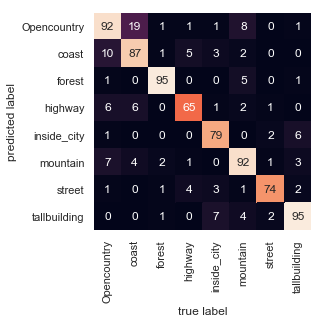

Accuracy0.7942998760842627
Precision0.805621500527888
Recall0.7962748023909199
F1 Score0.7999102480331133


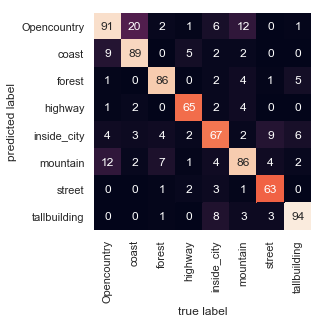

Accuracy0.8302354399008675
Precision0.8346323798918313
Recall0.8350877461333786
F1 Score0.8345319212471407


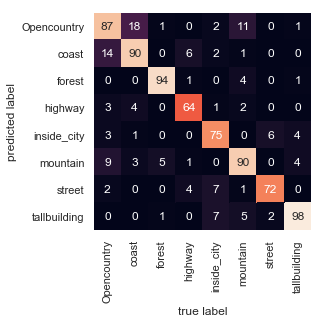

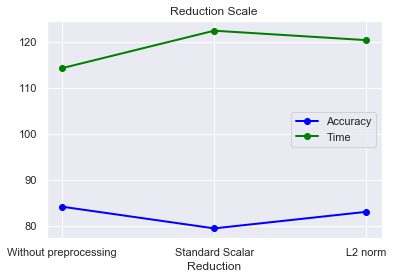

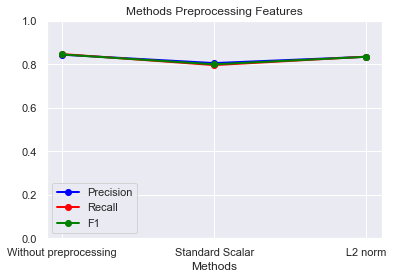

In [39]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn import svm
import seaborn as sns; sns.set()
import sklearn.preprocessing as pre

sampleClassificationReport = "{0} {1} {2} {3}".format('precision', 'recall', 'f1-score', 'norm') + '\n'
train_images_filenames = pickle.load(open('train_images_filenames.dat', 'rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat', 'rb'))
train_labels = pickle.load(open('train_labels.dat', 'rb'))
test_labels = pickle.load(open('test_labels.dat', 'rb'))
verbose_analysis = True

if verbose_analysis:

    preprocessing = ['wo', 'stdSc', 'l2']
    #preprocessing = ['wo', 'stdSc', 'l2']
    methods = ['Without preprocessing', 'Standard Scalar', 'L2 norm']

    accuracies = list()
    precisions = list()
    recalls = list()
    f1s = list()
    time_list = list()

    for method in preprocessing:

        step_size = 15
        start = time.time()
        SIFTdetector = cv2.xfeatures2d.SIFT_create()
        Train_descriptors = []
        Train_label_per_descriptor = []

        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x)
            w = int(y)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)

            if method == 'stdSc':
                desf = pre.StandardScaler().fit(des)
                des = desf.transform(des)
            elif method == 'l2':
                des = pre.normalize(des, norm='l2')

            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)
        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook.fit(D)
        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)

        sv = svm.SVC(kernel='poly', degree=3, gamma=0.01, C=0.0001)
        sv.fit(visual_words, train_labels)

        visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
        results = list()
        for i in range(len(test_images_filenames)):
            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x)
            w = int(y)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)

            if method == 'stdSc':
                desf = pre.StandardScaler().fit(des)
                des = desf.transform(des)
            elif method == 'l2':
                des = pre.normalize(des, norm='l2')

            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)

        predict_labels = sv.predict(visual_words_test)

        accuracy = metrics.accuracy_score(test_labels, predict_labels)
        precision = metrics.precision_score(test_labels, predict_labels, average='macro')
        recall = metrics.recall_score(test_labels, predict_labels, average='macro')
        f1 = metrics.f1_score(test_labels, predict_labels, average='macro')

        end = time.time()
        tTime = end - start

        print('Accuracy' + str(accuracy))
        print('Precision' + str(precision))
        print('Recall' + str(recall))
        print('F1 Score' + str(f1))

        accuracies.append(accuracy * 100)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        time_list.append(tTime)

        mat = metrics.confusion_matrix(test_labels, predict_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=np.unique(predict_labels),
                    yticklabels=np.unique(predict_labels))
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()

    plt.plot(methods, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(methods, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('Reduction')
    plt.title('Reduction Scale')
    plt.show()

    plt.plot(methods, precisions, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(methods, recalls, 'go-', label='Accuracy', linewidth=2, color='red')
    plt.plot(methods, f1s, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall', 'F1'])
    plt.xlabel('Methods')
    plt.title('Methods Preprocessing Features')
    plt.ylim([0, 1])
    plt.show()

**Cross validation **

In [2]:

sampleClassificationReport = "{0} {1} {2} {3}".format('precision', 'recall', 'f1-score', 'norm') + '\n'
train_images_filenames = pickle.load(open('train_images_filenames.dat', 'rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat', 'rb'))
train_labels = pickle.load(open('train_labels.dat', 'rb'))
test_labels = pickle.load(open('test_labels.dat', 'rb'))
verbose_analysis = True

step_size = 15
start = time.time()
SIFTdetector = cv2.xfeatures2d.SIFT_create()
accuracies=[]
K_accuracy=[]
K_Value=[]

# K-Folding
#k_num_folds = 10
k_num_folds=[2,4,8,16,32]

imgs = np.array([cv2.imread(filename) for filename in train_images_filenames])
labs = np.array([label for label in train_labels])

for k_fold in k_num_folds:

    strat = StratifiedKFold(k_fold, shuffle=True)

    for train_ind, val_ind in strat.split(imgs, labs):
        train_imgs = imgs[train_ind]
        val_imgs = imgs[val_ind]
        train_labs = labs[train_ind]
        val_labs = labs[val_ind]
        train_img_fnames = [train_images_filenames[i] for i in train_ind]
        val_img_fnames = [train_images_filenames[i] for i in val_ind]
        Train_descriptors = []
        Train_label_per_descriptor = []

        #Training
        for filename, labels in zip(train_img_fnames, train_labs):
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x)
            w = int(y)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)
        D = np.vstack(Train_descriptors)

        #KMeans
        k = 140
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)

        #Matching
        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words = codebook.predict(Train_descriptors[i])
            visual_words[i, :] = np.bincount(words, minlength=k)
        sv = svm.SVC(kernel='poly', degree=3, gamma=0.01, C=0.0001)
        sv.fit(visual_words, train_labs)

        #Test keypoint description
        visual_words_test = np.zeros((len(val_img_fnames), k), dtype=np.float32)
        results = list()
        for i in range(len(val_img_fnames)):
            filename = val_img_fnames[i]
            ima = cv2.imread(filename)
            x, y = ima.shape[:2]
            h = int(x)
            w = int(y)
            res = cv2.resize(ima, dsize=(h, w))
            gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            words = codebook.predict(des)
            visual_words_test[i, :] = np.bincount(words, minlength=k)

        #Prediction
        predict_labels = sv.predict(visual_words_test)
        accuracy = metrics.accuracy_score(val_labs, predict_labels)
        accuracies.append(accuracy)

    #Final results preparation
    K_accuracy.append(np.mean(accuracies))
    K_Value.append(k_fold)

    print("K VALUE:" + str(k_fold) + " - Accuracy: " + str(K_accuracy))

print(zip(K_accuracy,K_Value))

K VALUE:2 - Accuracy: [0.7884086643905306]
K VALUE:4 - Accuracy: [0.7884086643905306, 0.7930227466393719]
K VALUE:8 - Accuracy: [0.7884086643905306, 0.7930227466393719, 0.7983596179323802]
K VALUE:16 - Accuracy: [0.7884086643905306, 0.7930227466393719, 0.7983596179323802, 0.7961852363776633]
K VALUE:32 - Accuracy: [0.7884086643905306, 0.7930227466393719, 0.7983596179323802, 0.7961852363776633, 0.7992858439476217]


**Histogram**

Histogram image
Accuracy0.3358116480793061
Precision0.34888816637233494
Recall0.35279380042479436
F1 Score0.34534553697726217


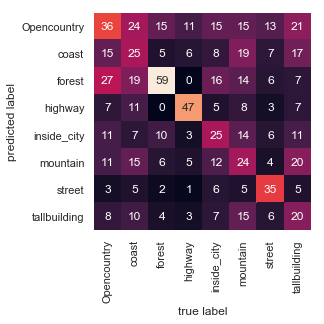

[0.24, 0.31, 0.27]
[0.25, 0.22, 0.23]
[0.4, 0.58, 0.47]
[0.53, 0.62, 0.57]
[0.29, 0.27, 0.28]
[0.25, 0.21, 0.23]
[0.56, 0.44, 0.49]
[0.27, 0.19, 0.22]
plotMat: [[0.24, 0.31, 0.27], [0.25, 0.22, 0.23], [0.4, 0.58, 0.47], [0.53, 0.62, 0.57], [0.29, 0.27, 0.28], [0.25, 0.21, 0.23], [0.56, 0.44, 0.49], [0.27, 0.19, 0.22]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


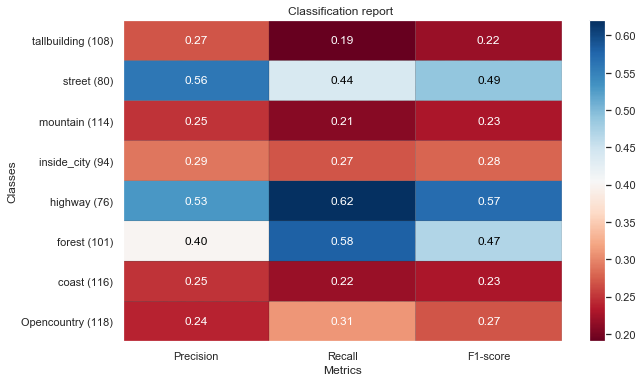

For method=Histogram image the accuracy is: 0.3358116480793061
Histogram descriptors
Accuracy0.8314745972738538
Precision0.8417159352150693
Recall0.8335494948995303
F1 Score0.8368387193946953


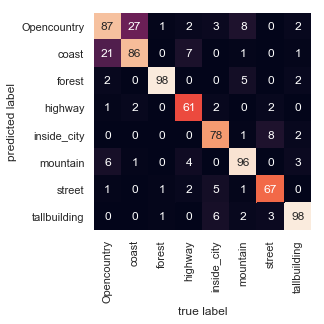

[0.67, 0.74, 0.7]
[0.74, 0.74, 0.74]
[0.92, 0.97, 0.94]
[0.9, 0.8, 0.85]
[0.88, 0.83, 0.85]
[0.87, 0.84, 0.86]
[0.87, 0.84, 0.85]
[0.89, 0.91, 0.9]
plotMat: [[0.67, 0.74, 0.7], [0.74, 0.74, 0.74], [0.92, 0.97, 0.94], [0.9, 0.8, 0.85], [0.88, 0.83, 0.85], [0.87, 0.84, 0.86], [0.87, 0.84, 0.85], [0.89, 0.91, 0.9]]
support: ['118', '116', '101', '76', '94', '114', '80', '108']


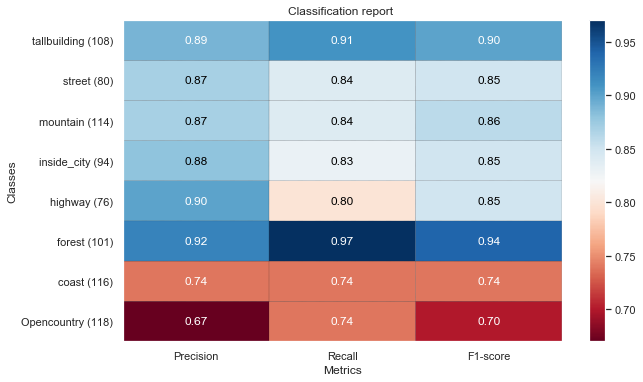

For method=Histogram descriptors the accuracy is: 0.8314745972738538


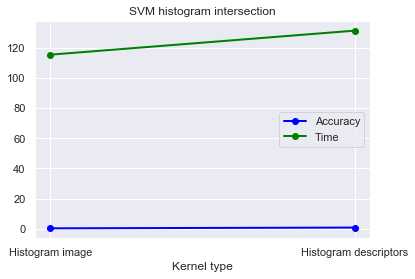

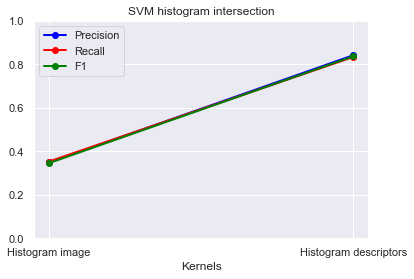

In [11]:
def get_histogramintersectionkernel(data_1, data_2, alpha=1.):
    return generatekernel(np.array(data_1) , np.array(data_2))

def generatekernel(data_1,data_2):
    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel
def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    plt.show()


def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(t[-1])
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in intert.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def plot_classification_report_custom(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[1 : (len(lines) - 1)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(t[-1])
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

if verbose_analysis:
    sampleClassificationReportCustom = "{0} {1} {2} {3}".format('precision', 'recall', 'f1-score',
                                                                'Method') + '\n'
    accuracies = list()
    precisions = list()
    recalls = list()
    f1s = list()
    time_list = list()
    methods_histogram = ['Histogram image', 'Histogram descriptors']

    for method in methods_histogram:
        print(method)
        step_size = 8
        start = time.time()
        SIFTdetector = cv2.xfeatures2d.SIFT_create()
        Train_descriptors = []
        Train_label_per_descriptor = []
        min_max_scaler = preprocessing.MinMaxScaler()
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)

            if method == 'Histogram image':
                hist = {}
                for i, col in enumerate(('b', 'g', 'r')):
                    hist[i] = cv2.calcHist([ima], [i], None, [256], [1, 256])
                ahist = (hist[0] + hist[1] + hist[2])
                des = ahist.flatten()

            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        k = 100
        visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
        codebook = []
        if method == 'Histogram descriptors':
            D = np.vstack(Train_descriptors)
            kmeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
            codebook = kmeans.fit(D)
            for i in range(len(Train_descriptors)):
                code, _ = vq.vq(Train_descriptors[i], codebook.cluster_centers_)
                word_hist, bin_edges = np.histogram(code, bins=range(codebook.cluster_centers_.shape[0] + 1))
                visual_words[i, :] = word_hist

        sv = svm.SVC(kernel=get_histogramintersectionkernel)

        if method == 'Histogram descriptors':
            sv.fit(visual_words, train_labels)
        else:
            sv.fit(Train_descriptors, train_labels)

        Test_descriptors = []
        for i in range(len(test_images_filenames)):

            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            if method == 'Histogram image':
                hist = {}
                for i, col in enumerate(('b', 'g', 'r')):
                    hist[i] = cv2.calcHist([ima], [i], None, [256], [1, 256])

                ahist = (hist[0] + hist[1] + hist[2])
                des = ahist.flatten()
            Test_descriptors.append(des)

        if method == 'Histogram descriptors':
            visual_words_test = np.zeros((len(Test_descriptors), k), dtype=np.float32)
            for i in range(len(Test_descriptors)):
                code, _ = vq.vq(Test_descriptors[i], codebook.cluster_centers_)
                word_hist, bin_edges = np.histogram(code, bins=range(codebook.cluster_centers_.shape[0] + 1))
                visual_words_test[i, :] = word_hist

            predict_labels = sv.predict(visual_words_test)
        else:
            predict_labels = sv.predict(Test_descriptors)

        accuracy = metrics.accuracy_score(test_labels, predict_labels)
        precision = metrics.precision_score(test_labels, predict_labels, average='macro')
        recall = metrics.recall_score(test_labels, predict_labels, average='macro')
        f1 = metrics.f1_score(test_labels, predict_labels, average='macro')
        end = time.time()
        tTime = end - start

        print('Accuracy' + str(accuracy))
        print('Precision' + str(precision))
        print('Recall' + str(recall))
        print('F1 Score' + str(f1))

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        time_list.append(tTime)
        sampleClassificationReportCustom += ("{0} {1} {2} {3}".format(precision, recall, f1,method) + '\n')

        mat = metrics.confusion_matrix(test_labels, predict_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=np.unique(predict_labels),
                    yticklabels=np.unique(predict_labels))
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()

        report = metrics.classification_report(test_labels, predict_labels, target_names=np.unique(predict_labels))
        plot_classification_report(report)

        print('For method=' + str(method) + ' the accuracy is: ' + str(accuracy))

    plt.plot(methods_histogram, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(methods_histogram, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('Kernel type')
    plt.title('SVM histogram intersection')
    plt.show()

    plt.plot(methods_histogram, precisions, 'go-', label='Precision', linewidth=2, color='blue')
    plt.plot(methods_histogram, recalls, 'go-', label='Recall', linewidth=2, color='red')
    plt.plot(methods_histogram, f1s, 'go-', label='F1', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall', 'F1'])
    plt.xlabel('Kernels')
    plt.title('SVM histogram intersection')
    plt.ylim([0, 1])
    plt.show()


**Pyramid**

0
Start pyramid
Accuracy0.7930607187112764
Precision0.8256383946225467
Recall0.7888831454339302
F1 Score0.7953562466870785


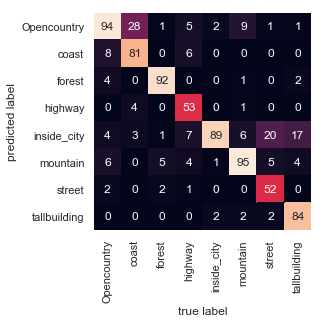

For pyramid level =0 the accuracy is: 0.7930607187112764
1
Start pyramid
Accuracy0.7558859975216853
Precision0.8148406093067715
Recall0.7515913973758104
F1 Score0.7615975862593256


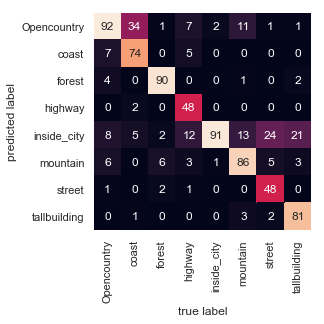

For pyramid level =1 the accuracy is: 0.7558859975216853
2
Start pyramid
Accuracy0.7509293680297398
Precision0.8107941236013548
Recall0.7437160837853215
F1 Score0.7533957686737303


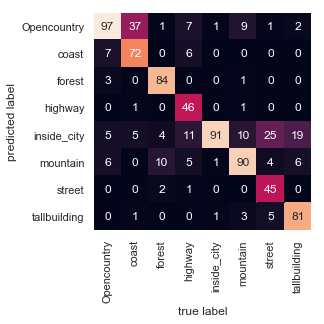

For pyramid level =2 the accuracy is: 0.7509293680297398


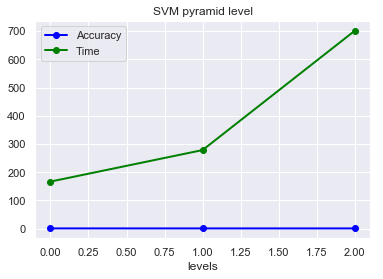

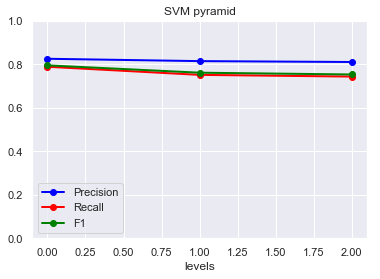

In [12]:
def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in intert.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    plt.show()


def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(t[-1])
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

def build_spatial_pyramid(image, descriptor, level):

    step_size = 8

    h = image.shape[0] / step_size
    w = image.shape[1] / step_size
    idx_crop = np.array(range(len(descriptor))).reshape(int(h),int(w))
    size = idx_crop.itemsize
    height, width = idx_crop.shape
    bh, bw = 2**(3-level), 2**(3-level)
    shape = (int(height/bh), int(width/bw),int(bh), int(bw))

    strides = size * np.array([width*bh, bw, width, 1])
    crops = np.lib.stride_tricks.as_strided(
            idx_crop, shape=shape, strides=strides)
    des_idxs = [col_block.flatten().tolist() for row_block in crops
                for col_block in row_block]
    pyramid = []
    for idxs in des_idxs:
        pyramid.append(np.asarray([descriptor[idx] for idx in idxs]))
    return pyramid

def spatial_pyramid_matching(image, descriptor, codebook, level):
    pyramid = []
    if level == 0:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        code = []
        for crop in pyramid:
            cod, _ = vq.vq(crop, codebook.cluster_centers_)
            word_hist, bin_edges = np.histogram(cod, bins=range(codebook.cluster_centers_.shape[0] + 1))
            code.append(word_hist)
        return np.asarray(code).flatten()
    if level == 1:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        code = []
        for crop in pyramid:
            cod, _ = vq.vq(crop, codebook.cluster_centers_)
            word_hist, bin_edges = np.histogram(cod, bins=range(codebook.cluster_centers_.shape[0] + 1))
            code.append(word_hist)
        code_level_0 = 0.5 * np.asarray(code[0]).flatten()
        code_level_1 = 0.5 * np.asarray(code[1:]).flatten()
        return np.concatenate((code_level_0, code_level_1))
    if level == 2:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        pyramid += build_spatial_pyramid(image, descriptor, level=2)
        code = []
        for crop in pyramid:
            cod, _ = vq.vq(crop, codebook.cluster_centers_)
            word_hist, bin_edges = np.histogram(cod, bins=range(codebook.cluster_centers_.shape[0] + 1))
            code.append(word_hist)
        code_level_0 = 0.25 * np.asarray(code[0]).flatten()
        code_level_1 = 0.25 * np.asarray(code[1:5]).flatten()
        code_level_2 = 0.5 * np.asarray(code[5:]).flatten()
        return np.concatenate((code_level_0, code_level_1, code_level_2))

if verbose_analysis:


    sampleClassificationReportCustom = "{0} {1} {2} {3}".format('precision', 'recall', 'f1-score',
                                                                'Arguments Kernel') + '\n'
    accuracies = list()
    precisions = list()
    recalls = list()
    f1s = list()
    time_list = list()
    num_level = [0,1,2]

    for level in num_level:
        x_train_im = list()
        print(level)
        step_size = 8
        start = time.time()
        SIFTdetector = cv2.xfeatures2d.SIFT_create()
        Train_descriptors = []
        Train_label_per_descriptor = []
        min_max_scaler = preprocessing.MinMaxScaler()
        for filename, labels in zip(train_images_filenames, train_labels):
            ima = cv2.imread(filename)
            x_train_im.append(ima)
            gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)

            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)

        D = np.vstack(Train_descriptors)
        k = 100
        kmeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False,
                                   reassignment_ratio=10 ** -4, random_state=42)
        codebook = kmeans.fit(D)


        x_train = [spatial_pyramid_matching(x_train_im[i],
                                            Train_descriptors[i],
                                            codebook,
                                            level=level)
                                            for i in range(len(x_train_im))]
        Train_descriptors = np.asarray(x_train)

        Test_descriptors = []
        visual_words_test = []
        x_test = []
        for i in range(len(test_images_filenames)):

            filename = test_images_filenames[i]
            ima = cv2.imread(filename)
            x_test.append(ima)
            gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
            kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                  for x in range(0, gray.shape[1], step_size)]
            kpt, des = SIFTdetector.compute(gray, kp)
            Test_descriptors.append(des)

        print("Start pyramid")
        x_test = [spatial_pyramid_matching(x_test[i],
                                           Test_descriptors[i],
                                           codebook,
                                           level=level) for i in range(len(x_test))]

        x_train = np.asarray(x_train)
        x_test = np.asarray(x_test)

        clf = svm.SVC(C=0.0001, kernel='poly', degree=3, gamma=0.01)
        clf.fit(x_train, train_labels)
        predict_labels = clf.predict(x_test)

        accuracy = metrics.accuracy_score(test_labels, predict_labels)
        precision = metrics.precision_score(test_labels, predict_labels, average='macro')
        recall = metrics.recall_score(test_labels, predict_labels, average='macro')
        f1 = metrics.f1_score(test_labels, predict_labels, average='macro')
        end = time.time()
        tTime = end - start

        print('Accuracy' + str(accuracy))
        print('Precision' + str(precision))
        print('Recall' + str(recall))
        print('F1 Score' + str(f1))

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        time_list.append(tTime)


        sampleClassificationReportCustom += ("{0} {1} {2} pyramid_level_{3}".format(precision, recall, f1, level) + '\n')

        mat = metrics.confusion_matrix(test_labels, predict_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=np.unique(predict_labels),
                    yticklabels=np.unique(predict_labels))
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()

        #report = metrics.classification_report(test_labels, predict_labels, target_names=np.unique(predict_labels))
        #plot_classification_report(report)

        print('For pyramid level =' + str(level) + ' the accuracy is: ' + str(accuracy))

    plt.plot(num_level, accuracies, 'go-', label='Accuracy', linewidth=2, color='blue')
    plt.plot(num_level, time_list, 'go-', label='Time', linewidth=2, color='green')
    plt.legend(['Accuracy', 'Time'])
    plt.xlabel('levels')
    plt.title('SVM pyramid level')
    plt.show()

    plt.plot(num_level, precisions, 'go-', label='Precision', linewidth=2, color='blue')
    plt.plot(num_level, recalls, 'go-', label='Recall', linewidth=2, color='red')
    plt.plot(num_level, f1s, 'go-', label='F1', linewidth=2, color='green')
    plt.legend(['Precision', 'Recall', 'F1'])
    plt.xlabel('levels')
    plt.title('SVM pyramid')
    plt.ylim([0, 1])
    plt.show()

In [33]:
Train_descriptors = []
Train_label_per_descriptor = []
for filename, labels in zip(train_images_filenames, train_labels):
    ima = cv2.imread(filename)
    x, y = ima.shape[:2]
    h = int(x)
    w = int(y)
    res = cv2.resize(ima, dsize=(h, w))
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
          for x in range(0, gray.shape[1], step_size)]
    kpt, des = SIFTdetector.compute(gray, kp)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)
D = np.vstack(Train_descriptors)

In [34]:
k = 140
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2800, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=140, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

In [35]:
visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
for i in range(len(Train_descriptors)):
    words = codebook.predict(Train_descriptors[i])
    visual_words[i, :] = np.bincount(words, minlength=k)

In [36]:
sv = svm.SVC(kernel='poly', degree=3, gamma=0.01, C=0.0001)
sv.fit(visual_words, train_labels)

SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
visual_words_test = np.zeros((len(test_images_filenames), k), dtype=np.float32)
results = list()
for i in range(len(test_images_filenames)):
    filename = test_images_filenames[i]
    ima = cv2.imread(filename)
    x, y = ima.shape[:2]
    h = int(x)
    w = int(y)
    res = cv2.resize(ima, dsize=(h, w))
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
          for x in range(0, gray.shape[1], step_size)]
    kpt, des = SIFTdetector.compute(gray, kp)
    words = codebook.predict(des)
    visual_words_test[i, :] = np.bincount(words, minlength=k)

In [38]:
predict_labels = sv.predict(visual_words_test)
accuracy = metrics.accuracy_score(test_labels, predict_labels)
print(accuracy)

0.8413878562577447


**CONCLUSIONS**